In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'

In [894]:
starttime = pytime.time()
loadSessionComplete('D:\\CNORecording',destination='D:\\CNO_Cache')
#loadSessionComplete('D:\\OpsinRecording',destination='D:\\Opsin_Cache')
#loadSessionComplete('D:\\OpsinControlRecording',destination='D:\\OpsinControl_Cache')
#loadSessionComplete('S:\\Sorts\DualRecording')
endtime = pytime.time()
print(str((endtime-starttime)/60/60)+' hours elapsed');

  0%|          | 0/3 [00:00<?, ?it/s]

D:\CNORecording\PB_116\PB_116 2\AC\session_metadata.json missing. Skipping


 33%|███▎      | 1/3 [00:00<00:00,  3.10it/s]

D:\CNORecording\PB_116\PB_116 2\M2\session_metadata.json complete
PB_116 2 complete
PB_116 complete
D:\CNORecording\PB_121\PB_121 1\AC\session_metadata.json missing. Skipping
D:\CNORecording\PB_121\PB_121 1\M2: 'group'
PB_121 1 complete
D:\CNORecording\PB_121\PB_121 2\AC\session_metadata.json missing. Skipping
D:\CNORecording\PB_121\PB_121 2\M2\session_metadata.json complete
PB_121 2 complete
PB_121 complete
D:\CNORecording\PB_122\PB_122 1\AC\session_metadata.json missing. Skipping


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]

D:\CNORecording\PB_122\PB_122 1\M2\session_metadata.json complete
PB_122 1 complete
PB_122 complete
D:\CNORecording complete
0.00022995432217915853 hours elapsed


In [2]:
directory = 'D:\\Analysis_Cache'

numbersessions = 0
numberdisqlen = 0
numberdisqISI = 0
numberdisqFR = 0
numAC = 0
numM2 = 0
numTrim = 0

sessions = os.listdir(directory)
for session in sessions:
    sessionfile = ilep.loadSessionCached(directory,session)
    numbersessions += 1
    numberdisqlen += len(sessionfile.disqualified.NumTrials)
    numberdisqISI += len(sessionfile.disqualified.ISI)
    numberdisqFR += len(sessionfile.disqualified.FRthresh)

    if sessionfile.meta.region == 'AC':
        numAC += len(sessionfile.clusters.good)
    elif sessionfile.meta.region == 'M2':
        numM2 += len(sessionfile.clusters.good)
    else:
        pass
    
    if hasattr(sessionfile,'trim'):
        numTrim += 1

print(str(numbersessions)+' sessions')
print('AC       : ' + str(numAC))
print('M2       : ' + str(numM2))
print('Trim     : ' + str(numTrim))
print('Disq Len : ' + str(numberdisqlen))
print('Disq ISI : ' + str(numberdisqISI))
print('Disq FR  : ' + str(numberdisqFR))
print(sessionfile.meta)

344 sessions
AC       : 2170
M2       : 2688
Trim     : 344
Disq Len : 544
Disq ISI : 33
Disq FR  : 74
namespace(animal='BS_95', arraystart=0, behavior='naive', condition='postreversal naive', date='3/1/2022', day_of_recording=6, day_of_reversal=3, day_of_training=11, depth=817, directory='D:\\DualRecording\\BS_95\\BS_95 6\\M2\\', files=['March 1 2022 Dual BS_95_6001', 'March 1 2022 Dual BS_95_6002', 'March 1 2022 Dual BS_95_6003'], fs=30000, length_in_minutes=18.683240555555553, length_in_samples=33629833.0, length_in_seconds=1120.9944333333333, length_in_trials=332, lickdelayrelativetostart=0.2, lickdelayrelativetotone=0.1, probe=8946, region='M2', task='reversal', tonelength=0.1, triallength=2.5)


# DEPTHS

 83%|████████▎ | 285/344 [00:00<00:00, 391.33it/s]

BS_72_4_M2.pickle
BS_83_6_M2.pickle
BS_83_9_M2.pickle
BS_85_7_M2.pickle
BS_85_7_M2.pickle
BS_85_7_M2.pickle


100%|██████████| 344/344 [00:00<00:00, 355.69it/s]

BS_85_8_AC.pickle



<ipython-input-6-9361644fd343>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0,200,400,600,800,1000,1200,1400],style='normal')


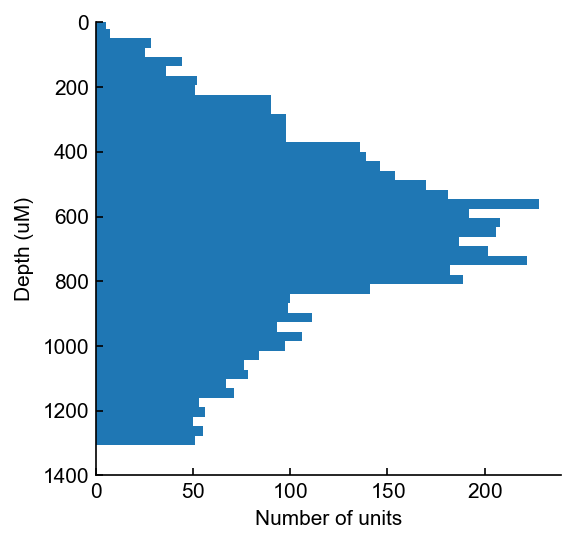

In [6]:
depthsgood = []
depths = []
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(destination,session)
    for g in sessionfile.clusters.good:
        depthsgood.append(sessionfile.clusters.depth[g])
        depths.append(sessionfile.clusters.depth[g])
        if(sessionfile.clusters.depth[g]<=0):
            print(session)
    #for g in sessionfile.clusters.disqualified:
    #    depths.append(sessionfile.clusters.depth[g])
    
fig,ax = plt.subplots(figsize=(4,4))
ax.hist(depths,bins=50,orientation='horizontal')
ax.set_ylabel('Depth (uM)')
ax.set_xlabel('Number of units')
ax.set_yticklabels([0,200,400,600,800,1000,1200,1400],style='normal')
ax.set_ylim([1400,0])
fig.savefig(os.path.join('D:\\\\Figures','Depth Distribution.png'),transparent=False,facecolor="white")

# Firing Rates

100%|██████████| 344/344 [00:53<00:00,  6.42it/s]


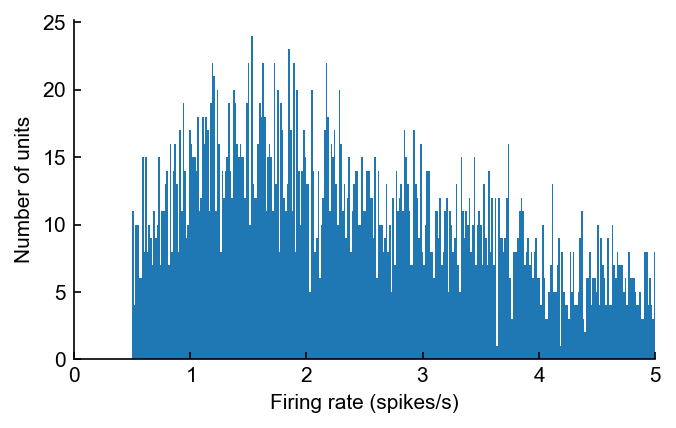

In [3]:
starttime = 0
endtime = 2.5

FR = []
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(directory,session)
    for clust in sessionfile.clusters.good:
        if not np.any(sessionfile.trim[clust].trimmed_trials):
            continue
        
        #Caching search -- Unit
        idx = np.equal(sessionfile.spikes.clusters,clust)
        totaltimes = sessionfile.spikes.times[idx]
        
        FRtrials = []
        for trial in sessionfile.trim[clust].trimmed_trials:
            trialstart = sessionfile.trials.starts[trial]
            #Caching search -- Condition
            idx = np.logical_and(      np.greater(totaltimes,trialstart+starttime*sessionfile.meta.fs) , np.less(totaltimes,trialstart+endtime*sessionfile.meta.fs)     )
            FRtrials.append( np.sum(idx) / (endtime-starttime) )
        FR.append(np.mean(FRtrials))
    
fig,ax = plt.subplots(figsize=(5,3))
ax.hist(FR,bins=5000)
ax.set_xlabel('Firing rate (spikes/s)')
ax.set_ylabel('Number of units')
ax.set_xlim([0,5])
#ax.set_yticklabels([0,200,400,600,800,1000,1200,1400],style='normal')
#ax.set_ylim([1400,0])
fig.savefig(os.path.join('D:\\\\TempFigures','FR Distribution.png'),transparent=False,facecolor="white")

# CONDITION BREAKDOWN

100%|██████████| 344/344 [00:00<00:00, 392.79it/s]


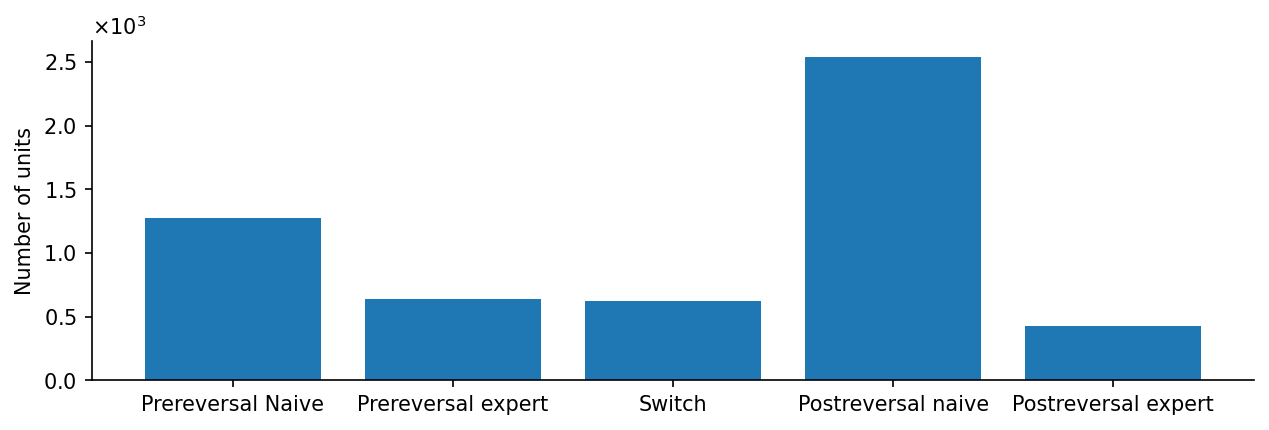

In [4]:
prenai = 0
preexp = 0
switch = 0
postnai = 0
postexp = 0
for session in tqdm(sessions):
    sessionfile = calculateStats(loadSessionCached(destination,session))
    if sessionfile.meta.condition == 'reversal':
        switch = switch + len(sessionfile.clusters.good)# + len(sessionfile.clusters.disqualified)
    elif sessionfile.meta.condition == 'prereversal naive':
        prenai = prenai + len(sessionfile.clusters.good)# + len(sessionfile.clusters.disqualified)
    elif sessionfile.meta.condition == 'prereversal expert':
        preexp = preexp + len(sessionfile.clusters.good)# + len(sessionfile.clusters.disqualified)
    elif sessionfile.meta.condition == 'postreversal naive':
        postnai = postnai + len(sessionfile.clusters.good)# + len(sessionfile.clusters.disqualified)
    elif sessionfile.meta.condition == 'postreversal expert':
        postexp = postexp + len(sessionfile.clusters.good)# + len(sessionfile.clusters.disqualified)
        
bars = [prenai, preexp, switch, postnai, postexp]
labels = ['Prereversal Naive', 'Prereversal expert', 'Switch', 'Postreversal naive', 'Postreversal expert']
fig,ax = plt.subplots(figsize=(10,3))
ax.bar(labels,bars)
ax.set_ylabel('Number of units')
fig.savefig(os.path.join('D:\\\\Figures','Condition Distribution.png'),transparent=False,facecolor="white")

100%|██████████| 344/344 [00:00<00:00, 350.11it/s]


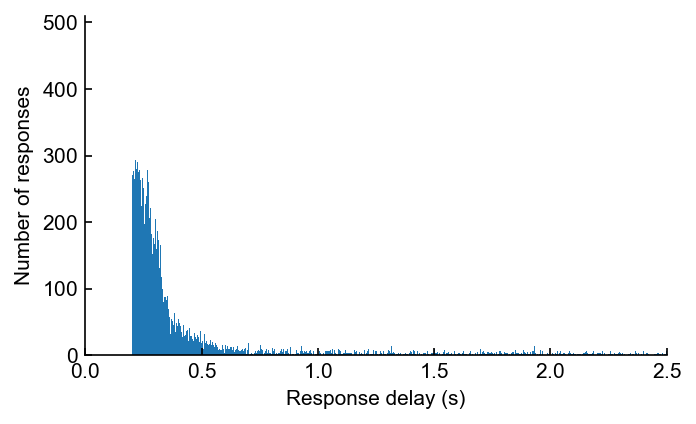

In [32]:
delays = []
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(directory,session)      #It is not ideal that this method uses the cache, since it is supposed to run before the caching
    delays = np.concatenate((delays,sessionfile.trials.response-sessionfile.trials.starts))
delays = delays / sessionfile.meta.fs

fig,ax = plt.subplots(figsize=(5,3))
ax.hist(delays,bins=5000)
ax.set_xlabel('Response delay (s)')
ax.set_ylabel('Number of responses')
ax.set_xlim([0,2.5])
fig.savefig(os.path.join('D:\\\\Figures','Lick delay distribution.png'),transparent=False,facecolor="white")

100it [00:00, ?it/s]


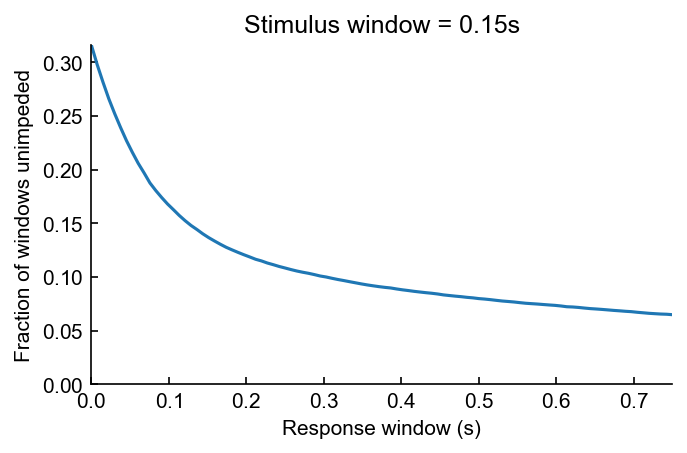

In [30]:
swindow = 0.15
rwindows = np.linspace(0,0.75,num=100)
fractions = np.zeros(len(rwindows))
for idx,rwindow in tqdm(enumerate(rwindows)):
    minstarttime = 0+swindow+rwindow
    fractions[idx] = np.mean(np.greater(delays,minstarttime))
    
fig,ax = plt.subplots(figsize=(5,3))
ax.set_xlim([0,0.75])
ax.set_ylim([0,np.max(fractions)])
ax.plot(rwindows,fractions)
ax.set_xlabel('Response window (s)')
ax.set_ylabel('Fraction of windows unimpeded')
ax.set_title('Stimulus window = '+str(swindow)+'s')
fig.savefig(os.path.join('D:\\\\TempFigures','Unimpeded window distribution.png'),transparent=False,facecolor="white")

100%|██████████| 344/344 [00:01<00:00, 186.32it/s]


55752 rewarded trials
92632 unrewarded trials


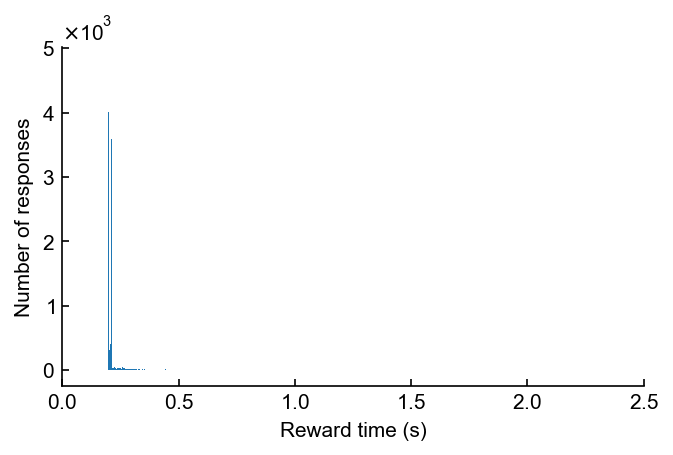

In [31]:
numreward = 0
numnoreward = 0
rewards = []
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(directory,session)      #It is not ideal that this method uses the cache, since it is supposed to run before the caching
    for s,e in zip(sessionfile.trials.starts,sessionfile.trials.ends):
        idxs = np.logical_and(     np.greater(sessionfile.behavior.reward_times,s),np.less(sessionfile.behavior.reward_times,e)      )
        times = sessionfile.behavior.reward_times[idxs]
        if len(times) > 0:
            rewards = np.concatenate((rewards,times-s))
            numreward+=1
        else:
            numnoreward+=1
rewards = rewards / sessionfile.meta.fs

print(str(numreward) + ' rewarded trials')
print(str(numnoreward) + ' unrewarded trials')

fig,ax = plt.subplots(figsize=(5,3))
ax.hist(rewards,bins=5000)
ax.set_xlabel('Reward time (s)')
ax.set_ylabel('Number of responses')
ax.set_xlim([0,2.5])
ylims = ax.get_ylim()
ax.set_ylim([-0.05*ylims[1],ylims[1]])
#ax.spines['bottom'].set_visible(False)
#ax.get_xaxis().set_visible(False)
fig.savefig(os.path.join('D:\\\\Figures','Reward distribution.png'),transparent=False,facecolor="white")

C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-222-2133c79d1412>:138: RuntimeWarning: Mean of empty slice
  onmean = np.nanmean(onMisses)
<ipython-input-222-2133c79d1412>:141: RuntimeWarning: Mean of empty slice
  offmean = np.nanmean(offMisses)
<ipython-input-222-2133c79d1412>:162: RuntimeWarning: Mean of empty slice
  onmean = np.nanmean(onCrejects)


All numbers are identical in mannwhitneyu


<ipython-input-222-2133c79d1412>:165: RuntimeWarning: Mean of empty slice
  offmean = np.nanmean(offCrejects)


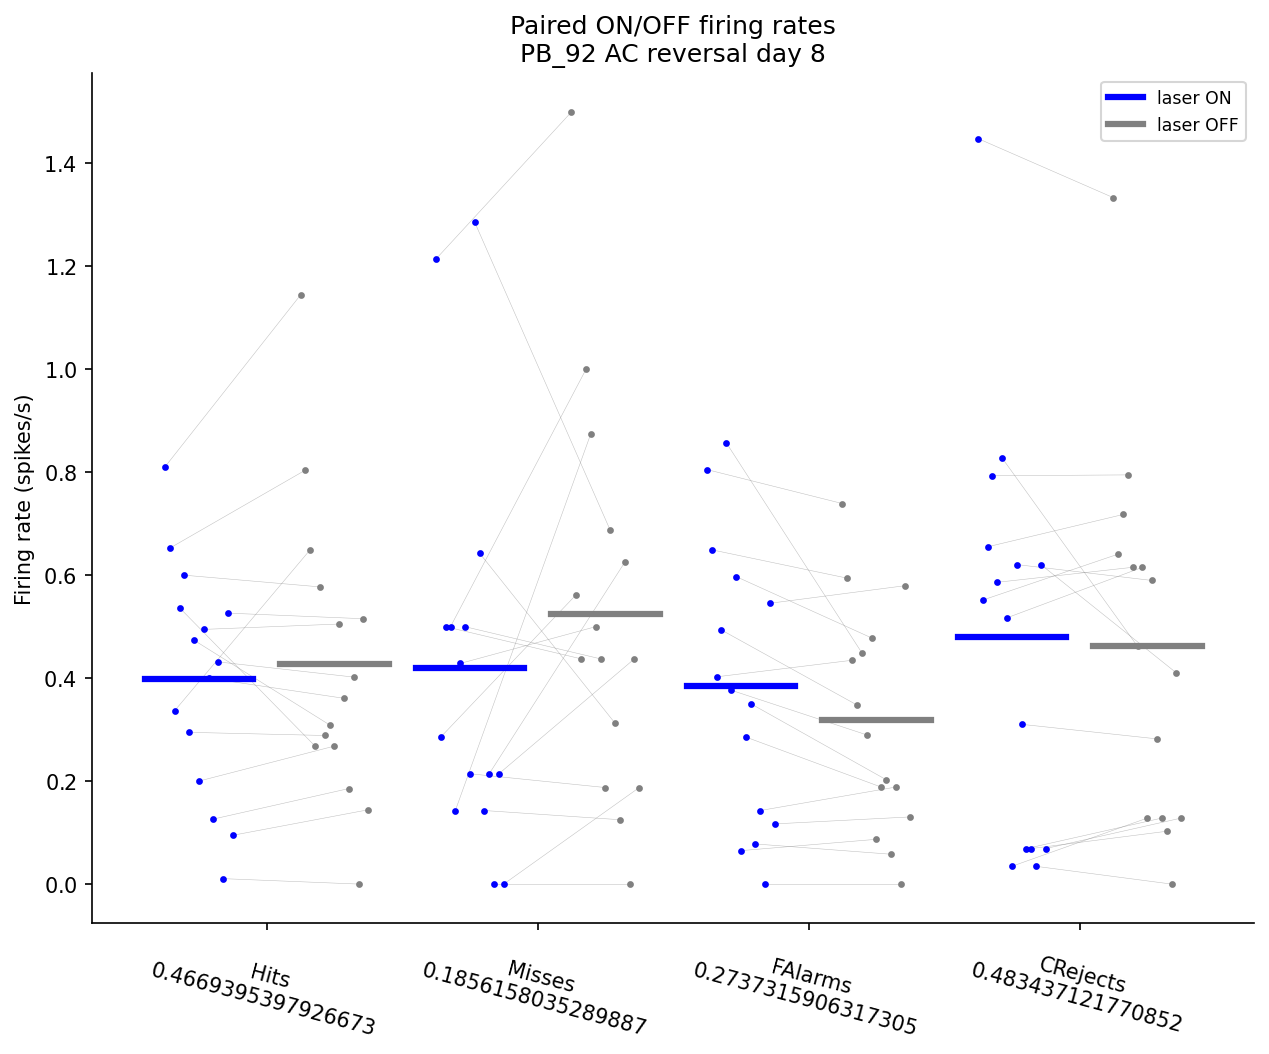

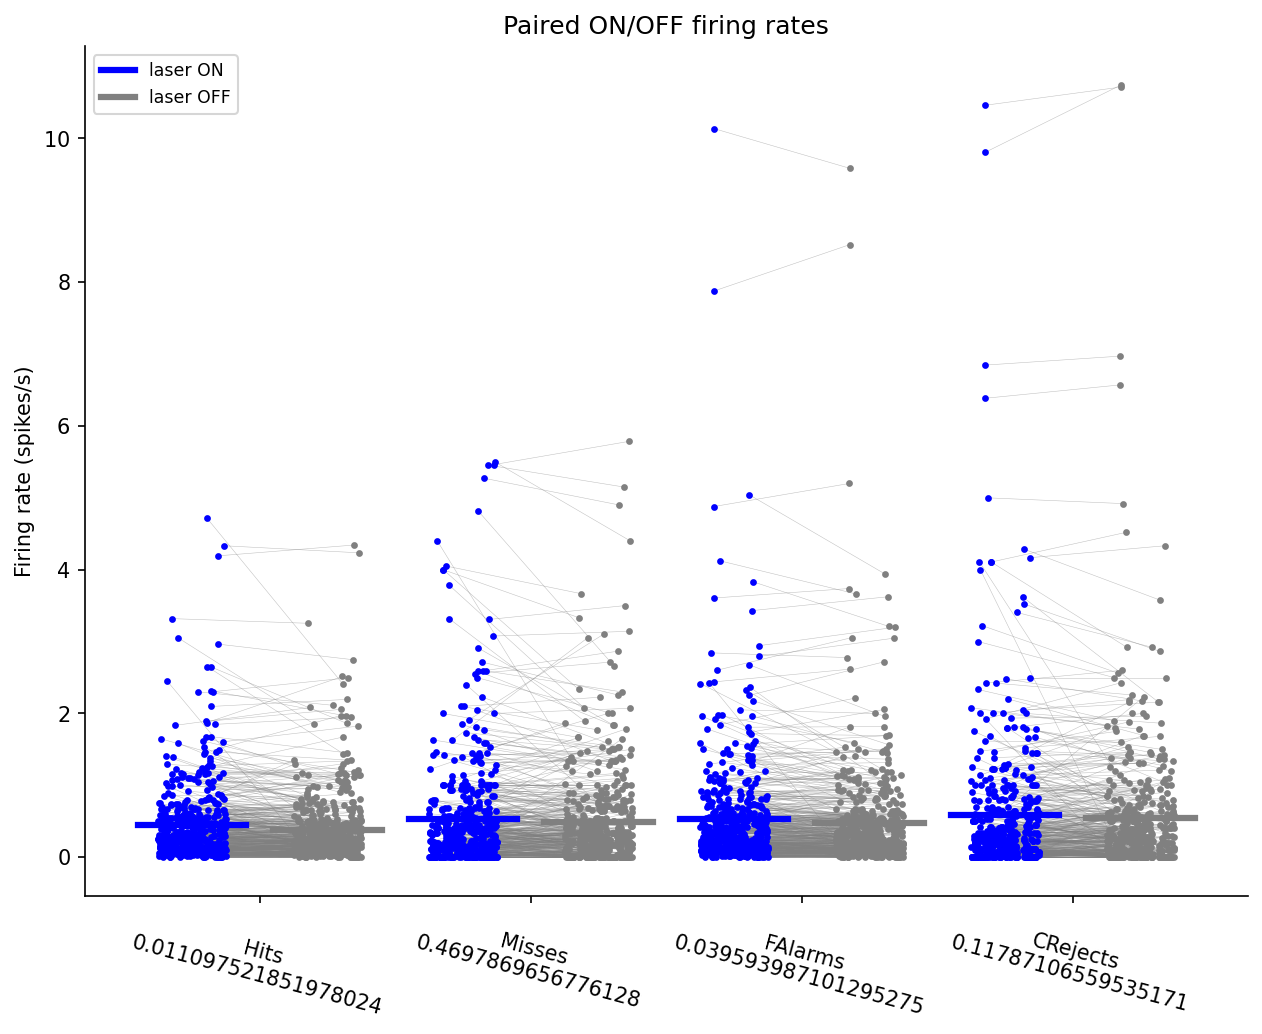

In [222]:
def isUnitValid(session,clust):
    with open('D:\\\\NoiseUnits.txt','r') as f:
        lines = f.readlines()
    for line in lines:
        if line.split(',',0) == session and line.split(',',1) == str(clust):
            return False
    return True

starttime = 0.0
endtime = 0.1
size=5

totalonHits = []
totalonMisses = []
totalonFalarms = []
totalonCrejects = []
totaloffHits = []
totaloffMisses = []
totaloffFalarms = []
totaloffCrejects = []

for session in (sessions):
    #print(session)
    #if(session!='BS_103_7_opto_AC.pickle'):
    #    continue
    try:
        sessionfile = loadSessionCached(destination,session)
        
        laserON = sessionfile.trials.laser_stimulation
        laserOFF = np.logical_not(laserON)
        GoResponse = sessionfile.trials.go
        NogoResponse = np.logical_not(GoResponse)
        TargetTone = sessionfile.trials.target
        NontargetTone = np.logical_not(TargetTone)
        
        Hits = np.logical_and(TargetTone,GoResponse)
        Misses = np.logical_and(TargetTone,NogoResponse)
        FAlarms = np.logical_and(NontargetTone,GoResponse)
        CRejects = np.logical_and(NontargetTone,NogoResponse)
        Correct = np.logical_or(Hits,CRejects)
        Incorrect = np.logical_or(Misses,FAlarms)
        
        onHits = []
        onMisses = []
        onFalarms = []
        onCrejects = []
        offHits = []
        offMisses = []
        offFalarms = []
        offCrejects = []
        
        neurons = sessionfile.clusters.good
        for clust in neurons:
            
            if not isUnitValid(session,clust):
                continue
            
            temponHits = []
            temponMisses = []
            temponFalarms = []
            temponCrejects = []
            tempoffHits = []
            tempoffMisses = []
            tempoffFalarms = []
            tempoffCrejects = []
            
            laserfiringrates = []
            nonlaserfiringrates = []
            
            #Caching search
            idx = np.equal(sessionfile.spikes.clusters,clust)
            totaltimes = sessionfile.spikes.times[idx]
            
            for trial in range(sessionfile.meta.length_in_trials):
                trialstart = sessionfile.trials.starts[trial]
                
                #Caching search
                idx = np.logical_and(      np.greater(totaltimes,trialstart+starttime*sessionfile.meta.fs) , np.less(totaltimes,trialstart+endtime*sessionfile.meta.fs)     )
                numspikes = len(totaltimes[idx])
                
                if laserON[trial]:
                    if Hits[trial]:
                        temponHits.append(numspikes)
                    elif Misses[trial]:
                        temponMisses.append(numspikes)
                    elif FAlarms[trial]:
                        temponFalarms.append(numspikes)
                    elif CRejects[trial]:
                        temponCrejects.append(numspikes)
                elif laserOFF[trial]:
                    if Hits[trial]:
                        tempoffHits.append(numspikes)
                    elif Misses[trial]:
                        tempoffMisses.append(numspikes)
                    elif FAlarms[trial]:
                        tempoffFalarms.append(numspikes)
                    elif CRejects[trial]:
                        tempoffCrejects.append(numspikes)
                        
            onHits.append(np.mean(temponHits))
            onMisses.append(np.mean(temponMisses))
            onFalarms.append(np.mean(temponFalarms))
            onCrejects.append(np.mean(temponCrejects))
            offHits.append(np.mean(tempoffHits))
            offMisses.append(np.mean(tempoffMisses))
            offFalarms.append(np.mean(tempoffFalarms))
            offCrejects.append(np.mean(tempoffCrejects))
            
            totalonHits.append(np.mean(temponHits))
            totalonMisses.append(np.mean(temponMisses))
            totalonFalarms.append(np.mean(temponFalarms))
            totalonCrejects.append(np.mean(temponCrejects))
            totaloffHits.append(np.mean(tempoffHits))
            totaloffMisses.append(np.mean(tempoffMisses))
            totaloffFalarms.append(np.mean(tempoffFalarms))
            totaloffCrejects.append(np.mean(tempoffCrejects))
            
        plt.close('all')
        fig,ax = plt.subplots(figsize=(10,7.5))
        width = 0.25
        width2 = 0.4
            
        #Hits
        xrange1 = np.linspace(-width,width,num=len(onHits))
        xrange2 = np.linspace(1-width,1+width,num=len(offHits))    
        ax.plot([xrange1,xrange2],[onHits,offHits],lw=0.25,color='grey',alpha=0.5,zorder=-10)
        ax.scatter(xrange1,onHits,color='blue',s=size)
        onmean = np.nanmean(onHits)
        ax.plot([-width2,width2],[onmean,onmean],color='blue',lw=3,label='laser ON')
        ax.scatter(xrange2,offHits,color='grey',s=size)
        offmean = np.nanmean(offHits)
        ax.plot([1-width2,1+width2],[offmean,offmean],color='grey',lw=3,label='laser OFF')
        hitpval = mannwhitneyu(onHits,offHits).pvalue
        
        #Misses
        xrange1 = np.linspace(2-width,2+width,num=len(onMisses))
        xrange2 = np.linspace(3-width,3+width,num=len(offMisses))    
        ax.plot([xrange1,xrange2],[onMisses,offMisses],lw=0.25,color='grey',alpha=0.5,zorder=-10)
        ax.scatter(xrange1,onMisses,color='blue',s=size)
        onmean = np.nanmean(onMisses)
        ax.plot([2-width2,2+width2],[onmean,onmean],color='blue',lw=3)
        ax.scatter(xrange2,offMisses,color='grey',s=size)
        offmean = np.nanmean(offMisses)
        ax.plot([3-width2,3+width2],[offmean,offmean],color='grey',lw=3)
        misspval = mannwhitneyu(onMisses,offMisses).pvalue
        
        #Hits
        xrange1 = np.linspace(4-width,4+width,num=len(onFalarms))
        xrange2 = np.linspace(5-width,5+width,num=len(offFalarms))    
        ax.plot([xrange1,xrange2],[onFalarms,offFalarms],lw=0.25,color='grey',alpha=0.5,zorder=-10)
        ax.scatter(xrange1,onFalarms,color='blue',s=size)
        onmean = np.nanmean(onFalarms)
        ax.plot([4-width2,4+width2],[onmean,onmean],color='blue',lw=3)
        ax.scatter(xrange2,offFalarms,color='grey',s=size)
        offmean = np.nanmean(offFalarms)
        ax.plot([5-width2,5+width2],[offmean,offmean],color='grey',lw=3)
        falarmpval = mannwhitneyu(onFalarms,offFalarms).pvalue
        
        #Hits
        xrange1 = np.linspace(6-width,6+width,num=len(onCrejects))
        xrange2 = np.linspace(7-width,7+width,num=len(offCrejects))    
        ax.plot([xrange1,xrange2],[onCrejects,offCrejects],lw=0.25,color='grey',alpha=0.5,zorder=-10)
        ax.scatter(xrange1,onCrejects,color='blue',s=size)
        onmean = np.nanmean(onCrejects)
        ax.plot([6-width2,6+width2],[onmean,onmean],color='blue',lw=3)
        ax.scatter(xrange2,offCrejects,color='grey',s=size)
        offmean = np.nanmean(offCrejects)
        ax.plot([7-width2,7+width2],[offmean,offmean],color='grey',lw=3)
        crejectpval = mannwhitneyu(onCrejects,offCrejects).pvalue
        
        ax.set_xticks([0.5,2.5,4.5,6.5])
        ax.set_xticklabels(['Hits\n'+str(hitpval),'Misses\n'+str(misspval),'FAlarms\n'+str(falarmpval),'CRejects\n'+str(crejectpval)],rotation=-15)
        ax.set_ylabel('Firing rate (spikes/s)')
        ax.legend()
        if sessionfile.meta.task == 'opto reversal':
            filename = sessionfile.meta.animal+' '+sessionfile.meta.region+' reversal day '+str(sessionfile.meta.day_of_reversal)
        elif sessionfile.meta.task == 'opto switch':
            filename = sessionfile.meta.animal+' '+sessionfile.meta.region+' day of reversal'
        ax.set_title('Paired ON/OFF firing rates\n'+filename)
        fig.savefig(os.path.join('D:\\\\Figures','OpsinFRbySession',filename+'.png'),transparent=False,facecolor="white")
    except Exception as e:
        print(e)

onHits = totalonHits
onMisses = totalonMisses
onFalarms = totalonFalarms
onCrejects = totalonCrejects
offHits = totaloffHits
offMisses = totaloffMisses
offFalarms = totaloffFalarms
offCrejects = totaloffCrejects

fig,ax = plt.subplots(figsize=(10,7.5))
width = 0.25
width2 = 0.4
            
#Hits
xrange1 = np.linspace(-width,width,num=len(onHits))
xrange2 = np.linspace(1-width,1+width,num=len(offHits))    
ax.plot([xrange1,xrange2],[onHits,offHits],lw=0.25,color='grey',alpha=0.5,zorder=-10)
ax.scatter(xrange1,onHits,color='blue',s=size)
onmean = np.nanmean(onHits)
ax.plot([-width2,width2],[onmean,onmean],color='blue',lw=3,label='laser ON')
ax.scatter(xrange2,offHits,color='grey',s=size)
offmean = np.nanmean(offHits)
ax.plot([1-width2,1+width2],[offmean,offmean],color='grey',lw=3,label='laser OFF')
hitpval = mannwhitneyu(onHits,offHits).pvalue
        
#Misses
xrange1 = np.linspace(2-width,2+width,num=len(onMisses))
xrange2 = np.linspace(3-width,3+width,num=len(offMisses))    
ax.plot([xrange1,xrange2],[onMisses,offMisses],lw=0.25,color='grey',alpha=0.5,zorder=-10)
ax.scatter(xrange1,onMisses,color='blue',s=size)
onmean = np.nanmean(onMisses)
ax.plot([2-width2,2+width2],[onmean,onmean],color='blue',lw=3)
ax.scatter(xrange2,offMisses,color='grey',s=size)
offmean = np.nanmean(offMisses)
ax.plot([3-width2,3+width2],[offmean,offmean],color='grey',lw=3)
misspval = mannwhitneyu(onMisses,offMisses).pvalue
        
#Hits
xrange1 = np.linspace(4-width,4+width,num=len(onFalarms))
xrange2 = np.linspace(5-width,5+width,num=len(offFalarms))    
ax.plot([xrange1,xrange2],[onFalarms,offFalarms],lw=0.25,color='grey',alpha=0.5,zorder=-10)
ax.scatter(xrange1,onFalarms,color='blue',s=size)
onmean = np.nanmean(onFalarms)
ax.plot([4-width2,4+width2],[onmean,onmean],color='blue',lw=3)
ax.scatter(xrange2,offFalarms,color='grey',s=size)
offmean = np.nanmean(offFalarms)
ax.plot([5-width2,5+width2],[offmean,offmean],color='grey',lw=3)
falarmpval = mannwhitneyu(onFalarms,offFalarms).pvalue
        
#Hits
xrange1 = np.linspace(6-width,6+width,num=len(onCrejects))
xrange2 = np.linspace(7-width,7+width,num=len(offCrejects))    
ax.plot([xrange1,xrange2],[onCrejects,offCrejects],lw=0.25,color='grey',alpha=0.5,zorder=-10)
ax.scatter(xrange1,onCrejects,color='blue',s=size)
onmean = np.nanmean(onCrejects)
ax.plot([6-width2,6+width2],[onmean,onmean],color='blue',lw=3)
ax.scatter(xrange2,offCrejects,color='grey',s=size)
offmean = np.nanmean(offCrejects)
ax.plot([7-width2,7+width2],[offmean,offmean],color='grey',lw=3)
crejectpval = mannwhitneyu(onCrejects,offCrejects).pvalue
        
ax.set_xticks([0.5,2.5,4.5,6.5])
ax.set_xticklabels(['Hits\n'+str(hitpval),'Misses\n'+str(misspval),'FAlarms\n'+str(falarmpval),'CRejects\n'+str(crejectpval)],rotation=-15)
ax.set_ylabel('Firing rate (spikes/s)')
ax.legend()
ax.set_title('Paired ON/OFF firing rates')
fig.savefig(os.path.join('D:\\\\Figures','OpsinFRPaired.png'),transparent=False,facecolor="white")

  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting

Significances: All numbers are identical in mannwhitneyu
Significances: All numbers are identical in mannwhitneyu
Significances: All numbers are identical in mannwhitneyu
PSTHs: `dataset` input should have multiple elements.
PSTHs: `dataset` input should have multiple elements.
Significances: All numbers are identical in mannwhitneyu
Significances: All numbers are identical in mannwhitneyu
Significances: All numbers are identical in mannwhitneyu


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_method

Significances: All numbers are identical in mannwhitneyu
Significances: All numbers are identical in mannwhitneyu


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 2/2 [01:19<00:00, 39.59s/it]


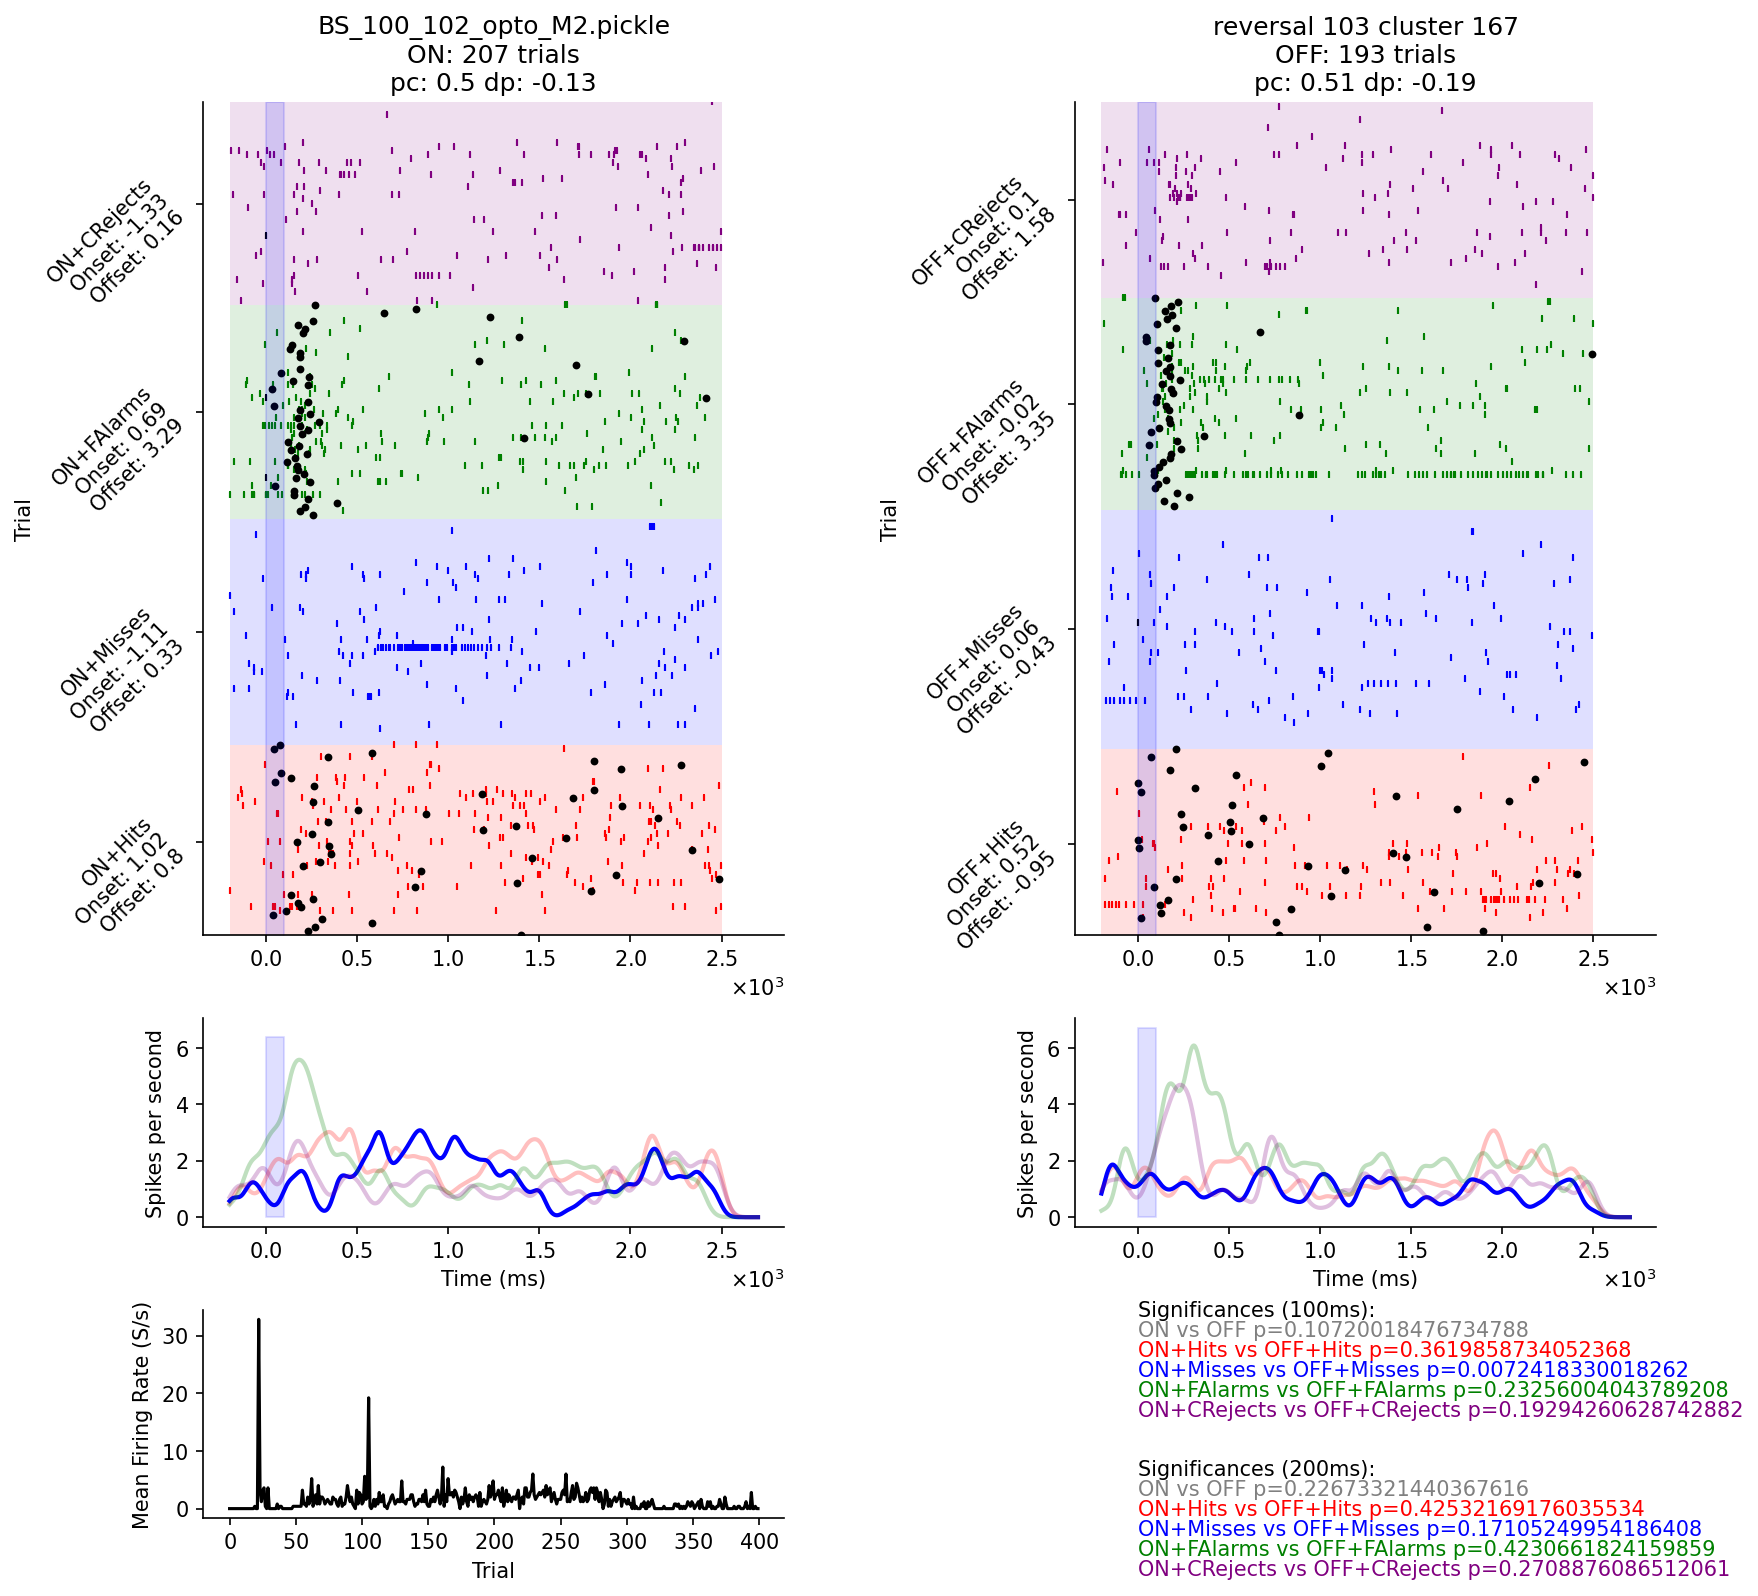

In [24]:
### SEPARATED BY GO/NOGO OR TARGET/NONTARGET

starttime = -0.2
endtime = 2.5
numbins = 100 + 1

artifactwindow = 2

height=10
width=1
trans=0.125
custommarker = mpl.path.Path([[-width,-height],[-width,height],[width,height],[width,-height]],closed=True)
    
for session in tqdm(sessions):
    try:
        sessionfile = loadSessionCached(destination,session)
        neurons = sessionfile.clusters.good
        
        ##########################################################################################################################
        laserON = sessionfile.trials.laser_stimulation
        laserOFF = np.logical_not(laserON)
        GoResponse = sessionfile.trials.go
        NogoResponse = np.logical_not(GoResponse)
        TargetTone = sessionfile.trials.target
        NontargetTone = np.logical_not(TargetTone)
        
        Hits = np.logical_and(TargetTone,GoResponse)
        Misses = np.logical_and(TargetTone,NogoResponse)
        FAlarms = np.logical_and(NontargetTone,GoResponse)
        CRejects = np.logical_and(NontargetTone,NogoResponse)
        Correct = np.logical_or(Hits,CRejects)
        Incorrect = np.logical_or(Misses,FAlarms)
        
        #Condition A
        conditionA = SimpleNamespace()
        conditionA.trials = (np.logical_and(laserON,Hits))
        conditionA.label = 'ON+Hits'
        conditionA.color = 'red'
        #Condition B
        conditionB = SimpleNamespace()
        conditionB.trials = (np.logical_and(laserON,Misses))
        conditionB.label = 'ON+Misses'
        conditionB.color = 'blue'
        #Condition C
        conditionC = SimpleNamespace()
        conditionC.trials = (np.logical_and(laserON,FAlarms))
        conditionC.label = 'ON+FAlarms'
        conditionC.color = 'green'
        #Condition D
        conditionD = SimpleNamespace()
        conditionD.trials = (np.logical_and(laserON,CRejects))
        conditionD.label = 'ON+CRejects'
        conditionD.color = 'purple'
        
        #Condition E
        conditionE = SimpleNamespace()
        conditionE.trials = (np.logical_and(laserOFF,Hits))
        conditionE.label = 'OFF+Hits'
        conditionE.color = 'red'
        #Condition F
        conditionF = SimpleNamespace()
        conditionF.trials = (np.logical_and(laserOFF,Misses))
        conditionF.label = 'OFF+Misses'
        conditionF.color = 'blue'
        #Condition G
        conditionG = SimpleNamespace()
        conditionG.trials = (np.logical_and(laserOFF,FAlarms))
        conditionG.label = 'OFF+FAlarms'
        conditionG.color = 'green'
        #Condition H
        conditionH = SimpleNamespace()
        conditionH.trials = (np.logical_and(laserOFF,CRejects))
        conditionH.label = 'OFF+CRejects'
        conditionH.color = 'purple'
        
        #OnOff for overall significance
        #Condition I
        conditionI = SimpleNamespace()
        conditionI.trials = (laserON)
        conditionI.label = 'ON'
        conditionI.color = 'blue'
        #Condition J
        conditionJ = SimpleNamespace()
        conditionJ.trials = (laserOFF)
        conditionJ.label = 'OFF'
        conditionJ.color = 'grey'

        conditions = [conditionA,conditionB,conditionC,conditionD,conditionE,conditionF,conditionG,conditionH,conditionI,conditionJ]
        #Convert trials into idxs -- more useful for algorithm
        for cond in conditions:
            cond.trials = np.array(np.where(cond.trials)[0])
        ##########################################################################################################################
        totaltrials = 0
        for cond in conditions:
            totaltrials += len(cond.trials)
        
        for clust in neurons:
            plt.close('all')
            fig = plt.figure(figsize=(12.5,12.5))
            gs = fig.add_gridspec(3,2,height_ratios=[4,1,1],hspace=0.2,wspace=0.5)#0.1)
                
            ax1 = plt.subplot(gs[0,0])#Raster
            ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
            ax3 = plt.subplot(gs[0,1])#FRs
            ax4 = plt.subplot(gs[1,1],sharex=ax3,sharey=ax2)#Percent Go
            ax5 = plt.subplot(gs[2,0])#Timecourse
            
            #Caching search -- Unit
            idx = np.equal(sessionfile.spikes.clusters,clust)
            totaltimes = sessionfile.spikes.times[idx]
            
            FRpertrial = []
            #Overall Nonstationarity
            for trial in range(sessionfile.meta.length_in_trials):
                trialstart = sessionfile.trials.starts[trial]
                trialend = sessionfile.trials.ends[trial]
                idxtone = np.logical_and(   np.greater(totaltimes,trialstart) , np.less(totaltimes,trialend)  )
                timestone = totaltimes[idxtone]
                trialtime = (trialend-trialstart) / sessionfile.meta.fs
                FRpertrial.append(len(timestone) / trialtime)
            
            for cond in conditions:         
                cond.latency = []
                cond.firingrates = []
                cond.timestoplot = []
                cond.trialstoplot = []
                cond.responsetimestoplot = []
                cond.responsetrialstoplot = []
                cond.peristimulustimes = []
                cond.onsetmodulation = np.nan
                cond.offsetmodulation = np.nan
                cond.pc = np.nan
                cond.dp = np.nan
                cond.artifactstoplot = []
                cond.artifacttrialstoplot = []
                
                cond.firingbins100 = []
                cond.firingbins200 = []
                
                pretonebin1 = []
                pretonebin2 = []
                tonebin = []
                posttonebin = []
                
                #Calculate Behavior Stats
                temparray = np.zeros(sessionfile.meta.length_in_trials)
                temparray[cond.trials] = np.ones(len(cond.trials))
                condhits = np.sum(np.logical_and(temparray,Hits))
                condmisses = np.sum(np.logical_and(temparray,Misses))
                condfalarms = np.sum(np.logical_and(temparray,FAlarms))
                condcrejects = np.sum(np.logical_and(temparray,CRejects))
                
                try:
                    cond.pc = (condhits+condmisses) / (condhits+condmisses+condfalarms+condcrejects)
                except Exception:
                    pass
                try:
                    cond.dp = norm.ppf((condhits+1)/(condhits+condmisses+2)) - norm.ppf((condfalarms+1)/(condfalarms+condcrejects+2))
                except Exception:
                    pass
                
                for trialidx in range(len(cond.trials)):
                    trial = cond.trials[trialidx]
                    trialstart = sessionfile.trials.starts[trial]
                    
                    #Caching search -- Condition
                    idx = np.logical_and(      np.greater(totaltimes,trialstart+starttime*sessionfile.meta.fs) , np.less(totaltimes,trialstart+endtime*sessionfile.meta.fs)     )
                    times = totaltimes[idx]
                    
                    #PSTH times
                    temp = np.array((times-trialstart)/sessionfile.meta.fs*1000)
                    temp1 = np.logical_or( np.less(temp,-artifactwindow) , np.greater(temp,artifactwindow)  )
                    temp2 = np.logical_or( np.less(temp,100-artifactwindow) , np.greater(temp,100+artifactwindow)  )
                    temp = temp[np.logical_and(temp1,temp2)]
                    cond.peristimulustimes = np.concatenate((cond.peristimulustimes,temp))
                    
                    #Response times
                    if (sessionfile.trials.go[trial]):
                        cond.responsetimestoplot.append((sessionfile.trials.response[trial]-trialstart)/sessionfile.meta.fs*1000)
                        cond.responsetrialstoplot.append(trialidx+1)
                    
                    #Each spike time to plot
                    for spike in (temp):
                        cond.timestoplot.append(spike)
                        cond.trialstoplot.append(trialidx+1)

                    #Artifacts
                    artifacts = np.array((times-trialstart)/sessionfile.meta.fs*1000)
                    artifacts1 = np.logical_and( np.greater(artifacts,-artifactwindow) , np.less(artifacts,artifactwindow)  )
                    artifacts2 = np.logical_and( np.greater(artifacts,100-artifactwindow) , np.less(artifacts,100+artifactwindow)  )
                    artifacts = artifacts[np.logical_or(artifacts1,artifacts2)]
                    for event in artifacts:
                        cond.artifactstoplot.append(event)
                        cond.artifacttrialstoplot.append(trialidx+1)
                    
                    #Caching search -- Pre-tone period (1)
                    binstart = trialstart-0.2*sessionfile.meta.fs
                    binend = trialstart-0.1*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    pretonebin1.append(len(timestone))
                    
                    #Caching search -- Pre-tone period (2)
                    binstart = trialstart-0.1*sessionfile.meta.fs
                    binend = trialstart+0*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    pretonebin2.append(len(timestone))
                    
                    #Caching search -- Tone Period
                    binstart = trialstart+0*sessionfile.meta.fs
                    binend = trialstart+0.1*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    tonebin.append(len(timestone))
                    cond.firingbins100.append(len(timestone))
                    tempvar = (len(timestone))
                    #Latency and firing rate
                    if len(timestone)>0:
                        cond.latency.append( (np.min(timestone)-trialstart)/sessionfile.meta.fs*1000)
                    else:
                        cond.latency.append(np.nan)
                    cond.firingrates.append(len(timestone) / (0.1))
                    
                    #Caching search -- Post-tone period
                    binstart = trialstart+0.1*sessionfile.meta.fs
                    binend = trialstart+0.2*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    posttonebin.append(len(timestone))
                    cond.firingbins200.append(len(timestone)+tempvar)
                    
                    #Calculate bootstrapped firing rate modulation
                    pretonebins = np.concatenate((pretonebin1,pretonebin2))
                    numtrials = len(tonebin)
                    FRmodonset = []
                    FRmodoffset = []
                    for sample in range(100):
                        baseline = np.mean(np.random.choice(pretonebins,size=int(0.9*numtrials),replace=True))
                        if baseline == 0:
                            baseline = 0.01
                        onset = np.mean(np.random.choice(tonebin,size=int(0.9*numtrials),replace=True))
                        offset = np.mean(np.random.choice(posttonebin,size=int(0.9*numtrials),replace=True))
                        FRmodonset.append((onset-baseline))
                        FRmodoffset.append((offset-baseline))
                    cond.onsetmodulation = np.mean(FRmodonset)*10 #Scaling factor from 100ms bin to firing rate (1s)
                    cond.offsetmodulation = np.mean(FRmodoffset)*10
                        
            #############################################---PLOTTING---#############################################
                
            #Plot Rasters
            #ylims1 = [1,totaltrials]
            offset = 0
            tickmeans = []
            ticklabels = []
            numtrials = 0
            for cond in conditions[0:4]:
                ax1.scatter(cond.timestoplot,np.array(cond.trialstoplot)+offset,s=7.5,c=cond.color,marker=custommarker.vertices)
                ax1.scatter(cond.responsetimestoplot,np.array(cond.responsetrialstoplot)+offset,s=7.5,c='black')
                tickmeans.append(0.5*len(cond.trials)+offset)
                ax1.fill_between([starttime*1000,endtime*1000],[offset,offset],[offset+len(cond.trials),offset+len(cond.trials)],fc=cond.color,alpha=trans,zorder=-10)
                offset += len(cond.trials)
                ticklabels.append(cond.label+'\n Onset: '+str(np.round(cond.onsetmodulation,2))+'\n Offset: '+str(np.round(cond.offsetmodulation,2)))
                numtrials += len(cond.trials)
                ax1.scatter(cond.artifactstoplot,np.array(cond.artifacttrialstoplot)+offset,s=7.5,c='black',marker=custommarker.vertices)
            ylims1 = [1,numtrials]
            #Label Conditions
            #ticks = [1, np.round(len(trialidxs)/20)*10 ,len(trialidxs)]
            ax1.set_ylim(ylims1)
            ax1.set_yticks(tickmeans,minor=False)
            ax1.set_yticklabels(ticklabels,rotation=45)
            #Plot Tone/Laser
            ax1.fill_between([0,100],[ylims1[1],ylims1[1]],color='blue',alpha=trans)
            ax1.set_ylabel('Trial')
            
            #Plot Rasters
            #ylims1 = [1,totaltrials]
            offset = 0
            tickmeans = []
            ticklabels = []
            numtrials = 0
            for cond in conditions[4:8]:
                ax3.scatter(cond.timestoplot,np.array(cond.trialstoplot)+offset,s=7.5,c=cond.color,marker=custommarker.vertices)
                ax3.scatter(cond.responsetimestoplot,np.array(cond.responsetrialstoplot)+offset,s=7.5,c='black')
                tickmeans.append(0.5*len(cond.trials)+offset)
                ax3.fill_between([starttime*1000,endtime*1000],[offset,offset],[offset+len(cond.trials),offset+len(cond.trials)],fc=cond.color,alpha=trans,zorder=-10)
                offset += len(cond.trials)
                ticklabels.append(cond.label+'\n Onset: '+str(np.round(cond.onsetmodulation,2))+'\n Offset: '+str(np.round(cond.offsetmodulation,2)))
                numtrials += len(cond.trials)
                ax3.scatter(cond.artifactstoplot,np.array(cond.artifacttrialstoplot)+offset,s=7.5,c='black',marker=custommarker.vertices)
            ylims1 = [1,numtrials]
            #Label Conditions
            #ticks = [1, np.round(len(trialidxs)/20)*10 ,len(trialidxs)]
            ax3.set_ylim(ylims1)
            ax3.set_yticks(tickmeans,minor=False)
            ax3.set_yticklabels(ticklabels,rotation=45)
            #Plot Tone/Laser
            ax3.fill_between([0,100],[ylims1[1],ylims1[1]],color='blue',alpha=trans)
            ax3.set_ylabel('Trial')
            
            #Calculate significances
            sigs = [False,False,False,False]
            for condind in [[0,4],[1,5],[2,6],[3,7]]:
                try:
                    pvals = mannwhitneyu(conditions[condind[0]].firingbins100,conditions[condind[1]].firingbins100).pvalue
                    if pvals <= 0.05 and condind[0]!=8:
                        sigs[condind[0]] = True
                except Exception as e:
                    print('Significances: '+str(e))
                    
                try:
                    pvals = mannwhitneyu(conditions[condind[0]].firingbins200,conditions[condind[1]].firingbins200).pvalue
                    if pvals <= 0.05 and condind[0]!=8:
                        sigs[condind[0]] = True
                except Exception as e:
                    print('Significances: '+str(e))
            
            #Plot PSTHs
            bw=0.05
            xrange = np.linspace(starttime*1000,endtime*1000-starttime*1000,num=1000)
            ind = 0
            for cond in conditions[0:4]:
                try:
                    KDE = gaussian_kde((cond.peristimulustimes),bw_method=bw).evaluate(xrange)
                    targetmean = len(cond.peristimulustimes) / (endtime-starttime) / len(cond.trials)
                    if(sigs[ind]):
                        ax2.plot(xrange,targetmean*KDE/np.mean(KDE),c=cond.color,lw=2)
                    else:
                        ax2.plot(xrange,targetmean*KDE/np.mean(KDE),c=cond.color,lw=2,alpha=0.25)
                except Exception as e:
                    print('PSTHs: '+str(e))
                ind = ind + 1
            
            #Plot PSTHs
            bw=0.05
            xrange = np.linspace(starttime*1000,endtime*1000-starttime*1000,num=1000)
            ind = 0
            for cond in conditions[4:8]:
                try:
                    KDE = gaussian_kde((cond.peristimulustimes),bw_method=bw).evaluate(xrange)
                    targetmean = len(cond.peristimulustimes) / (endtime-starttime) / len(cond.trials)
                    if(sigs[ind]):
                        ax4.plot(xrange,targetmean*KDE/np.mean(KDE),c=cond.color,lw=2)
                    else:
                        ax4.plot(xrange,targetmean*KDE/np.mean(KDE),c=cond.color,lw=2,alpha=0.25)
                except Exception as e:
                    print('PSTHs: '+str(e))
                ind = ind + 1

            ylims2 = ax2.get_ylim()
            ax2.fill_between([0,100],[ylims2[1],ylims2[1]],color='blue',alpha=trans)
            ax2.set_ylabel('Spikes per second')
            ax2.set_xlabel('Time (ms)')
            
            ylims4 = ax4.get_ylim()
            ax4.fill_between([0,100],[ylims4[1],ylims4[1]],color='blue',alpha=trans)
            ax4.set_ylabel('Spikes per second')
            ax4.set_xlabel('Time (ms)')
            
            ##Firing rate change
            #width = 0.25
            #width2=0.35
            #size=1
            #offset = 0
            #ticklocations=[]
            #ticklabels=[]
            #for cond in conditions:
            #    xrange = np.linspace(offset-width,offset+width,num=len(cond.firingrates))
            #    ax3.scatter(xrange,cond.firingrates,color=cond.color,s=size)
            #    condmean = np.mean(cond.firingrates)
            #    ax3.plot([offset-width2,offset+width2],[condmean,condmean],color=cond.color,lw=3)
            #    ticklocations.append(offset)
            #    ticklabels.append(cond.label)
            #    offset+=1
            #ax3.set_xlim([-0.75,offset-0.25])
            #ax3.set_ylabel('Firing rate (spikes/s)')
            #ax3.set_xticks(ticklocations)
            #ax3.set_xticklabels(ticklabels,rotation=45)
            
            #Full-session timecourse
            ax5.plot(range(len(FRpertrial)),FRpertrial,c='black')
            ax5.set_ylabel('Mean Firing Rate (S/s)')
            ax5.set_xlabel('Trial')
            
            ##List Latencies
            #ylims = ax3.get_ylim()    
            #ax3.text(0.5,-ylims[1]*(0.3),('Depth: '+str(sessionfile.clusters.depth[clust])))
            #offset = 0
            #for cond in conditions:
            #    if (np.sum(np.isnan(cond.latency))<=len(cond.latency)):
            #        ax3.text(0.2,-ylims[1]*(0.35+offset),('latency ('+cond.label+'): '+str(round(np.nanmean(cond.latency),2))+' ms'))
            #        offset += 0.05
            
            #List significances
            ylims = ax4.get_ylim()    
            ax4.text(0.2,-ylims[1]*(0.5),'Significances (100ms):')
            offset = 0
            sigs = [False,False,False,False]
            for condind in [[8,9],[0,4],[1,5],[2,6],[3,7]]:
                try:
                    pvals = mannwhitneyu(conditions[condind[0]].firingbins100,conditions[condind[1]].firingbins100).pvalue
                    col = conditions[condind[1]].color
                    ax4.text(0.2,-ylims[1]*(0.6+offset),     conditions[condind[0]].label+' vs '+conditions[condind[1]].label+' p='+str(pvals),color=col)
                    offset += 0.1
                except Exception as e:
                    print('Significances: '+str(e))
            offset += 0.2
            ax4.text(0.2,-ylims[1]*(0.6+offset),'Significances (200ms):')
            offset += 0.1
            for condind in [[8,9],[0,4],[1,5],[2,6],[3,7]]:
                try:
                    pvals = mannwhitneyu(conditions[condind[0]].firingbins200,conditions[condind[1]].firingbins200).pvalue
                    col = conditions[condind[1]].color
                    ax4.text(0.2,-ylims[1]*(0.6+offset),     conditions[condind[0]].label+' vs '+conditions[condind[1]].label+' p='+str(pvals),color=col)
                    offset += 0.1
                except Exception as e:
                    print('Significances: '+str(e))
            
            ONtrials = 'ON: '+str(len(conditions[8].trials))+' trials'
            OFFtrials = 'OFF: '+str(len(conditions[9].trials))+' trials'
            ONstats = 'pc: '+str(round(conditions[8].pc,2))+' dp: '+str(round(conditions[8].dp,2))
            OFFstats = 'pc: '+str(round(conditions[9].pc,2))+' dp: '+str(round(conditions[9].dp,2))
            ax1.set_title(session+'\n'+ONtrials+'\n'+ONstats)
            namestr = 'cluster ' + str(clust)
            if sessionfile.meta.task=='opto nonreversal':
                namestr = 'prereversal '+str(sessionfile.meta.day_of_training)+' '+namestr
            elif sessionfile.meta.task=='opto switch':
                namestr = 'switch '+namestr
            elif sessionfile.meta.task=='opto reversal':
                namestr = 'reversal '+str(sessionfile.meta.day_of_reversal)+' '+namestr
            ax3.set_title(namestr+'\n'+OFFtrials+'\n'+OFFstats)
            
            
            fig.savefig(os.path.join('D:\\\\TempFigures','Opsin',session + ' cluster ' + str(clust) + '.png'),transparent=False,facecolor="white")
    except Exception as e:
        print(e)

# Behavior per Session

100%|██████████| 30/30 [00:04<00:00,  6.11it/s]


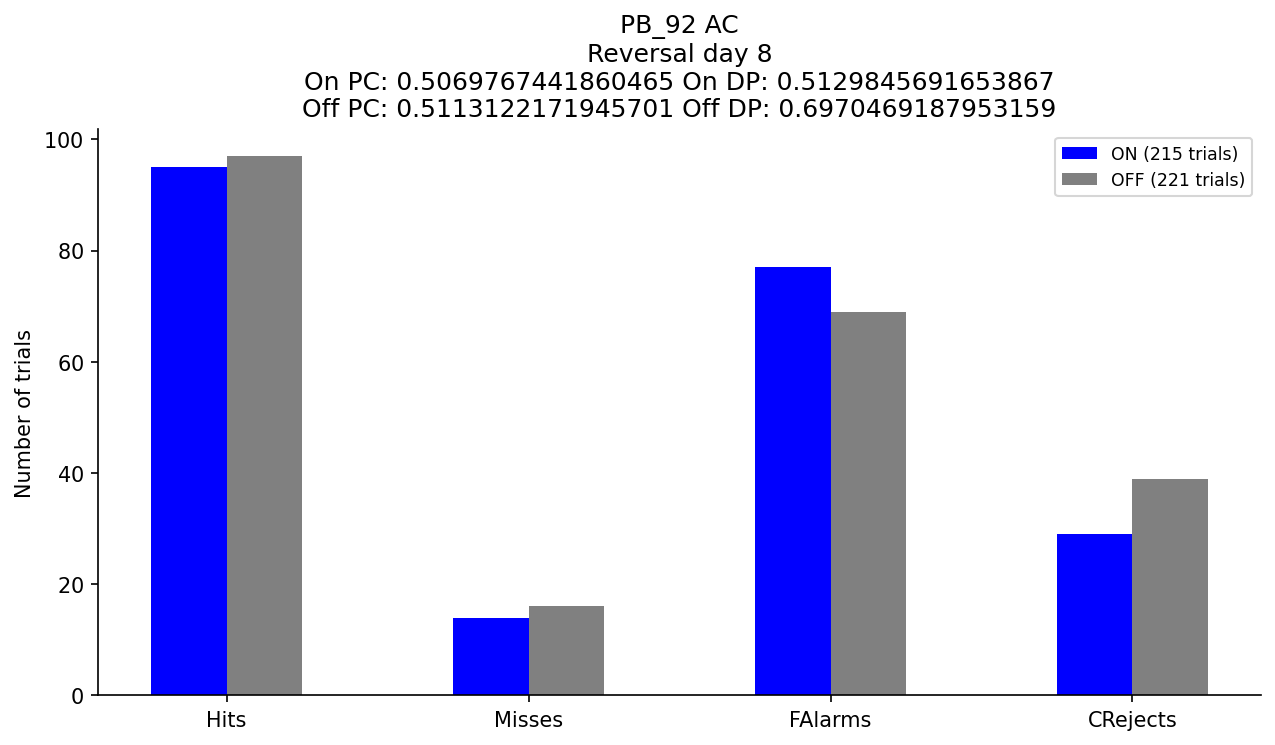

In [224]:
for session in tqdm(sessions):
    sessionfile = loadSessionCached(destination,session)
        
    laserON = sessionfile.trials.laser_stimulation
    laserOFF = np.logical_not(laserON)
    GoResponse = sessionfile.trials.go
    NogoResponse = np.logical_not(GoResponse)
    TargetTone = sessionfile.trials.target
    NontargetTone = np.logical_not(TargetTone)
    
    onTrials = np.sum(laserON)
    offTrials = np.sum(laserOFF)
        
    Hits = np.logical_and(TargetTone,GoResponse)
    Misses = np.logical_and(TargetTone,NogoResponse)
    FAlarms = np.logical_and(NontargetTone,GoResponse)
    CRejects = np.logical_and(NontargetTone,NogoResponse)
    Correct = np.logical_or(Hits,CRejects)
    Incorrect = np.logical_or(Misses,FAlarms)
        
    onHits = np.sum(np.logical_and(laserON,Hits))
    onMisses = np.sum(np.logical_and(laserON,Misses))
    onFalarms = np.sum(np.logical_and(laserON,FAlarms))
    onCrejects = np.sum(np.logical_and(laserON,CRejects))
        
    offHits = np.sum(np.logical_and(laserOFF,Hits))
    offMisses = np.sum(np.logical_and(laserOFF,Misses))
    offFalarms = np.sum(np.logical_and(laserOFF,FAlarms))
    offCrejects = np.sum(np.logical_and(laserOFF,CRejects))
    
    onpc = (onHits+onMisses) / (onHits+onMisses+onFalarms+onCrejects)
    offpc = (offHits+offMisses) / (offHits+offMisses+offFalarms+offCrejects)
    
    ondp = np.nan
    offdp = np.nan
    try:
        ondp = norm.ppf((onHits+1)/(onHits+onMisses+2)) - norm.ppf((onFalarms+1)/(onFalarms+onCrejects+2))
    except Exception:
        pass
    try:
        offdp = norm.ppf((offHits+1)/(offHits+offMisses+2)) - norm.ppf((offFalarms+1)/(offFalarms+offCrejects+2))
    except Exception:
        pass
        
    behavior = 'On PC: '+str(onpc)+' On DP: '+str(ondp)+'\nOff PC: '+str(offpc)+' Off DP: '+str(offdp)
        
    plt.close('all')
    fig,ax = plt.subplots(figsize=(10,5))
    ax.bar(np.array(range(4))-0.125,[onHits,onMisses,onFalarms,onCrejects],width=0.25,fc='blue',label='ON ('+str(onTrials)+' trials)')
    ax.bar(np.array(range(4))+0.125,[offHits,offMisses,offFalarms,offCrejects],width=0.25,fc='grey',label='OFF ('+str(offTrials)+' trials)')
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['Hits','Misses','FAlarms','CRejects'])
    ax.legend()
    ax.set_ylabel('Number of trials')
    if sessionfile.meta.task == 'opto reversal':
        sessiontitle = 'Reversal day '+str(sessionfile.meta.day_of_reversal)
    elif sessionfile.meta.task == 'opto switch':
        sessiontitle = 'Day of reversal'
    ax.set_title(sessionfile.meta.animal+' '+sessionfile.meta.region+'\n'+sessiontitle+'\n'+behavior)
    fig.savefig(os.path.join('D:\\\\Figures','OpsinSessionBehavior',session + '.png'),transparent=False,facecolor="white")

100%|██████████| 30/30 [00:00<00:00, 403.58it/s]


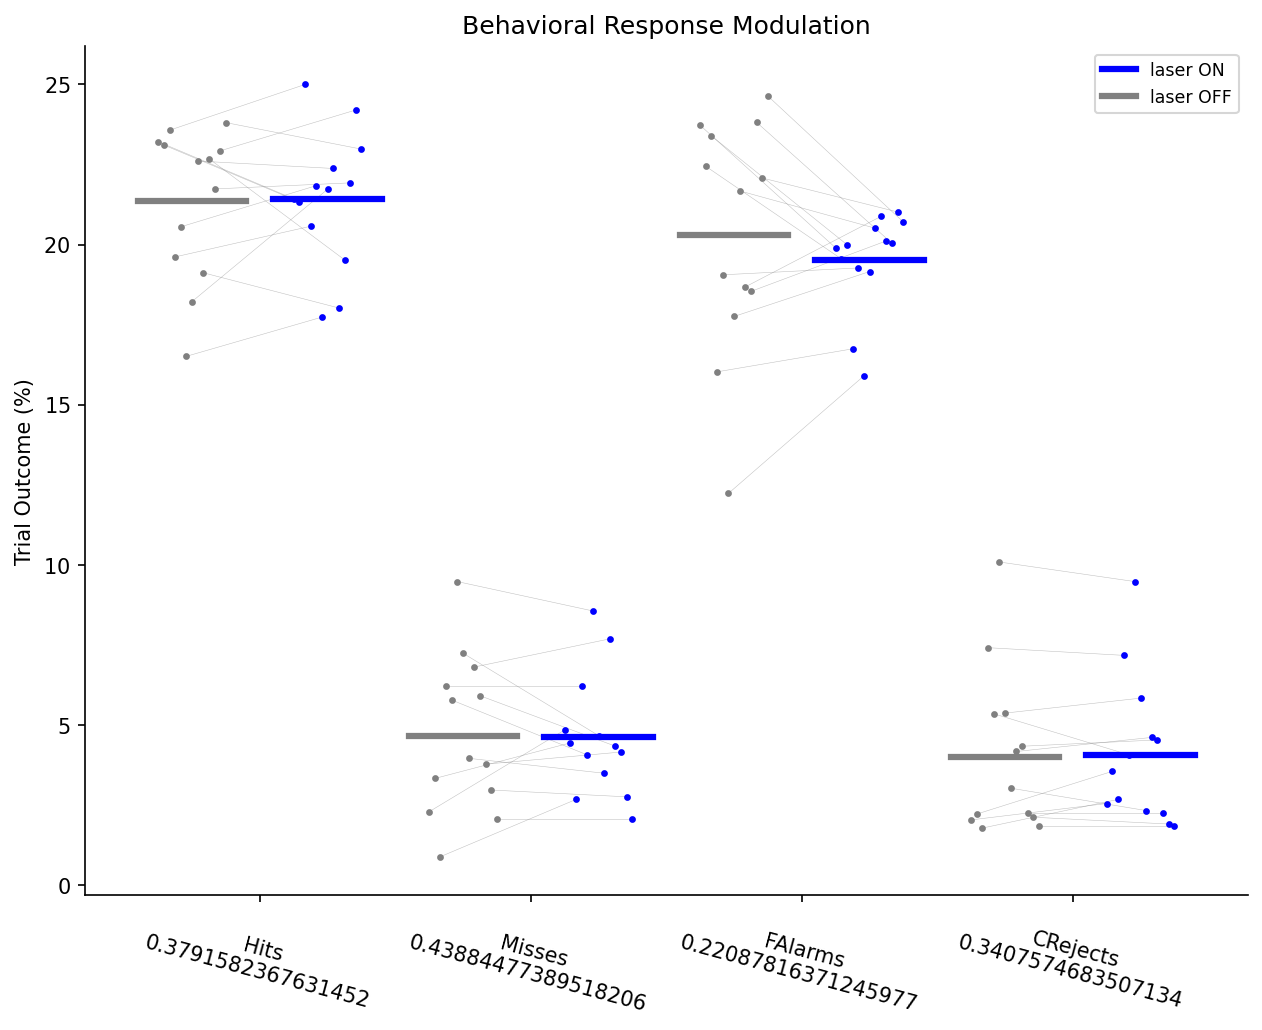

In [270]:
onHits = []
onMisses = []
onFalarms = []
onCrejects = []

offHits = []
offMisses = []
offFalarms = []
offCrejects = []

for session in tqdm(sessions):    
    sessionfile = loadSessionCached(destination,session)
    if sessionfile.meta.task == 'opto switch':
        continue
    if sessionfile.meta.cloudy:
        continue
        
    laserON = sessionfile.trials.laser_stimulation
    laserOFF = np.logical_not(laserON)
    GoResponse = sessionfile.trials.go
    NogoResponse = np.logical_not(GoResponse)
    TargetTone = sessionfile.trials.target
    NontargetTone = np.logical_not(TargetTone)
    
    onTrials = np.sum(laserON)
    offTrials = np.sum(laserOFF)
        
    Hits = np.logical_and(TargetTone,GoResponse)
    Misses = np.logical_and(TargetTone,NogoResponse)
    FAlarms = np.logical_and(NontargetTone,GoResponse)
    CRejects = np.logical_and(NontargetTone,NogoResponse)
    Correct = np.logical_or(Hits,CRejects)
    Incorrect = np.logical_or(Misses,FAlarms)
    
    percentconversion = 100/sessionfile.meta.length_in_trials
        
    onHits.append( np.sum(np.logical_and(laserON,Hits)) *percentconversion)
    onMisses.append( np.sum(np.logical_and(laserON,Misses)) *percentconversion)
    onFalarms.append( np.sum(np.logical_and(laserON,FAlarms)) *percentconversion)
    onCrejects.append( np.sum(np.logical_and(laserON,CRejects)) *percentconversion)
        
    offHits.append( np.sum(np.logical_and(laserOFF,Hits)) *percentconversion)
    offMisses.append( np.sum(np.logical_and(laserOFF,Misses)) *percentconversion)
    offFalarms.append( np.sum(np.logical_and(laserOFF,FAlarms)) *percentconversion)
    offCrejects.append( np.sum(np.logical_and(laserOFF,CRejects)) *percentconversion)

fig,ax = plt.subplots(figsize=(10,7.5))
width = 0.25
width2 = 0.4
            
#Hits
xrange1 = np.linspace(1-width,1+width,num=len(onHits))
xrange2 = np.linspace(0-width,0+width,num=len(offHits))    
ax.plot([xrange1,xrange2],[onHits,offHits],lw=0.25,color='grey',alpha=0.5,zorder=-10)
ax.scatter(xrange1,onHits,color='blue',s=size)
onmean = np.nanmean(onHits)
ax.plot([1-width2,1+width2],[onmean,onmean],color='blue',lw=3,label='laser ON')
ax.scatter(xrange2,offHits,color='grey',s=size)
offmean = np.nanmean(offHits)
ax.plot([0-width2,0+width2],[offmean,offmean],color='grey',lw=3,label='laser OFF')
hitpval = mannwhitneyu(onHits,offHits).pvalue
        
#Misses
xrange1 = np.linspace(3-width,3+width,num=len(onMisses))
xrange2 = np.linspace(2-width,2+width,num=len(offMisses))    
ax.plot([xrange1,xrange2],[onMisses,offMisses],lw=0.25,color='grey',alpha=0.5,zorder=-10)
ax.scatter(xrange1,onMisses,color='blue',s=size)
onmean = np.nanmean(onMisses)
ax.plot([3-width2,3+width2],[onmean,onmean],color='blue',lw=3)
ax.scatter(xrange2,offMisses,color='grey',s=size)
offmean = np.nanmean(offMisses)
ax.plot([2-width2,2+width2],[offmean,offmean],color='grey',lw=3)
misspval = mannwhitneyu(onMisses,offMisses).pvalue
        
#Hits
xrange1 = np.linspace(5-width,5+width,num=len(onFalarms))
xrange2 = np.linspace(4-width,4+width,num=len(offFalarms))    
ax.plot([xrange1,xrange2],[onFalarms,offFalarms],lw=0.25,color='grey',alpha=0.5,zorder=-10)
ax.scatter(xrange1,onFalarms,color='blue',s=size)
onmean = np.nanmean(onFalarms)
ax.plot([5-width2,5+width2],[onmean,onmean],color='blue',lw=3)
ax.scatter(xrange2,offFalarms,color='grey',s=size)
offmean = np.nanmean(offFalarms)
ax.plot([4-width2,4+width2],[offmean,offmean],color='grey',lw=3)
falarmpval = mannwhitneyu(onFalarms,offFalarms).pvalue
        
#Hits
xrange1 = np.linspace(7-width,7+width,num=len(onCrejects))
xrange2 = np.linspace(6-width,6+width,num=len(offCrejects))    
ax.plot([xrange1,xrange2],[onCrejects,offCrejects],lw=0.25,color='grey',alpha=0.5,zorder=-10)
ax.scatter(xrange1,onCrejects,color='blue',s=size)
onmean = np.nanmean(onCrejects)
ax.plot([7-width2,7+width2],[onmean,onmean],color='blue',lw=3)
ax.scatter(xrange2,offCrejects,color='grey',s=size)
offmean = np.nanmean(offCrejects)
ax.plot([6-width2,6+width2],[offmean,offmean],color='grey',lw=3)
crejectpval = mannwhitneyu(onCrejects,offCrejects).pvalue
        
ax.set_xticks([0.5,2.5,4.5,6.5])
ax.set_xticklabels(['Hits\n'+str(hitpval),'Misses\n'+str(misspval),'FAlarms\n'+str(falarmpval),'CRejects\n'+str(crejectpval)],rotation=-15)
ax.set_ylabel('Trial Outcome (%)')
ax.legend()
ax.set_title('Behavioral Response Modulation')
fig.savefig(os.path.join('D:\\\\Figures','BehavioralResponseModulation.png'),transparent=False,facecolor="white")

100%|██████████| 30/30 [00:00<00:00, 439.20it/s]


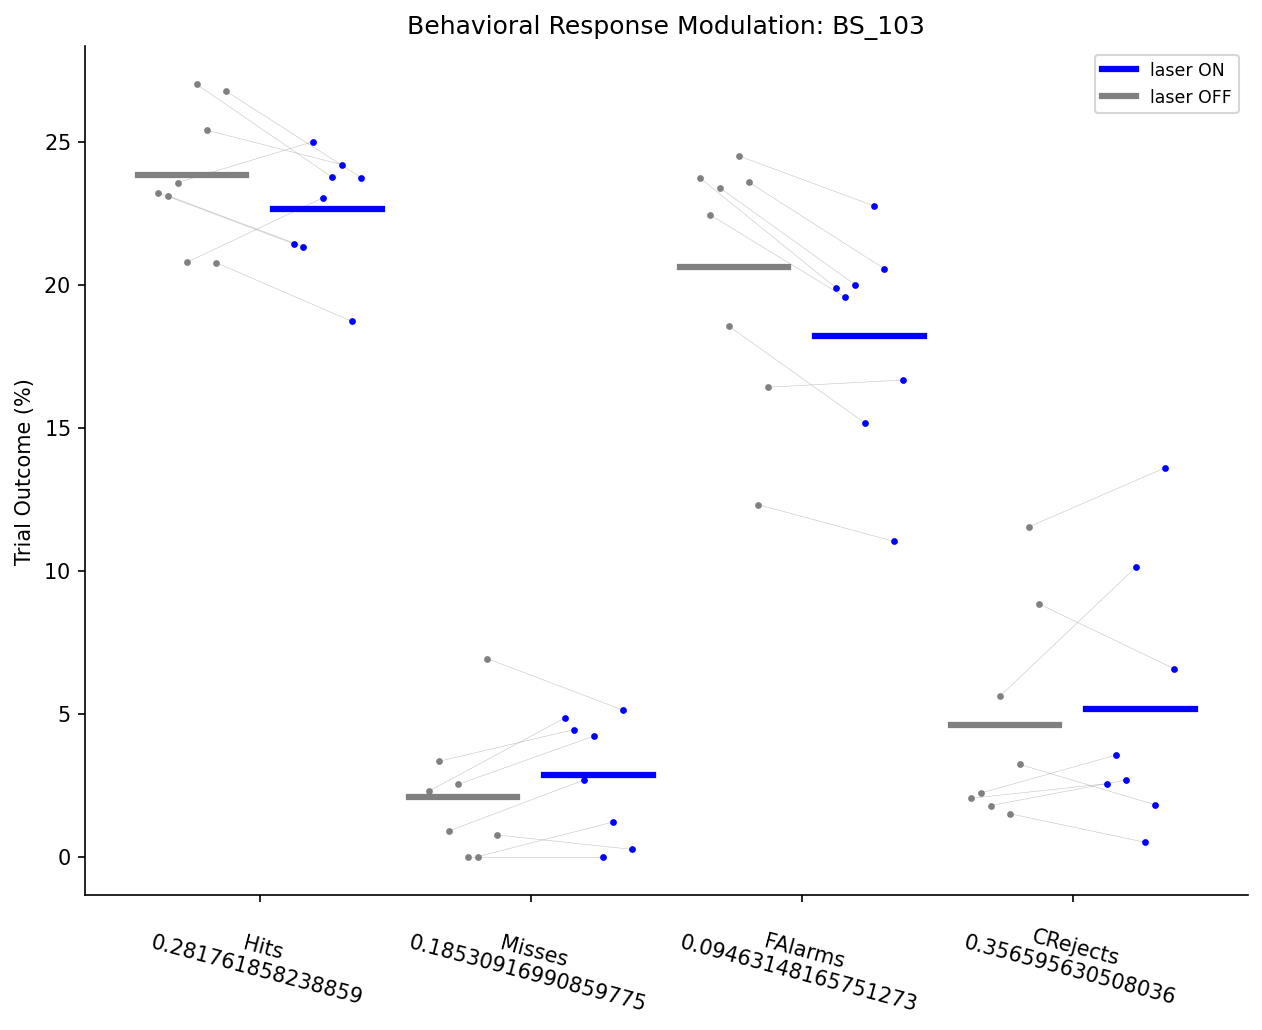

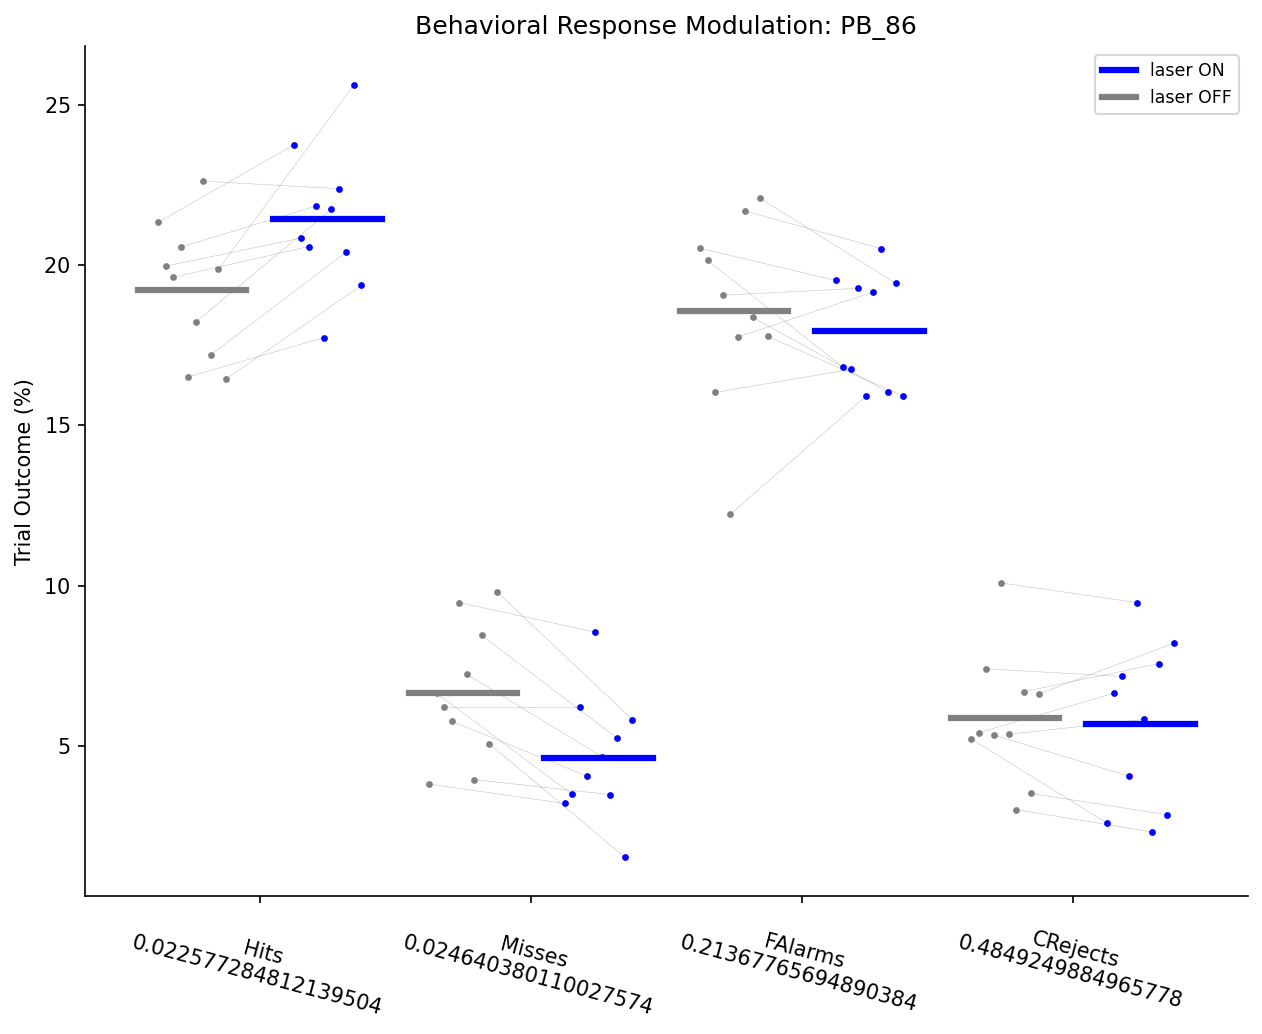

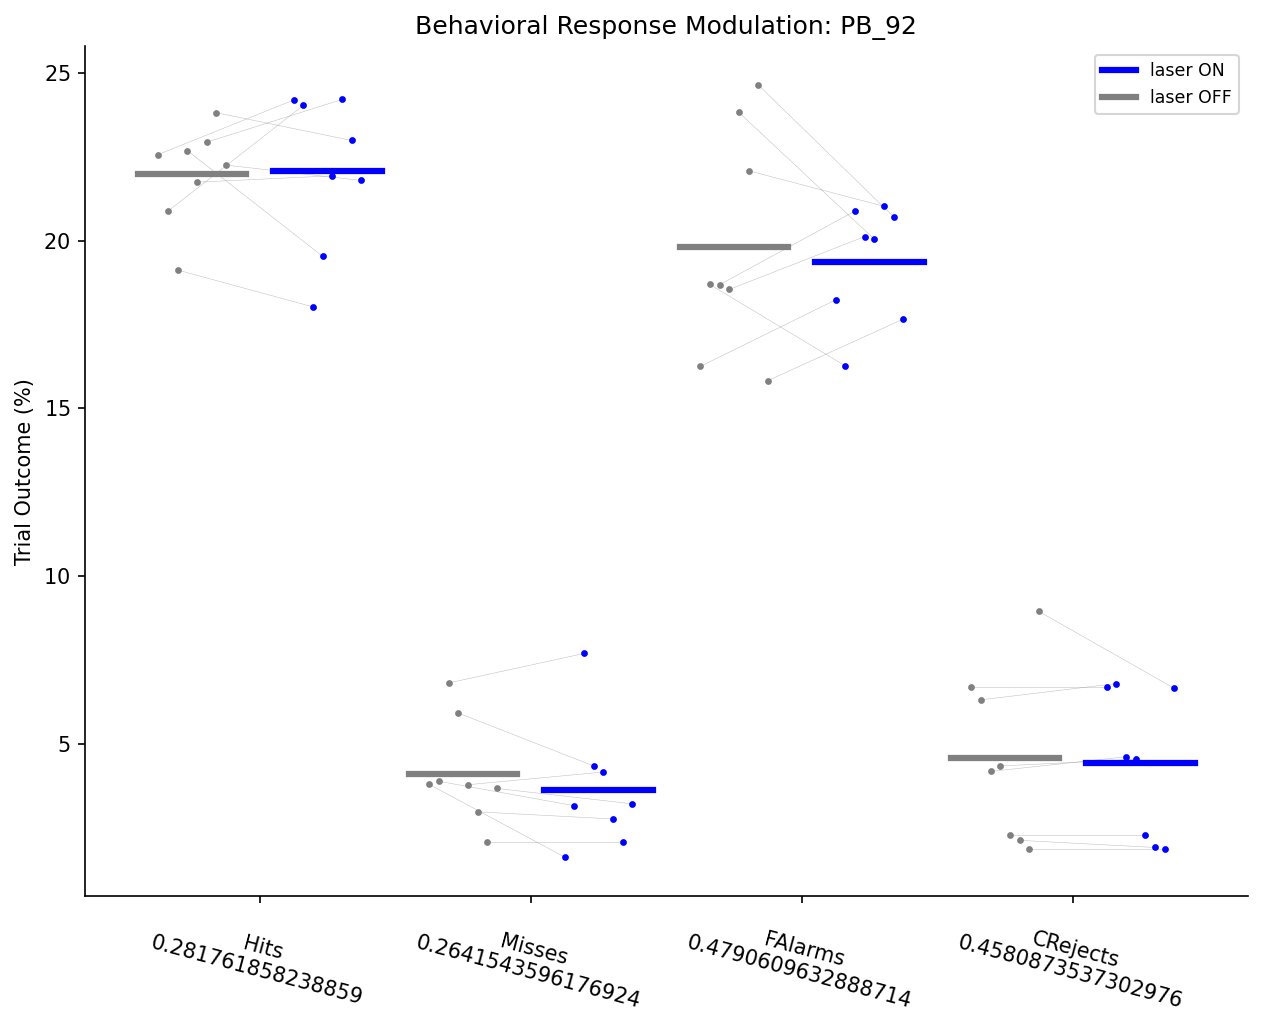

In [352]:
targetanimals = ['BS_103','PB_86','PB_92']

for targetanimal in targetanimals:
    onHits = []
    onMisses = []
    onFalarms = []
    onCrejects = []

    offHits = []
    offMisses = []
    offFalarms = []
    offCrejects = []

    for session in tqdm(sessions):
        sessionfile = loadSessionCached(destination,session)
        if sessionfile.meta.task == 'opto switch':
            continue
        if sessionfile.meta.animal != targetanimal:
            continue
        #if sessionfile.meta.cloudy:
        #    continue

        laserON = sessionfile.trials.laser_stimulation
        laserOFF = np.logical_not(laserON)
        GoResponse = sessionfile.trials.go
        NogoResponse = np.logical_not(GoResponse)
        TargetTone = sessionfile.trials.target
        NontargetTone = np.logical_not(TargetTone)

        onTrials = np.sum(laserON)
        offTrials = np.sum(laserOFF)

        Hits = np.logical_and(TargetTone,GoResponse)
        Misses = np.logical_and(TargetTone,NogoResponse)
        FAlarms = np.logical_and(NontargetTone,GoResponse)
        CRejects = np.logical_and(NontargetTone,NogoResponse)
        Correct = np.logical_or(Hits,CRejects)
        Incorrect = np.logical_or(Misses,FAlarms)

        percentconversion = 100/sessionfile.meta.length_in_trials

        onHits.append( np.sum(np.logical_and(laserON,Hits)) *percentconversion)
        onMisses.append( np.sum(np.logical_and(laserON,Misses)) *percentconversion)
        onFalarms.append( np.sum(np.logical_and(laserON,FAlarms)) *percentconversion)
        onCrejects.append( np.sum(np.logical_and(laserON,CRejects)) *percentconversion)

        offHits.append( np.sum(np.logical_and(laserOFF,Hits)) *percentconversion)
        offMisses.append( np.sum(np.logical_and(laserOFF,Misses)) *percentconversion)
        offFalarms.append( np.sum(np.logical_and(laserOFF,FAlarms)) *percentconversion)
        offCrejects.append( np.sum(np.logical_and(laserOFF,CRejects)) *percentconversion)

    fig,ax = plt.subplots(figsize=(10,7.5))
    width = 0.25
    width2 = 0.4

    #Hits
    xrange1 = np.linspace(1-width,1+width,num=len(onHits))
    xrange2 = np.linspace(0-width,0+width,num=len(offHits))    
    ax.plot([xrange1,xrange2],[onHits,offHits],lw=0.25,color='grey',alpha=0.5,zorder=-10)
    ax.scatter(xrange1,onHits,color='blue',s=size)
    onmean = np.nanmean(onHits)
    ax.plot([1-width2,1+width2],[onmean,onmean],color='blue',lw=3,label='laser ON')
    ax.scatter(xrange2,offHits,color='grey',s=size)
    offmean = np.nanmean(offHits)
    ax.plot([0-width2,0+width2],[offmean,offmean],color='grey',lw=3,label='laser OFF')
    hitpval = mannwhitneyu(onHits,offHits).pvalue

    #Misses
    xrange1 = np.linspace(3-width,3+width,num=len(onMisses))
    xrange2 = np.linspace(2-width,2+width,num=len(offMisses))    
    ax.plot([xrange1,xrange2],[onMisses,offMisses],lw=0.25,color='grey',alpha=0.5,zorder=-10)
    ax.scatter(xrange1,onMisses,color='blue',s=size)
    onmean = np.nanmean(onMisses)
    ax.plot([3-width2,3+width2],[onmean,onmean],color='blue',lw=3)
    ax.scatter(xrange2,offMisses,color='grey',s=size)
    offmean = np.nanmean(offMisses)
    ax.plot([2-width2,2+width2],[offmean,offmean],color='grey',lw=3)
    misspval = mannwhitneyu(onMisses,offMisses).pvalue

    #Hits
    xrange1 = np.linspace(5-width,5+width,num=len(onFalarms))
    xrange2 = np.linspace(4-width,4+width,num=len(offFalarms))    
    ax.plot([xrange1,xrange2],[onFalarms,offFalarms],lw=0.25,color='grey',alpha=0.5,zorder=-10)
    ax.scatter(xrange1,onFalarms,color='blue',s=size)
    onmean = np.nanmean(onFalarms)
    ax.plot([5-width2,5+width2],[onmean,onmean],color='blue',lw=3)
    ax.scatter(xrange2,offFalarms,color='grey',s=size)
    offmean = np.nanmean(offFalarms)
    ax.plot([4-width2,4+width2],[offmean,offmean],color='grey',lw=3)
    falarmpval = mannwhitneyu(onFalarms,offFalarms).pvalue

    #Hits
    xrange1 = np.linspace(7-width,7+width,num=len(onCrejects))
    xrange2 = np.linspace(6-width,6+width,num=len(offCrejects))    
    ax.plot([xrange1,xrange2],[onCrejects,offCrejects],lw=0.25,color='grey',alpha=0.5,zorder=-10)
    ax.scatter(xrange1,onCrejects,color='blue',s=size)
    onmean = np.nanmean(onCrejects)
    ax.plot([7-width2,7+width2],[onmean,onmean],color='blue',lw=3)
    ax.scatter(xrange2,offCrejects,color='grey',s=size)
    offmean = np.nanmean(offCrejects)
    ax.plot([6-width2,6+width2],[offmean,offmean],color='grey',lw=3)
    crejectpval = mannwhitneyu(onCrejects,offCrejects).pvalue

    ax.set_xticks([0.5,2.5,4.5,6.5])
    ax.set_xticklabels(['Hits\n'+str(hitpval),'Misses\n'+str(misspval),'FAlarms\n'+str(falarmpval),'CRejects\n'+str(crejectpval)],rotation=-15)
    ax.set_ylabel('Trial Outcome (%)')
    ax.legend()
    ax.set_title('Behavioral Response Modulation: '+str(targetanimal))
    fig.savefig(os.path.join('D:\\\\Figures','BehavioralResponseModulationByAnimal','BehavioralResponseModulation'+targetanimal+'.png'),transparent=False,facecolor="white")

100%|██████████| 30/30 [00:00<00:00, 416.56it/s]


n = 10
Mean PC-ON: 54.58481456994279
Mean PC-OFF: 49.932622047242184
p = 0.00364227850473983

n = 10
Mean dp-ON: 0.20052744453613974
Mean dp-OFF: -0.04602409263050017
p = 0.012874040410554032
n = 8
Mean PC-ON: 53.524376403777
Mean PC-OFF: 52.660430081490894
p = 0.4167571064766576

n = 8
Mean dp-ON: 0.16250079098302303
Mean dp-OFF: 0.08805360838040686
p = 0.31825124345693306


100%|██████████| 30/30 [00:00<00:00, 416.56it/s]


n = 8
Mean PC-ON: 56.88172599614093
Mean PC-OFF: 55.53373861612669
p = 0.3964477515894803

n = 8
Mean dp-ON: 0.4478123857618449
Mean dp-OFF: 0.586187737494515
p = 0.31825124345693306


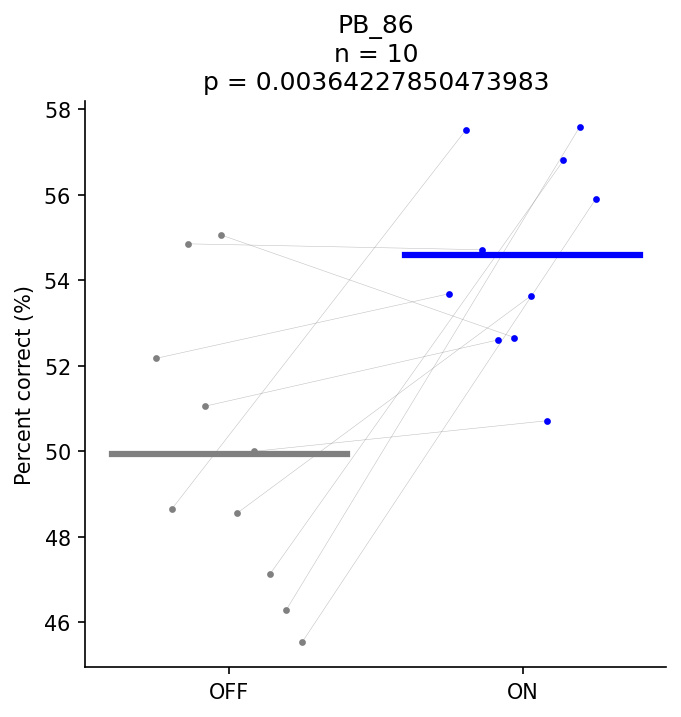

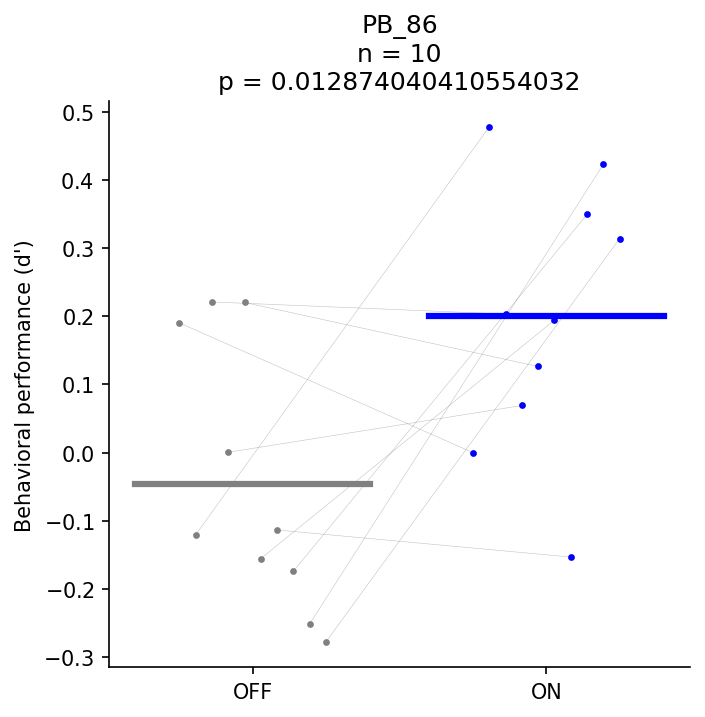

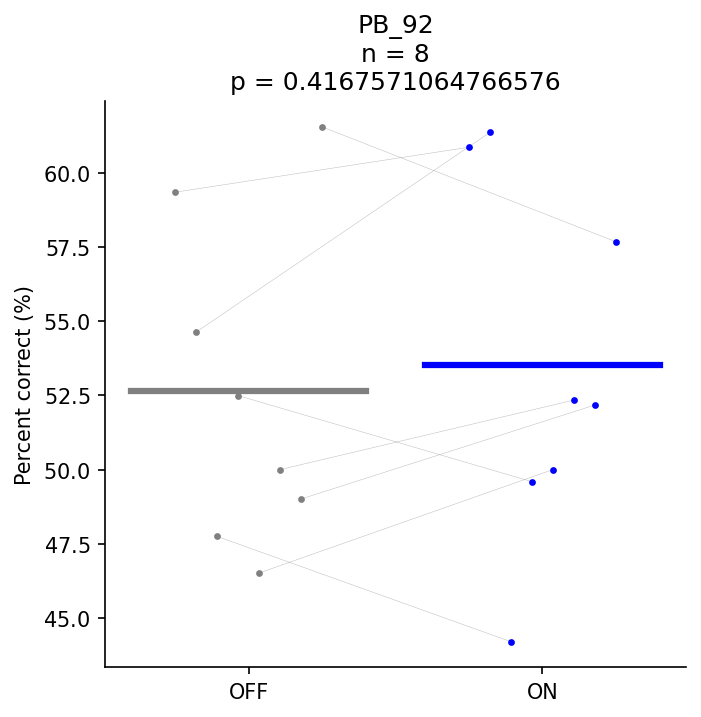

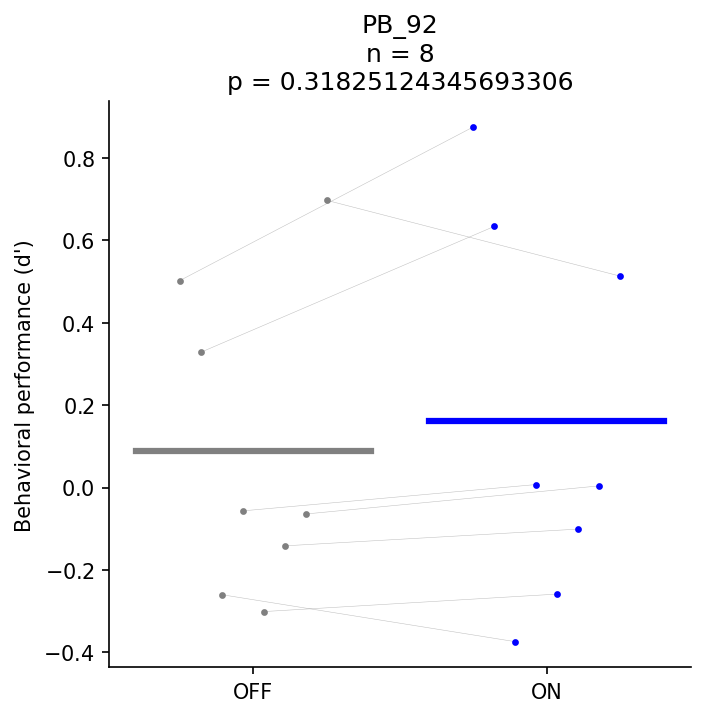

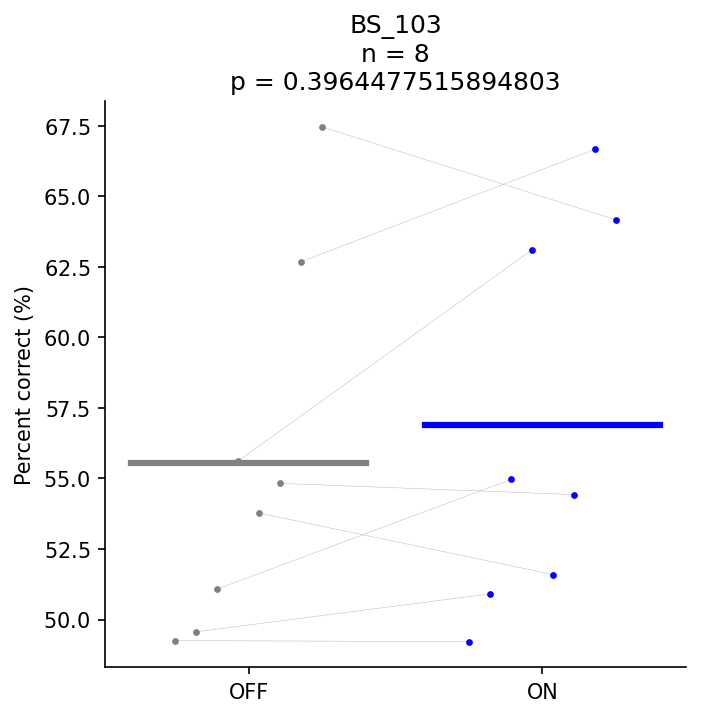

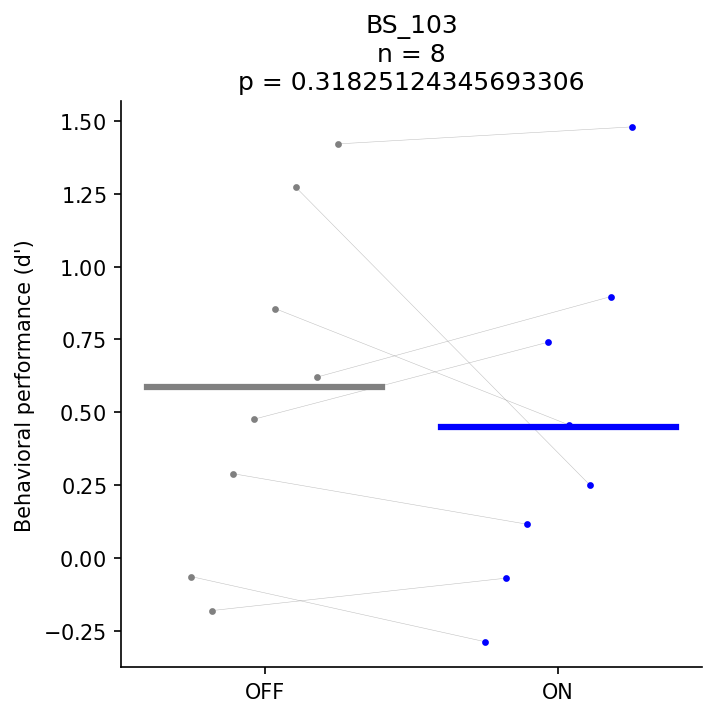

In [282]:
for targetanimal in ['PB_86','PB_92','BS_103']:
    
    pcON = []
    pcOFF = []
    dpON = []
    dpOFF = []

    for session in tqdm(sessions):
        sessionfile = loadSessionCached(destination,session)
        if sessionfile.meta.task == 'opto switch':
            continue
        if sessionfile.meta.animal != targetanimal:
            continue
        #if sessionfile.meta.cloudy:
        #    continue

        laserON = sessionfile.trials.laser_stimulation
        laserOFF = np.logical_not(laserON)
        GoResponse = sessionfile.trials.go
        NogoResponse = np.logical_not(GoResponse)
        TargetTone = sessionfile.trials.target
        NontargetTone = np.logical_not(TargetTone)

        onTrials = np.sum(laserON)
        offTrials = np.sum(laserOFF)

        Hits = np.logical_and(TargetTone,GoResponse)
        Misses = np.logical_and(TargetTone,NogoResponse)
        FAlarms = np.logical_and(NontargetTone,GoResponse)
        CRejects = np.logical_and(NontargetTone,NogoResponse)
        Correct = np.logical_or(Hits,CRejects)
        Incorrect = np.logical_or(Misses,FAlarms)

        onHits = np.sum(np.logical_and(laserON,Hits))
        onMisses = np.sum(np.logical_and(laserON,Misses))
        onFalarms = np.sum(np.logical_and(laserON,FAlarms))
        onCrejects = np.sum(np.logical_and(laserON,CRejects))

        offHits = np.sum(np.logical_and(laserOFF,Hits))
        offMisses = np.sum(np.logical_and(laserOFF,Misses))
        offFalarms = np.sum(np.logical_and(laserOFF,FAlarms))
        offCrejects = np.sum(np.logical_and(laserOFF,CRejects))
        
        pcON.append( (onHits+onCrejects)/(onHits+onMisses+onFalarms+onCrejects) * 100)
        pcOFF.append( (offHits+offCrejects)/(offHits+offMisses+offFalarms+offCrejects) * 100)
        
        try:
            dpON.append( norm.ppf((onHits+1)/(onHits+onMisses+2)) - norm.ppf((onFalarms+1)/(onFalarms+onCrejects+2)) )
            dpOFF.append( norm.ppf((offHits+1)/(offHits+offMisses+2)) - norm.ppf((offFalarms+1)/(offFalarms+offCrejects+2)) )
        except:
            pass
        
    print('n = '+str(len(pcON)))
    print('Mean PC-ON: '+str(np.mean(pcON)))
    print('Mean PC-OFF: '+str(np.mean(pcOFF)))
    print('p = '+str(mannwhitneyu(pcON,pcOFF).pvalue))
    
    print('')
    
    print('n = '+str(len(dpON)))
    print('Mean dp-ON: '+str(np.mean(dpON)))
    print('Mean dp-OFF: '+str(np.mean(dpOFF)))
    print('p = '+str(mannwhitneyu(dpON,dpOFF).pvalue))
    
    fig,ax = plt.subplots(figsize=(5,5))
    width = 0.25
    width2 = 0.4

    xrange1 = np.linspace(1-width,1+width,num=len(pcON))
    xrange2 = np.linspace(0-width,0+width,num=len(pcOFF))    
    ax.plot([xrange1,xrange2],[pcON,pcOFF],lw=0.25,color='grey',alpha=0.5,zorder=-10)
    ax.scatter(xrange1,pcON,color='blue',s=size)
    onmean = np.nanmean(pcON)
    ax.plot([1-width2,1+width2],[onmean,onmean],color='blue',lw=3,label='laser ON')
    ax.scatter(xrange2,pcOFF,color='grey',s=size)
    offmean = np.nanmean(pcOFF)
    ax.plot([0-width2,0+width2],[offmean,offmean],color='grey',lw=3,label='laser OFF')
    PCpval = mannwhitneyu(pcON,pcOFF).pvalue
    
    ax.set_xticks([0,1])
    ax.set_xticklabels(['OFF','ON'])
    ax.set_ylabel('Percent correct (%)')
    ax.set_title(targetanimal+'\nn = '+str(len(pcON))+'\np = '+str(PCpval))
    
    fig,ax = plt.subplots(figsize=(5,5))
    width = 0.25
    width2 = 0.4

    xrange1 = np.linspace(1-width,1+width,num=len(dpON))
    xrange2 = np.linspace(0-width,0+width,num=len(dpOFF))    
    ax.plot([xrange1,xrange2],[dpON,dpOFF],lw=0.25,color='grey',alpha=0.5,zorder=-10)
    ax.scatter(xrange1,dpON,color='blue',s=size)
    onmean = np.nanmean(dpON)
    ax.plot([1-width2,1+width2],[onmean,onmean],color='blue',lw=3,label='laser ON')
    ax.scatter(xrange2,dpOFF,color='grey',s=size)
    offmean = np.nanmean(dpOFF)
    ax.plot([0-width2,0+width2],[offmean,offmean],color='grey',lw=3,label='laser OFF')
    DPpval = mannwhitneyu(dpON,dpOFF).pvalue
    
    ax.set_xticks([0,1])
    ax.set_xticklabels(['OFF','ON'])
    ax.set_ylabel('Behavioral performance (d\')')
    ax.set_title(targetanimal+'\nn = '+str(len(dpON))+'\np = '+str(DPpval))

100%|██████████| 30/30 [00:00<00:00, 441.06it/s]
<ipython-input-355-7b61b3165471>:94: RuntimeWarning: Mean of empty slice
  offmean = np.nanmean(pcOFF[day,:])
<ipython-input-355-7b61b3165471>:99: RuntimeWarning: Mean of empty slice
  onmean = np.nanmean(pcON[day,:])
<ipython-input-355-7b61b3165471>:132: RuntimeWarning: Mean of empty slice
  offmean = np.nanmean(dpOFF[day,:])
<ipython-input-355-7b61b3165471>:137: RuntimeWarning: Mean of empty slice
  onmean = np.nanmean(dpON[day,:])


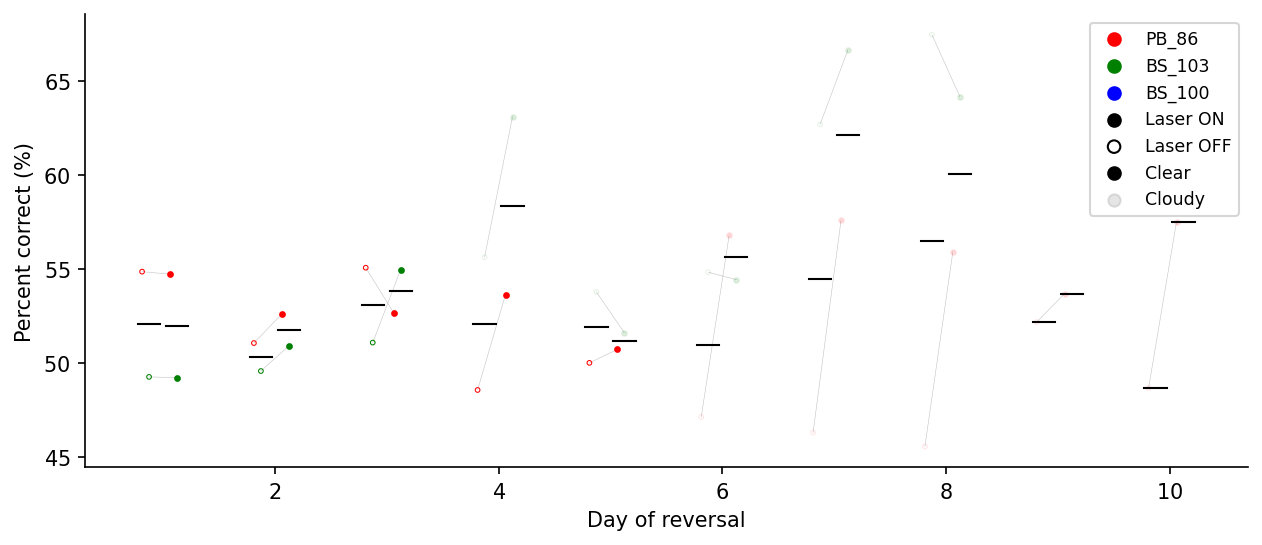

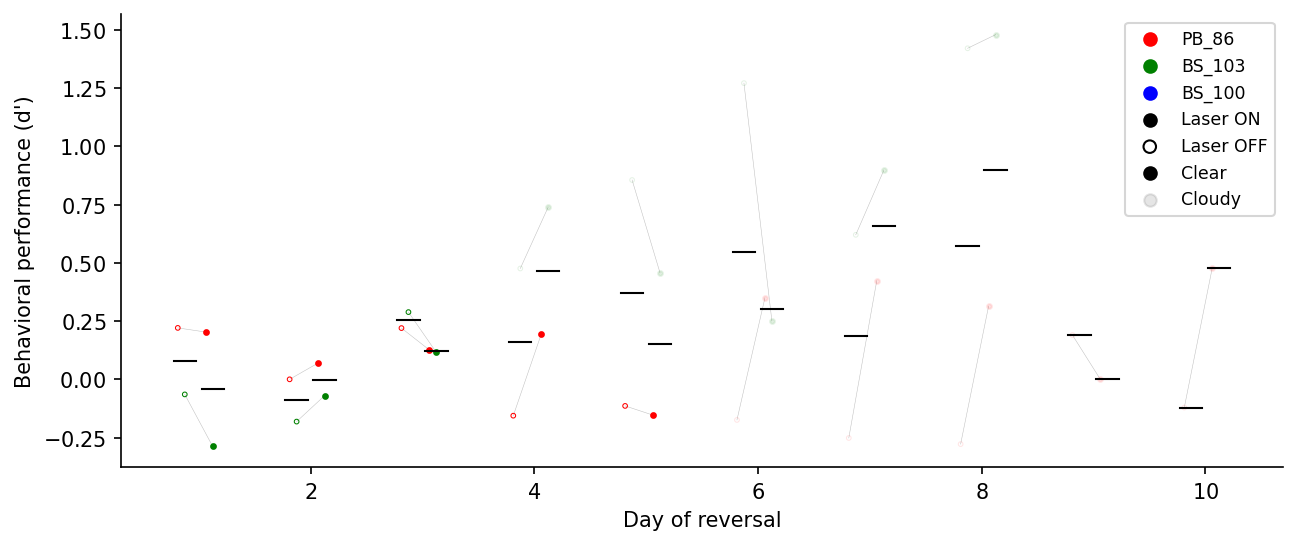

In [355]:
daystoplot = 0
for session in tqdm(sessions):
    sessionfile = loadSessionCached(destination,session)
    if sessionfile.meta.task == 'opto switch':
            continue
    if sessionfile.meta.day_of_reversal > daystoplot:
        daystoplot = sessionfile.meta.day_of_reversal

animals = ['PB_86','BS_103','BS_100']
colors = ['red','green','blue']

pcON = np.zeros((daystoplot,3))
pcOFF = np.zeros((daystoplot,3))
dpON = np.zeros((daystoplot,3))
dpOFF = np.zeros((daystoplot,3))
cloudy = np.zeros((daystoplot,3))

pcON.fill(np.nan)
pcOFF.fill(np.nan)
dpON.fill(np.nan)
dpOFF.fill(np.nan)
cloudy.fill(np.nan)

for day in range(daystoplot):
    for session in tqdm(sessions):
        sessionfile = loadSessionCached(destination,session)
        
        if sessionfile.meta.task == 'opto switch':
            continue
        if sessionfile.meta.day_of_reversal != day:
            continue
        #if sessionfile.meta.cloudy:
        #    continue
        if not sessionfile.meta.animal in animals:
            continue

        laserON = sessionfile.trials.laser_stimulation
        laserOFF = np.logical_not(laserON)
        GoResponse = sessionfile.trials.go
        NogoResponse = np.logical_not(GoResponse)
        TargetTone = sessionfile.trials.target
        NontargetTone = np.logical_not(TargetTone)

        onTrials = np.sum(laserON)
        offTrials = np.sum(laserOFF)

        Hits = np.logical_and(TargetTone,GoResponse)
        Misses = np.logical_and(TargetTone,NogoResponse)
        FAlarms = np.logical_and(NontargetTone,GoResponse)
        CRejects = np.logical_and(NontargetTone,NogoResponse)
        Correct = np.logical_or(Hits,CRejects)
        Incorrect = np.logical_or(Misses,FAlarms)

        onHits = np.sum(np.logical_and(laserON,Hits))
        onMisses = np.sum(np.logical_and(laserON,Misses))
        onFalarms = np.sum(np.logical_and(laserON,FAlarms))
        onCrejects = np.sum(np.logical_and(laserON,CRejects))

        offHits = np.sum(np.logical_and(laserOFF,Hits))
        offMisses = np.sum(np.logical_and(laserOFF,Misses))
        offFalarms = np.sum(np.logical_and(laserOFF,FAlarms))
        offCrejects = np.sum(np.logical_and(laserOFF,CRejects))
        
        animal = animals.index(sessionfile.meta.animal)
        
        pcON[day,animal] = (onHits+onCrejects)/(onHits+onMisses+onFalarms+onCrejects) * 100
        pcOFF[day,animal] = (offHits+offCrejects)/(offHits+offMisses+offFalarms+offCrejects) * 100
        
        try:
            dpON[day,animal] = norm.ppf((onHits+1)/(onHits+onMisses+2)) - norm.ppf((onFalarms+1)/(onFalarms+onCrejects+2))
            dpOFF[day,animal] = norm.ppf((offHits+1)/(offHits+offMisses+2)) - norm.ppf((offFalarms+1)/(offFalarms+offCrejects+2))
        except:
            dpON[day,animal] = np.nan
            dpOFF[day,animal] = np.nan
            
        if sessionfile.meta.cloudy:
            cloudy[day,animal] = 0.1
        else:
            cloudy[day,animal] = 1
                
fig,ax = plt.subplots(figsize=(10,4))
width = 0.125/2
width2 = 0.2/2
spread = 0.125

for day in range(daystoplot):
    xrange1 = np.linspace(day-spread-width,day-spread+width,num=len(pcOFF[day,:]))
    xrange2 = np.linspace(day+spread-width,day+spread+width,num=len(pcON[day,:]))    
    
    ax.plot([xrange1,xrange2],[pcOFF[day,:],pcON[day,:]],lw=0.25,color='grey',alpha=0.5,zorder=-10)
    
    for idx in range(len(animals)):
        ax.scatter(xrange1[idx],pcOFF[day,idx],color=colors[idx],s=size,alpha=cloudy[day,idx],facecolor='None',lw=0.5)
    offmean = np.nanmean(pcOFF[day,:])
    ax.plot([day-spread-width2,day-spread+width2],[offmean,offmean],color='black',lw=1)
    
    for idx in range(len(animals)):
        ax.scatter(xrange2[idx],pcON[day,idx],color=colors[idx],s=size,alpha=cloudy[day,idx])
    onmean = np.nanmean(pcON[day,:])
    ax.plot([day+spread-width2,day+spread+width2],[onmean,onmean],color='black',lw=1)
    
for idx in range(len(animals)):
    ax.scatter(np.nan,np.nan,color=colors[idx],label=animals[idx])
ax.scatter(np.nan,np.nan,color='black',label='Laser ON')
ax.scatter(np.nan,np.nan,color='black',facecolor='None',label='Laser OFF')
ax.scatter(np.nan,np.nan,color='black',label='Clear')
ax.scatter(np.nan,np.nan,color='black',label='Cloudy',alpha=0.1)
ax.legend()

ax.set_xlabel('Day of reversal')
ax.set_ylabel('Percent correct (%)')
fig.savefig(os.path.join('D:\\\\Figures','OptoBehaviorOverLearningPC.png'),transparent=False,facecolor="white")






fig,ax = plt.subplots(figsize=(10,4))
width = 0.125/2
width2 = 0.2/2
spread = 0.125

for day in range(daystoplot):
    xrange1 = np.linspace(day-spread-width,day-spread+width,num=len(pcOFF[day,:]))
    xrange2 = np.linspace(day+spread-width,day+spread+width,num=len(pcON[day,:]))    
    
    ax.plot([xrange1,xrange2],[dpOFF[day,:],dpON[day,:]],lw=0.25,color='grey',alpha=0.5,zorder=-10)
    
    for idx in range(len(animals)):
        ax.scatter(xrange1[idx],dpOFF[day,idx],color=colors[idx],s=size,alpha=cloudy[day,idx],facecolor='None',lw=0.5)
    offmean = np.nanmean(dpOFF[day,:])
    ax.plot([day-spread-width2,day-spread+width2],[offmean,offmean],color='black',lw=1)
    
    for idx in range(len(animals)):
        ax.scatter(xrange2[idx],dpON[day,idx],color=colors[idx],s=size,alpha=cloudy[day,idx])
    onmean = np.nanmean(dpON[day,:])
    ax.plot([day+spread-width2,day+spread+width2],[onmean,onmean],color='black',lw=1)
    
for idx in range(len(animals)):
    ax.scatter(np.nan,np.nan,color=colors[idx],label=animals[idx])
ax.scatter(np.nan,np.nan,color='black',label='Laser ON')
ax.scatter(np.nan,np.nan,color='black',facecolor='None',label='Laser OFF')
ax.scatter(np.nan,np.nan,color='black',label='Clear')
ax.scatter(np.nan,np.nan,color='black',label='Cloudy',alpha=0.1)
ax.legend()

ax.set_xlabel('Day of reversal')
ax.set_ylabel('Behavioral performance (d\')')
fig.savefig(os.path.join('D:\\\\Figures','OptoBehaviorOverLearningDP.png'),transparent=False,facecolor="white")

In [394]:
def plot_FR_modulations_violin(sessions,condition,region):
    FRmods = []
    labels = []
    
    #Create list of FR modulations
    for session in tqdm(sessions):
        sessionfile = loadSessionCached(destination,session)
        if sessionfile.meta.condition == condition and sessionfile.meta.region == region:
            #goodneurons = sessionfile.clusters.good
            goodneurons = np.concatenate((sessionfile.clusters.good,sessionfile.clusters.disqualified))
            for neuron in goodneurons:
                
                baselineratio = (sessionfile.clusters.resp.overall.baselinestds[neuron]/sessionfile.clusters.resp.overall.baselines[neuron])
                if not np.isnan(sessionfile.clusters.resp.overall.FRmods[neuron]):# and baselineratio <= 4:
                    FRmods.append(sessionfile.clusters.resp.overall.FRmods[neuron])
                    if sessionfile.clusters.resp.overall.labels[neuron]=='evoked' or sessionfile.clusters.resp.overall.labels[neuron]=='suppressed':
                        labels.append(1)
                    elif sessionfile.clusters.resp.overall.labels[neuron]=='NCR':
                        labels.append(0)
                    else:
                        labels.append(np.nan)
    FRmods = np.abs(FRmods)
    #print(FRmods)
    #print(labels)
                        
    kde_w = gaussian_kde(FRmods)
    x_rand = 0.075 * kde_w(FRmods) * (np.random.rand(len(FRmods)) -.5)
    
    trans=1
    sz=1
    fig,ax = plt.subplots(figsize=(3,5))
    for idx in range(len(FRmods)):
        if labels[idx]==1:
            ax.scatter(x_rand[idx],FRmods[idx],c=CR_COLOR,s=sz,alpha=trans)
        elif labels[idx]==0:
            ax.scatter(x_rand[idx],FRmods[idx],c=NCR_COLOR,s=sz,alpha=trans)
        else:
            ax.scatter(x_rand[idx],FRmods[idx],c='green',s=sz,alpha=trans)
    ax.set_ylim([0, 10])
    ax.set_xticks([])
    ax.set_title(region+' '+condition)
    plt.tight_layout()
    fig.savefig(os.path.join('D:\\\\Figures\\FRmodulations\\'+region+' '+condition+' violin.png'),transparent=False,facecolor="white")
                
#plot_FR_modulations_violin(sessions,'prereversal naive','AC')
#plot_FR_modulations_violin(sessions,'prereversal expert','AC')
#plot_FR_modulations_violin(sessions,'postreversal naive','AC')
#plot_FR_modulations_violin(sessions,'postreversal expert','AC')

In [395]:
#plot_FR_modulations_violin(sessions,'prereversal naive','M2')
#plot_FR_modulations_violin(sessions,'prereversal expert','M2')
#plot_FR_modulations_violin(sessions,'postreversal naive','M2')
#plot_FR_modulations_violin(sessions,'postreversal expert','M2')

# Summary Analysis

In [180]:
animal = []
region = []
probe = []
day_of_training = []
learningcondition = []
ID = []

pc = []
dp = []
pcON = []
pcOFF = []
dpON = []
dpOFF = []

depth = []
FR = []
FRmodON = []
FRmodOFF = []
FRmodTarget = []
FRmodNontarget = []
FRmodGo = []
FRmodNogo = []
FRmodCorrect = []
FRmodIncorrect = []

pre_trial_bins_1 = [-200,-100]
pre_trial_bins_2 = [-100,0]
tone_bins = [0,100]
offset_bins= [100,200]
for session in tqdm(sessions):
    try:
        sessionfile = loadSessionCached(destination,session)
        neurons = sessionfile.clusters.good
        
        ##########################################################################################################################
        laserON = sessionfile.trials.laser_stimulation
        laserOFF = np.logical_not(laserON)
        GoResponse = sessionfile.trials.go
        NogoResponse = np.logical_not(GoResponse)
        TargetTone = sessionfile.trials.target
        NontargetTone = np.logical_not(TargetTone)
        
        Hits = np.logical_and(TargetTone,GoResponse)
        Misses = np.logical_and(TargetTone,NogoResponse)
        FAlarms = np.logical_and(NontargetTone,GoResponse)
        CRejects = np.logical_and(NontargetTone,NogoResponse)
        Correct = np.logical_or(Hits,CRejects)
        Incorrect = np.logical_or(Misses,FAlarms)
        
        ##########################################################################################################################
        
        #Calculate behavioral stats
        numhits = np.sum(Hits)
        nummisses = np.sum(Misses)
        numfalarms = np.sum(FAlarms)
        numcrejects = np.sum(CRejects)
        numhitsON = np.sum(np.logical_and(Hits,laserON))
        nummissesON = np.sum(np.logical_and(Misses,laserON))
        numfalarmsON = np.sum(np.logical_and(FAlarms,laserON))
        numcrejectsON = np.sum(np.logical_and(CRejects,laserON))
        numhitsOFF = np.sum(np.logical_and(Hits,laserOFF))
        nummissesOFF = np.sum(np.logical_and(Misses,laserOFF))
        numfalarmsOFF = np.sum(np.logical_and(FAlarms,laserOFF))
        numcrejectsOFF = np.sum(np.logical_and(CRejects,laserOFF))
        thispc = ( (numhits+numcrejects)/(numhits+nummisses+numfalarms+numcrejects) )
        thispcON = ( (numhitsON+numcrejectsON)/(numhitsON+nummissesON+numfalarmsON+numcrejectsON) )
        thispcOFF = ( (numhitsOFF+numcrejectsOFF)/(numhitsOFF+nummissesOFF+numfalarmsOFF+numcrejectsOFF) )
        try:
            thisdp = ( norm.ppf((numhits+1)/(numhits+nummisses+2)) - norm.ppf((numfalarms+1)/(numfalarms+numcrejects+2)) )
        except:
            thisdp = ( np.nan )
        try:
            thisdpON = ( norm.ppf((numhitsON)/(numhitsON+nummissesON+2)) - norm.ppf((numfalarmsON+1)/(numfalarmsON+numcrejectsON+2)) )
        except:
            thisdpON = ( np.nan )
        try:
            thisdpOFF = ( norm.ppf((numhitsOFF+1)/(numhitsOFF+nummissesOFF+2)) - norm.ppf((numfalarmsOFF+1)/(numfalarmsOFF+numcrejectsOFF+2)) )
        except:
            thisdpOFF = ( np.nan )
        
        for clust in neurons:
            animal.append(sessionfile.meta.animal)
            region.append(sessionfile.meta.region)
            probe.append(sessionfile.meta.probe)
            day_of_training.append(sessionfile.meta.day_of_training)
            ID.append(clust)
            depth.append(sessionfile.clusters.depth[clust])
            
            pc.append(thispc)
            pcON.append(thispcON)
            pcOFF.append(thispcOFF)
            dp.append(thisdp)
            dpON.append(thisdpON)
            dpOFF.append(thisdpOFF)
            
            #Caching search -- Unit
            idx = np.equal(sessionfile.spikes.clusters,clust)
            totaltimes = sessionfile.spikes.times[idx]
            
            #Calculate FRmodON
            pre_trial_1_spikes = []
            pre_trial_2_spikes = []
            tone_spikes = []
            offset_spikes = []
            whole_trial_spikes = []
            for trial in range(sessionfile.meta.length_in_trials):
                trialstart = sessionfile.trials.starts[trial]
                
                #Caching search -- Whole trial
                bins = [0,2500]
                idx = np.logical_and(      np.greater(totaltimes,trialstart+bins[0]*sessionfile.meta.fs/1000) , np.less(totaltimes,trialstart+bins[1]*sessionfile.meta.fs/1000)     )
                whole_trial_spikes.append(np.sum(idx))
                
                #Caching search -- Pre-Trial 1
                bins = pre_trial_bins_1
                idx = np.logical_and(      np.greater(totaltimes,trialstart+bins[0]*sessionfile.meta.fs/1000) , np.less(totaltimes,trialstart+bins[1]*sessionfile.meta.fs/1000)     )
                pre_trial_1_spikes.append(np.sum(idx))
                
                #Caching search -- Pre-Trial 2
                bins = pre_trial_bins_2
                idx = np.logical_and(      np.greater(totaltimes,trialstart+bins[0]*sessionfile.meta.fs/1000) , np.less(totaltimes,trialstart+bins[1]*sessionfile.meta.fs/1000)     )
                pre_trial_2_spikes.append(np.sum(idx))
                
                #Caching search -- Tone
                bins = tone_bins
                idx = np.logical_and(      np.greater(totaltimes,trialstart+bins[0]*sessionfile.meta.fs/1000) , np.less(totaltimes,trialstart+bins[1]*sessionfile.meta.fs/1000)     )
                tone_spikes.append(np.sum(idx))
                
                #Caching search -- Tone-off
                bins = offset_bins
                idx = np.logical_and(      np.greater(totaltimes,trialstart+bins[0]*sessionfile.meta.fs/1000) , np.less(totaltimes,trialstart+bins[1]*sessionfile.meta.fs/1000)     )
                offset_spikes.append( np.sum(idx))
                
            FR.append(np.mean(whole_trial_spikes)/2.5)
                
            pre_trial_1_spikes = np.array(pre_trial_1_spikes)
            pre_trial_2_spikes = np.array(pre_trial_2_spikes)
            tone_spikes = np.array(tone_spikes)
            offset_spikes = np.array(offset_spikes)
            
            #Calculate FR Modulation ON
            TempFRmodOnset = []
            TempFRmodOffset = []
            condition = np.where(laserON)[0]
            numtrials = len(condition)
            Temp_pre_tone_spikes = np.concatenate((pre_trial_1_spikes[condition],pre_trial_2_spikes[condition]))
            Temp_tone_spikes = tone_spikes[condition]
            Temp_offset_spikes = offset_spikes[condition]
            for sample in range(100):
                baseline = np.mean(np.random.choice(Temp_pre_tone_spikes,size=int(0.45*numtrials),replace=True))
                onset = np.mean(np.random.choice(Temp_tone_spikes,size=int(0.9*numtrials),replace=True))
                offset = np.mean(np.random.choice(Temp_offset_spikes,size=int(0.9*numtrials),replace=True))
                TempFRmodOnset.append((onset-baseline))
                TempFRmodOffset.append((offset-baseline))
            TempFRmodOnset = np.mean(TempFRmodOnset)
            TempFRmodOffset = np.mean(TempFRmodOffset)
            overallFRmod = TempFRmodOnset
            if np.abs(TempFRmodOffset) > np.abs(TempFRmodOnset):
                overallFRmod = TempFRmodOffset
            FRmodON.append(overallFRmod)
            
            #Calculate FR Modulation OFF
            TempFRmodOnset = []
            TempFRmodOffset = []
            condition = np.where(laserOFF)[0]
            numtrials = len(condition)
            Temp_pre_tone_spikes = np.concatenate((pre_trial_1_spikes[condition],pre_trial_2_spikes[condition]))
            Temp_tone_spikes = tone_spikes[condition]
            Temp_offset_spikes = offset_spikes[condition]
            for sample in range(100):
                baseline = np.mean(np.random.choice(Temp_pre_tone_spikes,size=int(0.45*numtrials),replace=True))
                onset = np.mean(np.random.choice(Temp_tone_spikes,size=int(0.9*numtrials),replace=True))
                offset = np.mean(np.random.choice(Temp_offset_spikes,size=int(0.9*numtrials),replace=True))
                TempFRmodOnset.append((onset-baseline))
                TempFRmodOffset.append((offset-baseline))
            TempFRmodOnset = np.mean(TempFRmodOnset)
            TempFRmodOffset = np.mean(TempFRmodOffset)
            overallFRmod = TempFRmodOnset
            if np.abs(TempFRmodOffset) > np.abs(TempFRmodOnset):
                overallFRmod = TempFRmodOffset
            FRmodOFF.append(overallFRmod)
            
            #Calculate FR Modulation Target
            TempFRmodOnset = []
            TempFRmodOffset = []
            condition = np.where(TargetTone)[0]
            numtrials = len(condition)
            Temp_pre_tone_spikes = np.concatenate((pre_trial_1_spikes[condition],pre_trial_2_spikes[condition]))
            Temp_tone_spikes = tone_spikes[condition]
            Temp_offset_spikes = offset_spikes[condition]
            for sample in range(100):
                baseline = np.mean(np.random.choice(Temp_pre_tone_spikes,size=int(0.45*numtrials),replace=True))
                onset = np.mean(np.random.choice(Temp_tone_spikes,size=int(0.9*numtrials),replace=True))
                offset = np.mean(np.random.choice(Temp_offset_spikes,size=int(0.9*numtrials),replace=True))
                TempFRmodOnset.append((onset-baseline))
                TempFRmodOffset.append((offset-baseline))
            TempFRmodOnset = np.mean(TempFRmodOnset)
            TempFRmodOffset = np.mean(TempFRmodOffset)
            overallFRmod = TempFRmodOnset
            if np.abs(TempFRmodOffset) > np.abs(TempFRmodOnset):
                overallFRmod = TempFRmodOffset
            FRmodTarget.append(overallFRmod)
            
            #Calculate FR Modulation Nontarget
            TempFRmodOnset = []
            TempFRmodOffset = []
            condition = np.where(NontargetTone)[0]
            numtrials = len(condition)
            Temp_pre_tone_spikes = np.concatenate((pre_trial_1_spikes[condition],pre_trial_2_spikes[condition]))
            Temp_tone_spikes = tone_spikes[condition]
            Temp_offset_spikes = offset_spikes[condition]
            for sample in range(100):
                baseline = np.mean(np.random.choice(Temp_pre_tone_spikes,size=int(0.45*numtrials),replace=True))
                onset = np.mean(np.random.choice(Temp_tone_spikes,size=int(0.9*numtrials),replace=True))
                offset = np.mean(np.random.choice(Temp_offset_spikes,size=int(0.9*numtrials),replace=True))
                TempFRmodOnset.append((onset-baseline))
                TempFRmodOffset.append((offset-baseline))
            TempFRmodOnset = np.mean(TempFRmodOnset)
            TempFRmodOffset = np.mean(TempFRmodOffset)
            overallFRmod = TempFRmodOnset
            if np.abs(TempFRmodOffset) > np.abs(TempFRmodOnset):
                overallFRmod = TempFRmodOffset
            FRmodNontarget.append(overallFRmod)
            
            #Calculate FR Modulation Go
            TempFRmodOnset = []
            TempFRmodOffset = []
            condition = np.where(GoResponse)[0]
            numtrials = len(condition)
            Temp_pre_tone_spikes = np.concatenate((pre_trial_1_spikes[condition],pre_trial_2_spikes[condition]))
            Temp_tone_spikes = tone_spikes[condition]
            Temp_offset_spikes = offset_spikes[condition]
            for sample in range(100):
                baseline = np.mean(np.random.choice(Temp_pre_tone_spikes,size=int(0.45*numtrials),replace=True))
                onset = np.mean(np.random.choice(Temp_tone_spikes,size=int(0.9*numtrials),replace=True))
                offset = np.mean(np.random.choice(Temp_offset_spikes,size=int(0.9*numtrials),replace=True))
                TempFRmodOnset.append((onset-baseline))
                TempFRmodOffset.append((offset-baseline))
            TempFRmodOnset = np.mean(TempFRmodOnset)
            TempFRmodOffset = np.mean(TempFRmodOffset)
            overallFRmod = TempFRmodOnset
            if np.abs(TempFRmodOffset) > np.abs(TempFRmodOnset):
                overallFRmod = TempFRmodOffset
            FRmodGo.append(overallFRmod)
            
            #Calculate FR Modulation Nogo
            TempFRmodOnset = []
            TempFRmodOffset = []
            condition = np.where(NogoResponse)[0]
            numtrials = len(condition)
            Temp_pre_tone_spikes = np.concatenate((pre_trial_1_spikes[condition],pre_trial_2_spikes[condition]))
            Temp_tone_spikes = tone_spikes[condition]
            Temp_offset_spikes = offset_spikes[condition]
            for sample in range(100):
                baseline = np.mean(np.random.choice(Temp_pre_tone_spikes,size=int(0.45*numtrials),replace=True))
                onset = np.mean(np.random.choice(Temp_tone_spikes,size=int(0.9*numtrials),replace=True))
                offset = np.mean(np.random.choice(Temp_offset_spikes,size=int(0.9*numtrials),replace=True))
                TempFRmodOnset.append((onset-baseline))
                TempFRmodOffset.append((offset-baseline))
            TempFRmodOnset = np.mean(TempFRmodOnset)
            TempFRmodOffset = np.mean(TempFRmodOffset)
            overallFRmod = TempFRmodOnset
            if np.abs(TempFRmodOffset) > np.abs(TempFRmodOnset):
                overallFRmod = TempFRmodOffset
            FRmodNogo.append(overallFRmod)
            
            #Calculate FR Modulation Correct
            TempFRmodOnset = []
            TempFRmodOffset = []
            condition = np.where(Correct)[0]
            numtrials = len(condition)
            Temp_pre_tone_spikes = np.concatenate((pre_trial_1_spikes[condition],pre_trial_2_spikes[condition]))
            Temp_tone_spikes = tone_spikes[condition]
            Temp_offset_spikes = offset_spikes[condition]
            for sample in range(100):
                baseline = np.mean(np.random.choice(Temp_pre_tone_spikes,size=int(0.45*numtrials),replace=True))
                onset = np.mean(np.random.choice(Temp_tone_spikes,size=int(0.9*numtrials),replace=True))
                offset = np.mean(np.random.choice(Temp_offset_spikes,size=int(0.9*numtrials),replace=True))
                TempFRmodOnset.append((onset-baseline))
                TempFRmodOffset.append((offset-baseline))
            TempFRmodOnset = np.mean(TempFRmodOnset)
            TempFRmodOffset = np.mean(TempFRmodOffset)
            overallFRmod = TempFRmodOnset
            if np.abs(TempFRmodOffset) > np.abs(TempFRmodOnset):
                overallFRmod = TempFRmodOffset
            FRmodCorrect.append(overallFRmod)
            
            #Calculate FR Modulation Incorrect
            TempFRmodOnset = []
            TempFRmodOffset = []
            condition = np.where(Incorrect)[0]
            numtrials = len(condition)
            Temp_pre_tone_spikes = np.concatenate((pre_trial_1_spikes[condition],pre_trial_2_spikes[condition]))
            Temp_tone_spikes = tone_spikes[condition]
            Temp_offset_spikes = offset_spikes[condition]
            for sample in range(100):
                baseline = np.mean(np.random.choice(Temp_pre_tone_spikes,size=int(0.45*numtrials),replace=True))
                onset = np.mean(np.random.choice(Temp_tone_spikes,size=int(0.9*numtrials),replace=True))
                offset = np.mean(np.random.choice(Temp_offset_spikes,size=int(0.9*numtrials),replace=True))
                TempFRmodOnset.append((onset-baseline))
                TempFRmodOffset.append((offset-baseline))
            TempFRmodOnset = np.mean(TempFRmodOnset)
            TempFRmodOffset = np.mean(TempFRmodOffset)
            overallFRmod = TempFRmodOnset
            if np.abs(TempFRmodOffset) > np.abs(TempFRmodOnset):
                overallFRmod = TempFRmodOffset
            FRmodIncorrect.append(overallFRmod)
            
    except Exception as e:
        print(e)

100%|██████████| 30/30 [00:53<00:00,  1.79s/it]


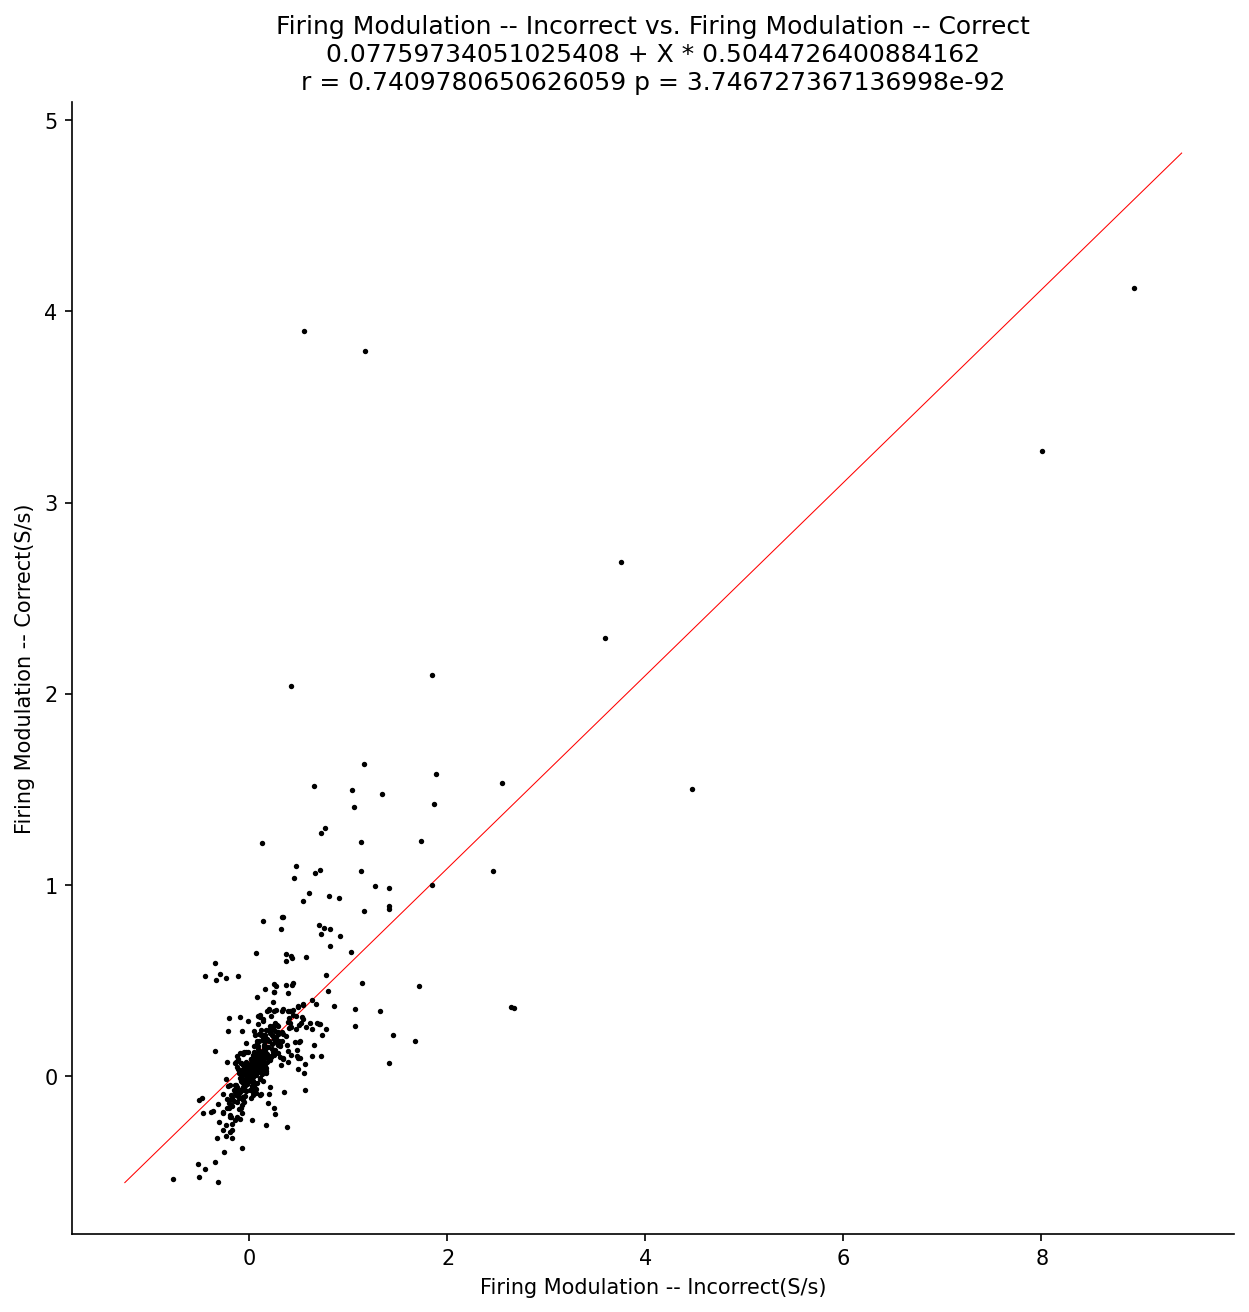

In [203]:
features = []
############################
feature = SimpleNamespace()
feature.data = animal
feature.label = 'Animal'
feature.units = ''
feature.numeric=False
feature.neural=False
features.append(feature)
############################
feature = SimpleNamespace()
feature.data = region
feature.label = 'Region'
feature.units = ''
feature.numeric=False
feature.neural=False
features.append(feature)
############################
feature = SimpleNamespace()
feature.data = day_of_training
feature.label = 'Day of training'
feature.units = ''
feature.numeric=True
feature.neural=False
features.append(feature)
#############################
#feature = SimpleNamespace()
#feature.data = condition
#feature.label = 'Learning Condition'
#feature.units = ''
#feature.neural=False
#features.append(feature)
############################
feature = SimpleNamespace()
feature.data = depth
feature.label = 'Depth'
feature.units = 'days'
feature.numeric=True
feature.neural=False
features.append(feature)
############################
feature = SimpleNamespace()
feature.data = pc
feature.label = 'Percent correct'
feature.units = '%'
feature.numeric=True
feature.neural=False
features.append(feature)
############################
feature = SimpleNamespace()
feature.data = pcON
feature.label = 'Percent correct -- ON'
feature.units = '%'
feature.numeric=True
feature.neural=False
features.append(feature)
############################
feature = SimpleNamespace()
feature.data = pcOFF
feature.label = 'Percent correct -- OFF'
feature.units = '%'
feature.numeric=True
feature.neural=False
features.append(feature)
############################
feature = SimpleNamespace()
feature.data = dp
feature.label = 'Behavioral performance'
feature.units = 'd\''
feature.numeric=True
feature.neural=False
features.append(feature)
############################
feature = SimpleNamespace()
feature.data = dpON
feature.label = 'Behavioral performance -- ON'
feature.units = 'd\''
feature.numeric=True
feature.neural=False
features.append(feature)
############################
feature = SimpleNamespace()
feature.data = dpOFF
feature.label = 'Behavioral performance -- OFF'
feature.units = 'd\''
feature.numeric=True
feature.neural=False
features.append(feature)
############################
feature = SimpleNamespace()
feature.data = FR
feature.label = 'Firing Rate'
feature.units = 'S/s'
feature.numeric=True
feature.neural=True
features.append(feature)
############################
feature = SimpleNamespace()
feature.data = FRmodON
feature.label = 'Firing Modulation -- ON'
feature.units = 'S/s'
feature.numeric=True
feature.neural=True
features.append(feature)
############################
feature = SimpleNamespace()
feature.data = FRmodOFF
feature.label = 'Firing Modulation -- OFF'
feature.units = 'S/s'
feature.numeric=True
feature.neural=True
features.append(feature)
############################
feature = SimpleNamespace()
feature.data = FRmodTarget
feature.label = 'Firing Modulation -- Target'
feature.units = 'S/s'
feature.numeric=True
feature.neural=True
features.append(feature)
############################
feature = SimpleNamespace()
feature.data = FRmodNontarget
feature.label = 'Firing Modulation -- Nontarget'
feature.units = 'S/s'
feature.numeric=True
feature.neural=True
features.append(feature)
############################
feature = SimpleNamespace()
feature.data = FRmodGo
feature.label = 'Firing Modulation -- Go'
feature.units = 'S/s'
feature.numeric=True
feature.neural=True
features.append(feature)
############################
feature = SimpleNamespace()
feature.data = FRmodNogo
feature.label = 'Firing Modulation -- Nogo'
feature.units = 'S/s'
feature.numeric=True
feature.neural=True
features.append(feature)
############################
feature = SimpleNamespace()
feature.data = FRmodCorrect
feature.label = 'Firing Modulation -- Correct'
feature.units = 'S/s'
feature.numeric=True
feature.neural=True
features.append(feature)
############################
feature = SimpleNamespace()
feature.data = FRmodIncorrect
feature.label = 'Firing Modulation -- Incorrect'
feature.units = 'S/s'
feature.numeric=True
feature.neural=True
features.append(feature)

for featureA in features:
    for featureB in features:
        if featureA.label == featureB.label:
            continue
        if not featureB.neural:
            continue
            
        #Figure
        
        plt.close('all')
        fig,ax = plt.subplots(figsize=(10,10))
        ax.scatter(featureA.data,featureB.data,c='black',s=2.5)
        if featureA.units != '':
            ax.set_xlabel(featureA.label + '(' + featureA.units + ')')
        else:
            ax.set_xlabel(featureA.label)
        if featureB.units != '':
            ax.set_ylabel(featureB.label + '(' + featureB.units + ')')
        else:
            ax.set_ylabel(featureB.label)
            
        #Stats
        if featureA.numeric:
            slope, intercept, r, p, std_err = linregress(featureA.data,featureB.data)
            modelstr = '\n'+str(intercept) + ' + X * ' + str(slope)+'\nr = '+str(r)+' p = '+str(p)
            
            xlims = np.array(ax.get_xlim())
            yvals = xlims * slope + intercept
            ax.plot(xlims,yvals,c='r',lw=0.5,zorder=-10)
        else:
            modelstr = ''
        ax.set_title(featureA.label+' vs. '+featureB.label+modelstr)
            
        fig.savefig(os.path.join('D:\\\\Figures','OpsinSummaryPlots',featureA.label+' vs. '+featureB.label+'.png'),transparent=False,facecolor="white")

In [405]:
animalID = []
day_of_reversal = []

FRmodONHit = []
FRmodONMiss = []
FRmodONFalarm = []
FRmodONCreject = []
FRmodOFFHit = []
FRmodOFFMiss = []
FRmodOFFFalarm = []
FRmodOFFCreject = []
pvalHit = []
pvalMiss = []
pvalFalarm = []
pvalCreject = []

animals = ['PB_86','BS_103','BS_100']
colors = ['red','green','blue']

pre_trial_bins_1 = [-200,-100]
pre_trial_bins_2 = [-100,0]
tone_bins = [0,100]
offset_bins= [100,200]
for session in tqdm(sessions):
    try:
        sessionfile = loadSessionCached(destination,session)
        if sessionfile.meta.task != 'opto reversal':
            continue
        if not sessionfile.meta.animal in animals:
            continue
        
        neurons = sessionfile.clusters.good
        
        ##########################################################################################################################
        laserON = sessionfile.trials.laser_stimulation
        laserOFF = np.logical_not(laserON)
        GoResponse = sessionfile.trials.go
        NogoResponse = np.logical_not(GoResponse)
        TargetTone = sessionfile.trials.target
        NontargetTone = np.logical_not(TargetTone)
        
        Hits = np.logical_and(TargetTone,GoResponse)
        Misses = np.logical_and(TargetTone,NogoResponse)
        FAlarms = np.logical_and(NontargetTone,GoResponse)
        CRejects = np.logical_and(NontargetTone,NogoResponse)
        Correct = np.logical_or(Hits,CRejects)
        Incorrect = np.logical_or(Misses,FAlarms)
        
        ##########################################################################################################################
        
        for clust in neurons:
            animalID.append(sessionfile.meta.animal)
            day_of_reversal.append(sessionfile.meta.day_of_reversal)
            
            #Caching search -- Unit
            idx = np.equal(sessionfile.spikes.clusters,clust)
            totaltimes = sessionfile.spikes.times[idx]
            
            #Calculate FRmodBins
            pre_trial_1_spikes = []
            pre_trial_2_spikes = []
            tone_spikes = []
            offset_spikes = []
            whole_trial_spikes = []
            for trial in range(sessionfile.meta.length_in_trials):
                trialstart = sessionfile.trials.starts[trial]
                
                #Caching search -- Whole trial
                bins = [0,2500]
                idx = np.logical_and(      np.greater(totaltimes,trialstart+bins[0]*sessionfile.meta.fs/1000) , np.less(totaltimes,trialstart+bins[1]*sessionfile.meta.fs/1000)     )
                whole_trial_spikes.append(np.sum(idx))
                
                #Caching search -- Pre-Trial 1
                bins = pre_trial_bins_1
                idx = np.logical_and(      np.greater(totaltimes,trialstart+bins[0]*sessionfile.meta.fs/1000) , np.less(totaltimes,trialstart+bins[1]*sessionfile.meta.fs/1000)     )
                pre_trial_1_spikes.append(np.sum(idx))
                
                #Caching search -- Pre-Trial 2
                bins = pre_trial_bins_2
                idx = np.logical_and(      np.greater(totaltimes,trialstart+bins[0]*sessionfile.meta.fs/1000) , np.less(totaltimes,trialstart+bins[1]*sessionfile.meta.fs/1000)     )
                pre_trial_2_spikes.append(np.sum(idx))
                
                #Caching search -- Tone
                bins = tone_bins
                idx = np.logical_and(      np.greater(totaltimes,trialstart+bins[0]*sessionfile.meta.fs/1000) , np.less(totaltimes,trialstart+bins[1]*sessionfile.meta.fs/1000)     )
                tone_spikes.append(np.sum(idx))
                
                #Caching search -- Tone-off
                bins = offset_bins
                idx = np.logical_and(      np.greater(totaltimes,trialstart+bins[0]*sessionfile.meta.fs/1000) , np.less(totaltimes,trialstart+bins[1]*sessionfile.meta.fs/1000)     )
                offset_spikes.append( np.sum(idx))
                
            pre_trial_1_spikes = np.array(pre_trial_1_spikes)
            pre_trial_2_spikes = np.array(pre_trial_2_spikes)
            tone_spikes = np.array(tone_spikes)
            offset_spikes = np.array(offset_spikes)
            
            #Calculate FR Modulation ON Hit
            try:
                TempFRmodOnset = []
                TempFRmodOffset = []
                condition = np.where(np.logical_and(laserON,Hits))[0]
                numtrials = len(condition)
                Temp_pre_tone_spikes = np.concatenate((pre_trial_1_spikes[condition],pre_trial_2_spikes[condition]))
                Temp_tone_spikes = tone_spikes[condition]
                Temp_offset_spikes = offset_spikes[condition]
                for sample in range(100):
                    baseline = np.mean(np.random.choice(Temp_pre_tone_spikes,size=int(0.45*numtrials),replace=True))
                    onset = np.mean(np.random.choice(Temp_tone_spikes,size=int(0.9*numtrials),replace=True))
                    offset = np.mean(np.random.choice(Temp_offset_spikes,size=int(0.9*numtrials),replace=True))
                    TempFRmodOnset.append((onset-baseline))
                    TempFRmodOffset.append((offset-baseline))
                ONonset = TempFRmodOnset
                ONoffset = TempFRmodOffset
                TempFRmodOnset = np.mean(TempFRmodOnset)
                TempFRmodOffset = np.mean(TempFRmodOffset)
                overallFRmod = TempFRmodOnset
                if np.abs(TempFRmodOffset) > np.abs(TempFRmodOnset):
                    overallFRmod = TempFRmodOffset
                temp1 = overallFRmod
                #Calculate FR Modulation OFF Hit
                TempFRmodOnset = []
                TempFRmodOffset = []
                condition = np.where(np.logical_and(laserON,Hits))[0]
                numtrials = len(condition)
                Temp_pre_tone_spikes = np.concatenate((pre_trial_1_spikes[condition],pre_trial_2_spikes[condition]))
                Temp_tone_spikes = tone_spikes[condition]
                Temp_offset_spikes = offset_spikes[condition]
                for sample in range(100):
                    baseline = np.mean(np.random.choice(Temp_pre_tone_spikes,size=int(0.45*numtrials),replace=True))
                    onset = np.mean(np.random.choice(Temp_tone_spikes,size=int(0.9*numtrials),replace=True))
                    offset = np.mean(np.random.choice(Temp_offset_spikes,size=int(0.9*numtrials),replace=True))
                    TempFRmodOnset.append((onset-baseline))
                    TempFRmodOffset.append((offset-baseline))
                OFFonset = TempFRmodOnset
                OFFoffset = TempFRmodOffset
                TempFRmodOnset = np.mean(TempFRmodOnset)
                TempFRmodOffset = np.mean(TempFRmodOffset)
                overallFRmod = TempFRmodOnset
                if np.abs(TempFRmodOffset) > np.abs(TempFRmodOnset):
                    overallFRmod = TempFRmodOffset
                temp2 = overallFRmod
                #Significances
                onsetpval = mannwhitneyu(ONonset,OFFonset).pvalue
                offsetpval = mannwhitneyu(ONoffset,OFFoffset).pvalue
                pvalHit.append(np.minimum(onsetpval,offsetpval))
                FRmodONHit.append(temp1)
                FRmodOFFHit.append(temp2)
            except:
                FRmodONHit.append(np.nan)
                FRmodOFFHit.append(np.nan)
                pvalHit.append(np.nan)
            
            #Calculate FR Modulation ON Miss
            try:
                TempFRmodOnset = []
                TempFRmodOffset = []
                condition = np.where(np.logical_and(laserON,Misses))[0]
                numtrials = len(condition)
                Temp_pre_tone_spikes = np.concatenate((pre_trial_1_spikes[condition],pre_trial_2_spikes[condition]))
                Temp_tone_spikes = tone_spikes[condition]
                Temp_offset_spikes = offset_spikes[condition]
                for sample in range(100):
                    baseline = np.mean(np.random.choice(Temp_pre_tone_spikes,size=int(0.45*numtrials),replace=True))
                    onset = np.mean(np.random.choice(Temp_tone_spikes,size=int(0.9*numtrials),replace=True))
                    offset = np.mean(np.random.choice(Temp_offset_spikes,size=int(0.9*numtrials),replace=True))
                    TempFRmodOnset.append((onset-baseline))
                    TempFRmodOffset.append((offset-baseline))
                ONonset = TempFRmodOnset
                ONoffset = TempFRmodOffset
                TempFRmodOnset = np.mean(TempFRmodOnset)
                TempFRmodOffset = np.mean(TempFRmodOffset)
                overallFRmod = TempFRmodOnset
                if np.abs(TempFRmodOffset) > np.abs(TempFRmodOnset):
                    overallFRmod = TempFRmodOffset
                temp1 = overallFRmod
                #Calculate FR Modulation OFF Miss
                TempFRmodOnset = []
                TempFRmodOffset = []
                condition = np.where(np.logical_and(laserON,Misses))[0]
                numtrials = len(condition)
                Temp_pre_tone_spikes = np.concatenate((pre_trial_1_spikes[condition],pre_trial_2_spikes[condition]))
                Temp_tone_spikes = tone_spikes[condition]
                Temp_offset_spikes = offset_spikes[condition]
                for sample in range(100):
                    baseline = np.mean(np.random.choice(Temp_pre_tone_spikes,size=int(0.45*numtrials),replace=True))
                    onset = np.mean(np.random.choice(Temp_tone_spikes,size=int(0.9*numtrials),replace=True))
                    offset = np.mean(np.random.choice(Temp_offset_spikes,size=int(0.9*numtrials),replace=True))
                    TempFRmodOnset.append((onset-baseline))
                    TempFRmodOffset.append((offset-baseline))
                OFFonset = TempFRmodOnset
                OFFoffset = TempFRmodOffset
                TempFRmodOnset = np.mean(TempFRmodOnset)
                TempFRmodOffset = np.mean(TempFRmodOffset)
                overallFRmod = TempFRmodOnset
                if np.abs(TempFRmodOffset) > np.abs(TempFRmodOnset):
                    overallFRmod = TempFRmodOffset
                temp2 = overallFRmod
                #Significances
                onsetpval = mannwhitneyu(ONonset,OFFonset).pvalue
                offsetpval = mannwhitneyu(ONoffset,OFFoffset).pvalue
                pvalMiss.append(np.minimum(onsetpval,offsetpval))
                FRmodONMiss.append(temp1)
                FRmodOFFMiss.append(temp2)
            except:
                FRmodONMiss.append(np.nan)
                FRmodOFFMiss.append(np.nan)
                pvalMiss.append(np.nan)
            
            #Calculate FR Modulation ON Falarm
            try:
                TempFRmodOnset = []
                TempFRmodOffset = []
                condition = np.where(np.logical_and(laserON,FAlarms))[0]
                numtrials = len(condition)
                Temp_pre_tone_spikes = np.concatenate((pre_trial_1_spikes[condition],pre_trial_2_spikes[condition]))
                Temp_tone_spikes = tone_spikes[condition]
                Temp_offset_spikes = offset_spikes[condition]
                for sample in range(100):
                    baseline = np.mean(np.random.choice(Temp_pre_tone_spikes,size=int(0.45*numtrials),replace=True))
                    onset = np.mean(np.random.choice(Temp_tone_spikes,size=int(0.9*numtrials),replace=True))
                    offset = np.mean(np.random.choice(Temp_offset_spikes,size=int(0.9*numtrials),replace=True))
                    TempFRmodOnset.append((onset-baseline))
                    TempFRmodOffset.append((offset-baseline))
                ONonset = TempFRmodOnset
                ONoffset = TempFRmodOffset
                TempFRmodOnset = np.mean(TempFRmodOnset)
                TempFRmodOffset = np.mean(TempFRmodOffset)
                overallFRmod = TempFRmodOnset
                if np.abs(TempFRmodOffset) > np.abs(TempFRmodOnset):
                    overallFRmod = TempFRmodOffset
                temp1 = overallFRmod
                #Calculate FR Modulation OFF Falarm
                TempFRmodOnset = []
                TempFRmodOffset = []
                condition = np.where(np.logical_and(laserON,FAlarms))[0]
                numtrials = len(condition)
                Temp_pre_tone_spikes = np.concatenate((pre_trial_1_spikes[condition],pre_trial_2_spikes[condition]))
                Temp_tone_spikes = tone_spikes[condition]
                Temp_offset_spikes = offset_spikes[condition]
                for sample in range(100):
                    baseline = np.mean(np.random.choice(Temp_pre_tone_spikes,size=int(0.45*numtrials),replace=True))
                    onset = np.mean(np.random.choice(Temp_tone_spikes,size=int(0.9*numtrials),replace=True))
                    offset = np.mean(np.random.choice(Temp_offset_spikes,size=int(0.9*numtrials),replace=True))
                    TempFRmodOnset.append((onset-baseline))
                    TempFRmodOffset.append((offset-baseline))
                OFFonset = TempFRmodOnset
                OFFoffset = TempFRmodOffset
                TempFRmodOnset = np.mean(TempFRmodOnset)
                TempFRmodOffset = np.mean(TempFRmodOffset)
                overallFRmod = TempFRmodOnset
                if np.abs(TempFRmodOffset) > np.abs(TempFRmodOnset):
                    overallFRmod = TempFRmodOffset
                temp2 = overallFRmod
                #Significances
                onsetpval = mannwhitneyu(ONonset,OFFonset).pvalue
                offsetpval = mannwhitneyu(ONoffset,OFFoffset).pvalue
                pvalFalarm.append(np.minimum(onsetpval,offsetpval))
                FRmodONFalarm.append(temp1)
                FRmodOFFFalarm.append(temp2)
            except:
                FRmodONFalarm.append(np.nan)
                FRmodOFFFalarm.append(np.nan)
                pvalFalarm.append(np.nan)
            
            #Calculate FR Modulation ON Creject
            try:
                TempFRmodOnset = []
                TempFRmodOffset = []
                condition = np.where(np.logical_and(laserON,CRejects))[0]
                numtrials = len(condition)
                Temp_pre_tone_spikes = np.concatenate((pre_trial_1_spikes[condition],pre_trial_2_spikes[condition]))
                Temp_tone_spikes = tone_spikes[condition]
                Temp_offset_spikes = offset_spikes[condition]
                for sample in range(100):
                    baseline = np.mean(np.random.choice(Temp_pre_tone_spikes,size=int(0.45*numtrials),replace=True))
                    onset = np.mean(np.random.choice(Temp_tone_spikes,size=int(0.9*numtrials),replace=True))
                    offset = np.mean(np.random.choice(Temp_offset_spikes,size=int(0.9*numtrials),replace=True))
                    TempFRmodOnset.append((onset-baseline))
                    TempFRmodOffset.append((offset-baseline))
                ONonset = TempFRmodOnset
                ONoffset = TempFRmodOffset
                TempFRmodOnset = np.mean(TempFRmodOnset)
                TempFRmodOffset = np.mean(TempFRmodOffset)
                overallFRmod = TempFRmodOnset
                if np.abs(TempFRmodOffset) > np.abs(TempFRmodOnset):
                    overallFRmod = TempFRmodOffset
                temp1 = overallFRmod
                #Calculate FR Modulation OFF Creject
                TempFRmodOnset = []
                TempFRmodOffset = []
                condition = np.where(np.logical_and(laserON,CRejects))[0]
                numtrials = len(condition)
                Temp_pre_tone_spikes = np.concatenate((pre_trial_1_spikes[condition],pre_trial_2_spikes[condition]))
                Temp_tone_spikes = tone_spikes[condition]
                Temp_offset_spikes = offset_spikes[condition]
                for sample in range(100):
                    baseline = np.mean(np.random.choice(Temp_pre_tone_spikes,size=int(0.45*numtrials),replace=True))
                    onset = np.mean(np.random.choice(Temp_tone_spikes,size=int(0.9*numtrials),replace=True))
                    offset = np.mean(np.random.choice(Temp_offset_spikes,size=int(0.9*numtrials),replace=True))
                    TempFRmodOnset.append((onset-baseline))
                    TempFRmodOffset.append((offset-baseline))
                OFFonset = TempFRmodOnset
                OFFoffset = TempFRmodOffset
                TempFRmodOnset = np.mean(TempFRmodOnset)
                TempFRmodOffset = np.mean(TempFRmodOffset)
                overallFRmod = TempFRmodOnset
                if np.abs(TempFRmodOffset) > np.abs(TempFRmodOnset):
                    overallFRmod = TempFRmodOffset
                temp2 = overallFRmod
                #Significances
                onsetpval = mannwhitneyu(ONonset,OFFonset).pvalue
                offsetpval = mannwhitneyu(ONoffset,OFFoffset).pvalue
                pvalCreject.append(np.minimum(onsetpval,offsetpval))
                FRmodONCreject.append(temp1)
                FRmodOFFCreject.append(temp2)
            except:
                FRmodONCreject.append(np.nan)
                FRmodOFFCreject.append(np.nan)
                pvalCreject.append(np.nan)
            
    except Exception as e:
        print(e)
        
FRmodONHit = np.array(FRmodONHit)
FRmodONMiss = np.array(FRmodONMiss)
FRmodONFalarm = np.array(FRmodONFalarm)
FRmodONCreject = np.array(FRmodONCreject)
FRmodOFFHit = np.array(FRmodOFFHit)
FRmodOFFMiss = np.array(FRmodOFFMiss)
FRmodOFFFalarm = np.array(FRmodOFFFalarm)
FRmodOFFCreject = np.array(FRmodOFFCreject)
pvalHit = np.array(pvalHit)
pvalMiss = np.array(pvalMiss)
pvalFalarm = np.array(pvalFalarm)
pvalCreject = np.array(pvalCreject)

100%|██████████| 30/30 [00:28<00:00,  1.04it/s]


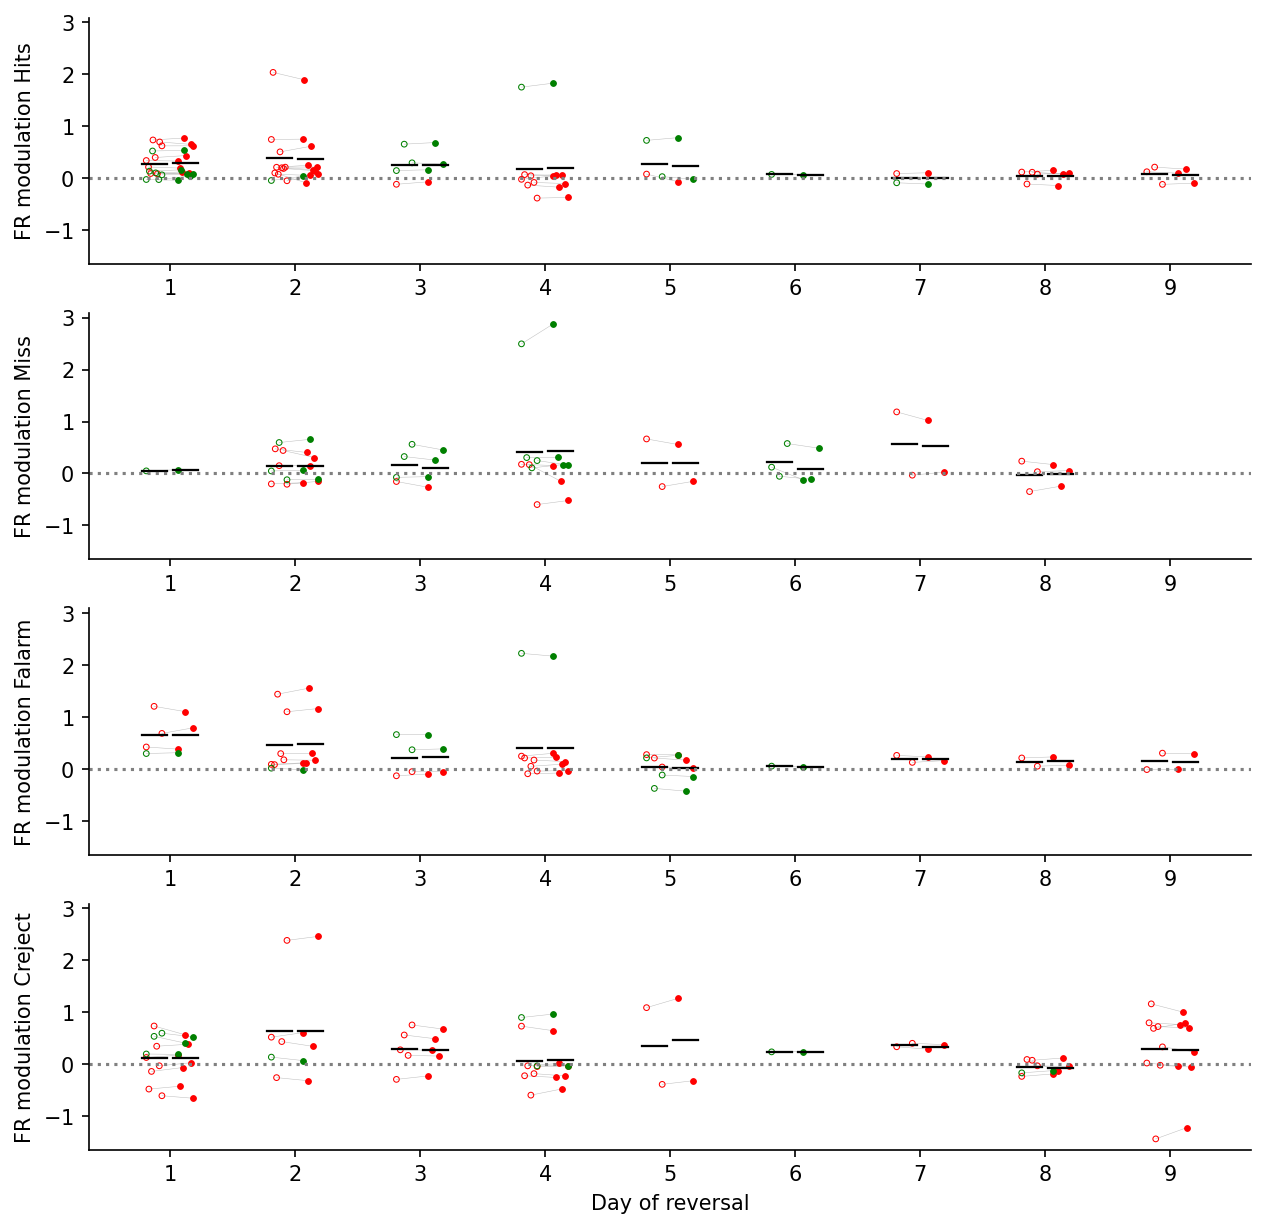

In [457]:
daystoplot = np.max(day_of_reversal)

width = 0.125/2
width2 = 0.2/2
spread = 0.125
size=7.5

fig,ax = plt.subplots(figsize=(10,10))
gs = fig.add_gridspec(4,1,hspace=0.2,wspace=0.5)#0.1)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0],sharex=ax1,sharey=ax1)
ax3 = plt.subplot(gs[2,0],sharex=ax1,sharey=ax1)
ax4 = plt.subplot(gs[3,0],sharex=ax1,sharey=ax1)

for anml in animals:
    for day in range(daystoplot):
        daysidx = (np.equal(day_of_reversal,day))
        sig = np.less(pvalHit,0.05)
        aml = [ID == anml for ID in animalID]
        idx = np.logical_and(np.logical_and(daysidx,sig),aml)
        if np.sum(idx) == 0:
            continue
            
        color = colors[animals.index(anml)]
        xrange1 = np.linspace(day-spread-width,day-spread+width,num=np.sum(idx))
        xrange2 = np.linspace(day+spread-width,day+spread+width,num=np.sum(idx))

        ax1.plot([xrange1,xrange2],[FRmodOFFHit[idx],FRmodONHit[idx]],lw=0.25,color='grey',alpha=0.5,zorder=-10)
        ax1.scatter(xrange1,FRmodOFFHit[idx],color=color,s=size,facecolor='None',lw=0.5)
        #offmean = np.nanmean(FRmodOFFHit[idx])
        #ax.plot([day-spread-width2,day-spread+width2],[offmean,offmean],color='black',lw=1)
        ax1.scatter(xrange2,FRmodONHit[idx],color=color,s=size,lw=0.5)
        #onmean = np.nanmean(FRmodONHit[idx])
        #ax.plot([day+spread-width2,day+spread+width2],[onmean,onmean],color='black',lw=1)
        
for anml in animals:
    for day in range(daystoplot):
        daysidx = (np.equal(day_of_reversal,day))
        sig = np.less(pvalHit,0.05)
        idx = np.logical_and(daysidx,sig)
        if np.sum(idx) == 0:
            continue
        offmean = np.nanmean(FRmodOFFHit[idx])
        ax1.plot([day-spread-width2,day-spread+width2],[offmean,offmean],color='black',lw=1)
        onmean = np.nanmean(FRmodONHit[idx])
        ax1.plot([day+spread-width2,day+spread+width2],[onmean,onmean],color='black',lw=1)
        
for animal in animals:
    ax1.scatter(np.nan,np.nan,color=colors[animals.index(animal)],label=animal)
ax1.set_xticks(range(1,daystoplot))
ax1.set_ylabel('FR modulation Hits')


for anml in animals:
    for day in range(daystoplot):
        daysidx = (np.equal(day_of_reversal,day))
        sig = np.less(pvalMiss,0.05)
        aml = [ID == anml for ID in animalID]
        idx = np.logical_and(np.logical_and(daysidx,sig),aml)
        if np.sum(idx) == 0:
            continue
            
        color = colors[animals.index(anml)]
        xrange1 = np.linspace(day-spread-width,day-spread+width,num=np.sum(idx))
        xrange2 = np.linspace(day+spread-width,day+spread+width,num=np.sum(idx))

        ax2.plot([xrange1,xrange2],[FRmodOFFMiss[idx],FRmodONMiss[idx]],lw=0.25,color='grey',alpha=0.5,zorder=-10)
        ax2.scatter(xrange1,FRmodOFFMiss[idx],color=color,s=size,facecolor='None',lw=0.5)
        #offmean = np.nanmean(FRmodOFFHit[idx])
        #ax.plot([day-spread-width2,day-spread+width2],[offmean,offmean],color='black',lw=1)
        ax2.scatter(xrange2,FRmodONMiss[idx],color=color,s=size,lw=0.5)
        #onmean = np.nanmean(FRmodONHit[idx])
        #ax.plot([day+spread-width2,day+spread+width2],[onmean,onmean],color='black',lw=1)
        
for anml in animals:
    for day in range(daystoplot):
        daysidx = (np.equal(day_of_reversal,day))
        sig = np.less(pvalMiss,0.05)
        idx = np.logical_and(daysidx,sig)
        if np.sum(idx) == 0:
            continue
        offmean = np.nanmean(FRmodOFFMiss[idx])
        ax2.plot([day-spread-width2,day-spread+width2],[offmean,offmean],color='black',lw=1)
        onmean = np.nanmean(FRmodONMiss[idx])
        ax2.plot([day+spread-width2,day+spread+width2],[onmean,onmean],color='black',lw=1)
        
for animal in animals:
    ax2.scatter(np.nan,np.nan,color=colors[animals.index(animal)],label=animal)
ax2.set_xticks(range(1,daystoplot))
ax2.set_ylabel('FR modulation Miss')



for anml in animals:
    for day in range(daystoplot):
        daysidx = (np.equal(day_of_reversal,day))
        sig = np.less(pvalFalarm,0.05)
        aml = [ID == anml for ID in animalID]
        idx = np.logical_and(np.logical_and(daysidx,sig),aml)
        if np.sum(idx) == 0:
            continue
            
        color = colors[animals.index(anml)]
        xrange1 = np.linspace(day-spread-width,day-spread+width,num=np.sum(idx))
        xrange2 = np.linspace(day+spread-width,day+spread+width,num=np.sum(idx))

        ax3.plot([xrange1,xrange2],[FRmodOFFFalarm[idx],FRmodONFalarm[idx]],lw=0.25,color='grey',alpha=0.5,zorder=-10)
        ax3.scatter(xrange1,FRmodOFFFalarm[idx],color=color,s=size,facecolor='None',lw=0.5)
        #offmean = np.nanmean(FRmodOFFHit[idx])
        #ax.plot([day-spread-width2,day-spread+width2],[offmean,offmean],color='black',lw=1)
        ax3.scatter(xrange2,FRmodONFalarm[idx],color=color,s=size,lw=0.5)
        #onmean = np.nanmean(FRmodONHit[idx])
        #ax.plot([day+spread-width2,day+spread+width2],[onmean,onmean],color='black',lw=1)
        
for anml in animals:
    for day in range(daystoplot):
        daysidx = (np.equal(day_of_reversal,day))
        sig = np.less(pvalFalarm,0.05)
        idx = np.logical_and(daysidx,sig)
        if np.sum(idx) == 0:
            continue
        offmean = np.nanmean(FRmodOFFFalarm[idx])
        ax3.plot([day-spread-width2,day-spread+width2],[offmean,offmean],color='black',lw=1)
        onmean = np.nanmean(FRmodONFalarm[idx])
        ax3.plot([day+spread-width2,day+spread+width2],[onmean,onmean],color='black',lw=1)
        
for animal in animals:
    ax3.scatter(np.nan,np.nan,color=colors[animals.index(animal)],label=animal)
ax3.set_xticks(range(1,daystoplot))
ax3.set_ylabel('FR modulation Falarm')







for anml in animals:
    for day in range(daystoplot):
        daysidx = (np.equal(day_of_reversal,day))
        sig = np.less(pvalCreject,0.05)
        aml = [ID == anml for ID in animalID]
        idx = np.logical_and(np.logical_and(daysidx,sig),aml)
        if np.sum(idx) == 0:
            continue
            
        color = colors[animals.index(anml)]
        xrange1 = np.linspace(day-spread-width,day-spread+width,num=np.sum(idx))
        xrange2 = np.linspace(day+spread-width,day+spread+width,num=np.sum(idx))

        ax4.plot([xrange1,xrange2],[FRmodOFFCreject[idx],FRmodONCreject[idx]],lw=0.25,color='grey',alpha=0.5,zorder=-10)
        ax4.scatter(xrange1,FRmodOFFCreject[idx],color=color,s=size,facecolor='None',lw=0.5)
        #offmean = np.nanmean(FRmodOFFHit[idx])
        #ax.plot([day-spread-width2,day-spread+width2],[offmean,offmean],color='black',lw=1)
        ax4.scatter(xrange2,FRmodONCreject[idx],color=color,s=size,lw=0.5)
        #onmean = np.nanmean(FRmodONHit[idx])
        #ax.plot([day+spread-width2,day+spread+width2],[onmean,onmean],color='black',lw=1)
        
for anml in animals:
    for day in range(daystoplot):
        daysidx = (np.equal(day_of_reversal,day))
        sig = np.less(pvalCreject,0.05)
        idx = np.logical_and(daysidx,sig)
        if np.sum(idx) == 0:
            continue
        offmean = np.nanmean(FRmodOFFCreject[idx])
        ax4.plot([day-spread-width2,day-spread+width2],[offmean,offmean],color='black',lw=1)
        onmean = np.nanmean(FRmodONCreject[idx])
        ax4.plot([day+spread-width2,day+spread+width2],[onmean,onmean],color='black',lw=1)
        
for animal in animals:
    ax4.scatter(np.nan,np.nan,color=colors[animals.index(animal)],label=animal)
ax4.set_xticks(range(1,daystoplot))
ax4.set_ylabel('FR modulation Creject')


lims = ax1.get_xlim()
ax1.plot(lims,[0,0],color='grey',linestyle=':')
ax2.plot(lims,[0,0],color='grey',linestyle=':')
ax3.plot(lims,[0,0],color='grey',linestyle=':')
ax4.plot(lims,[0,0],color='grey',linestyle=':')
ax1.set_xlim(lims)

ax4.set_xlabel('Day of reversal')

fig.savefig(os.path.join('D:\\\\Figures','FRModbySession.png'),transparent=False,facecolor="white")

  9%|▉         | 32/344 [00:03<00:36,  8.51it/s]C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 10%|▉         | 34/344 [00:07<01:15,  4.10it/s]C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 10%|█         | 36/344 [00:10<01:54,  2.69it/s]C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of 

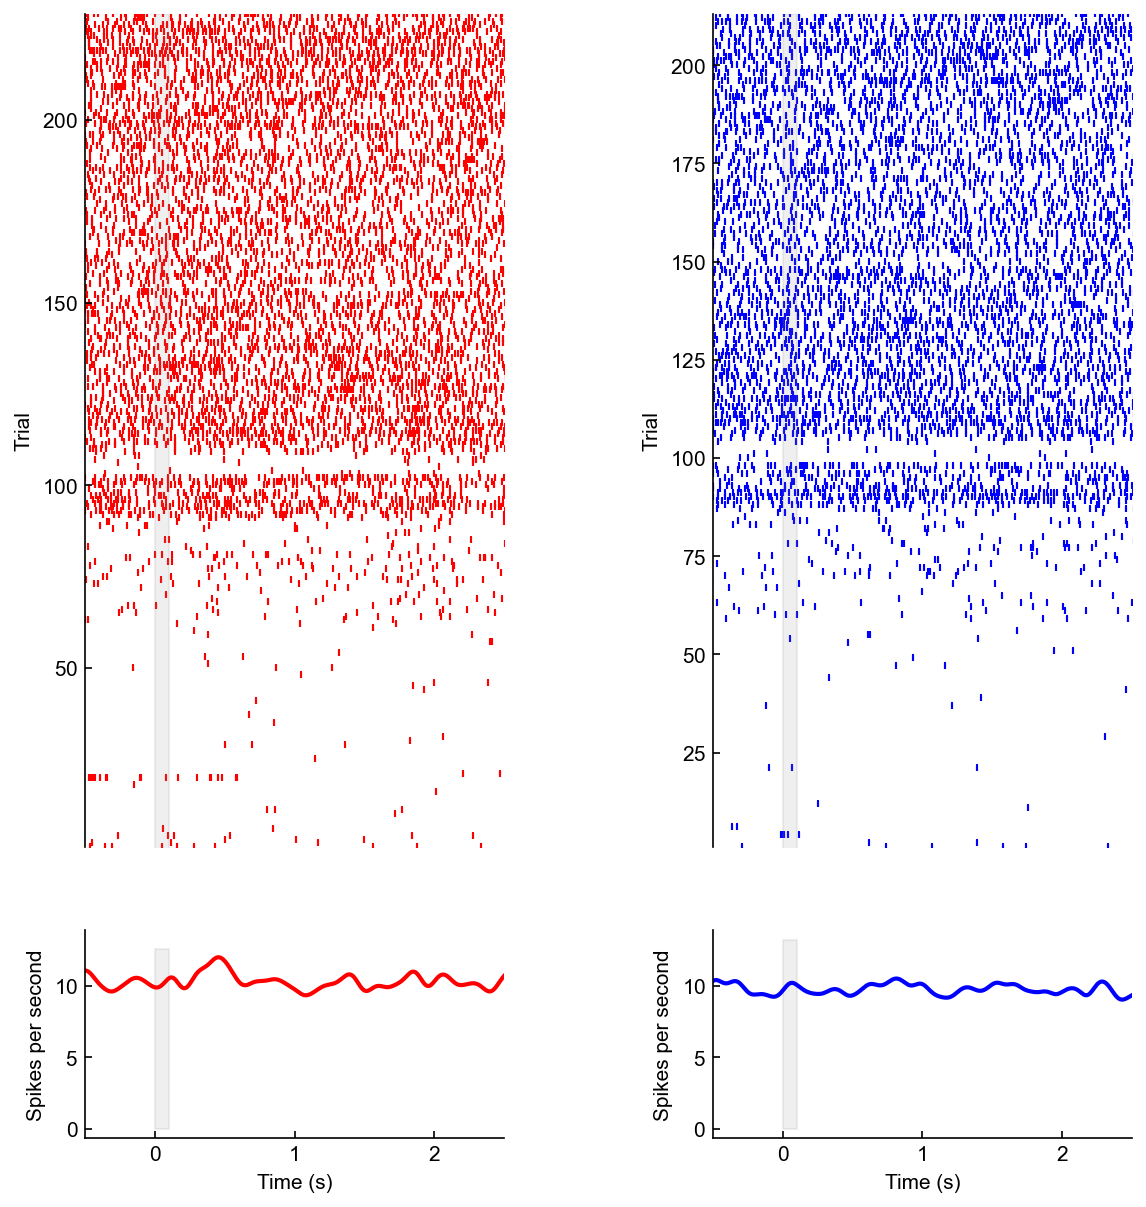

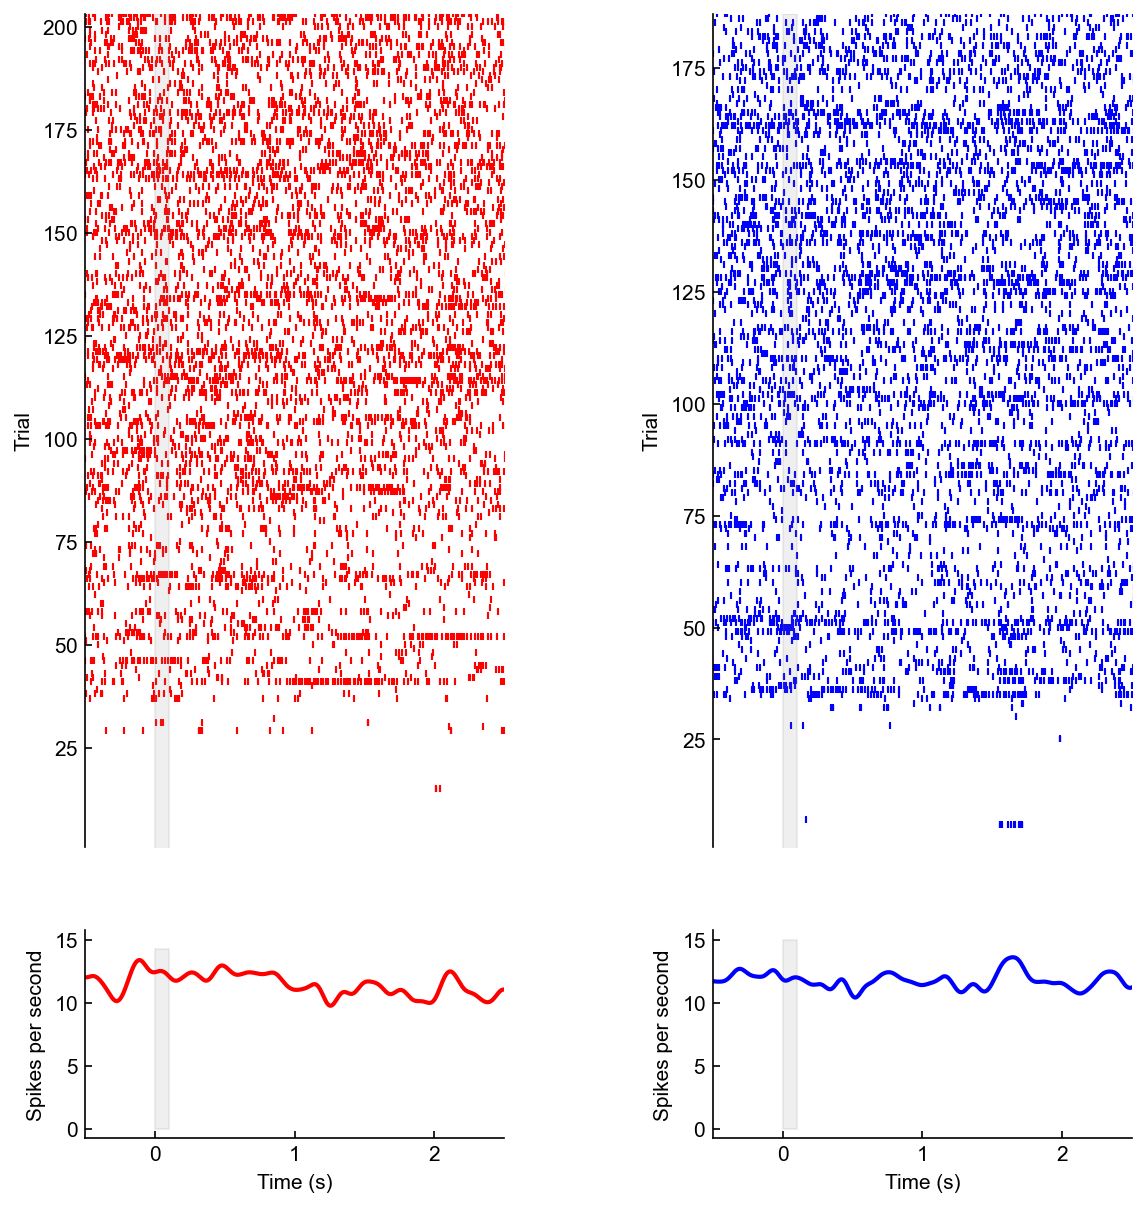

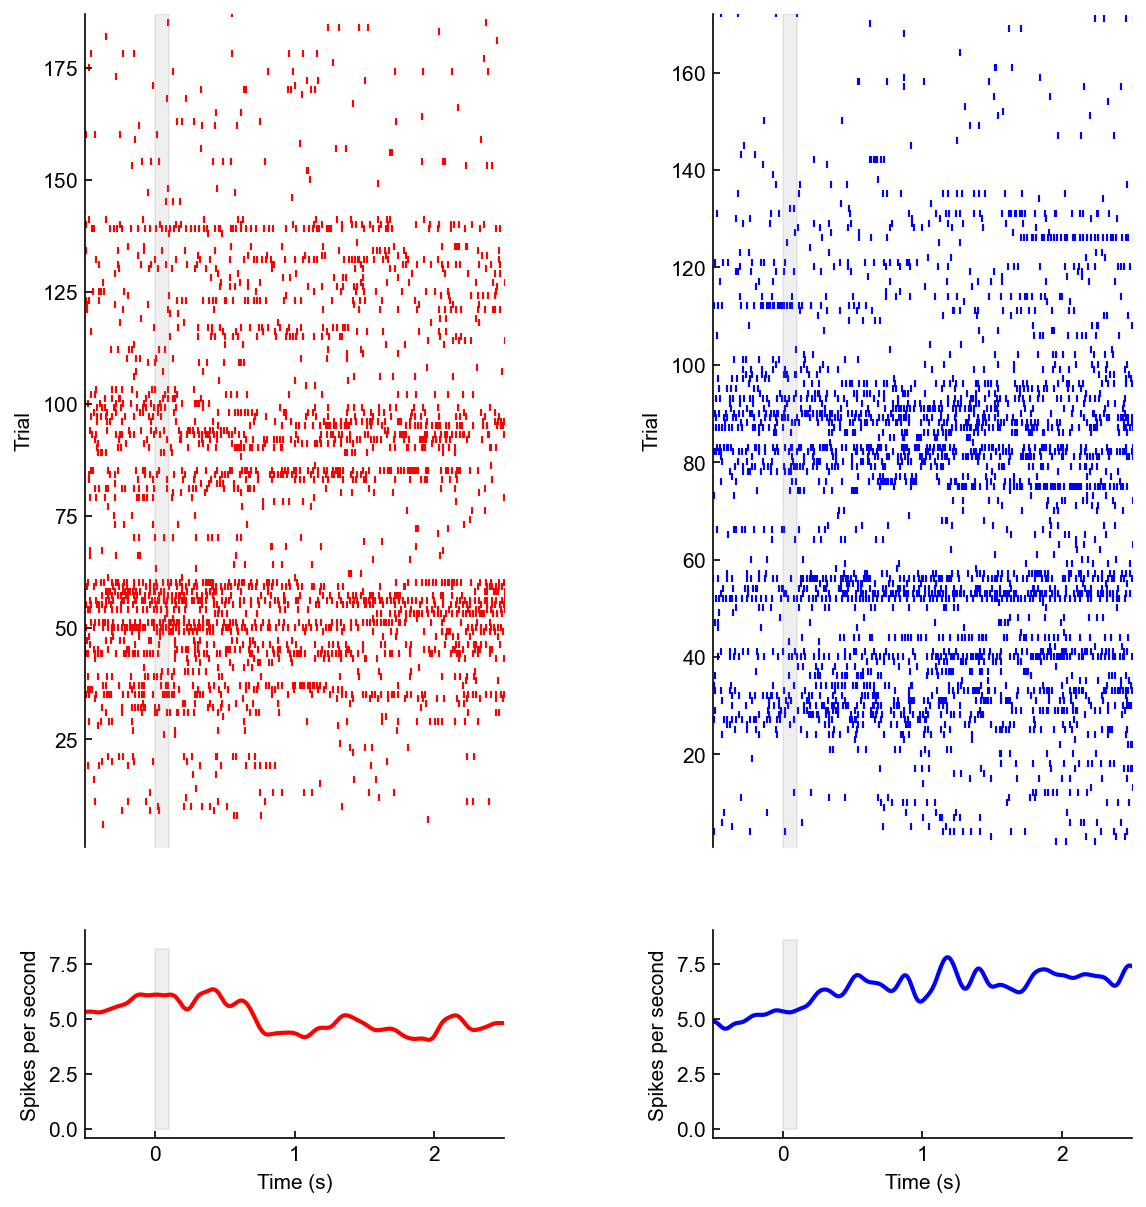

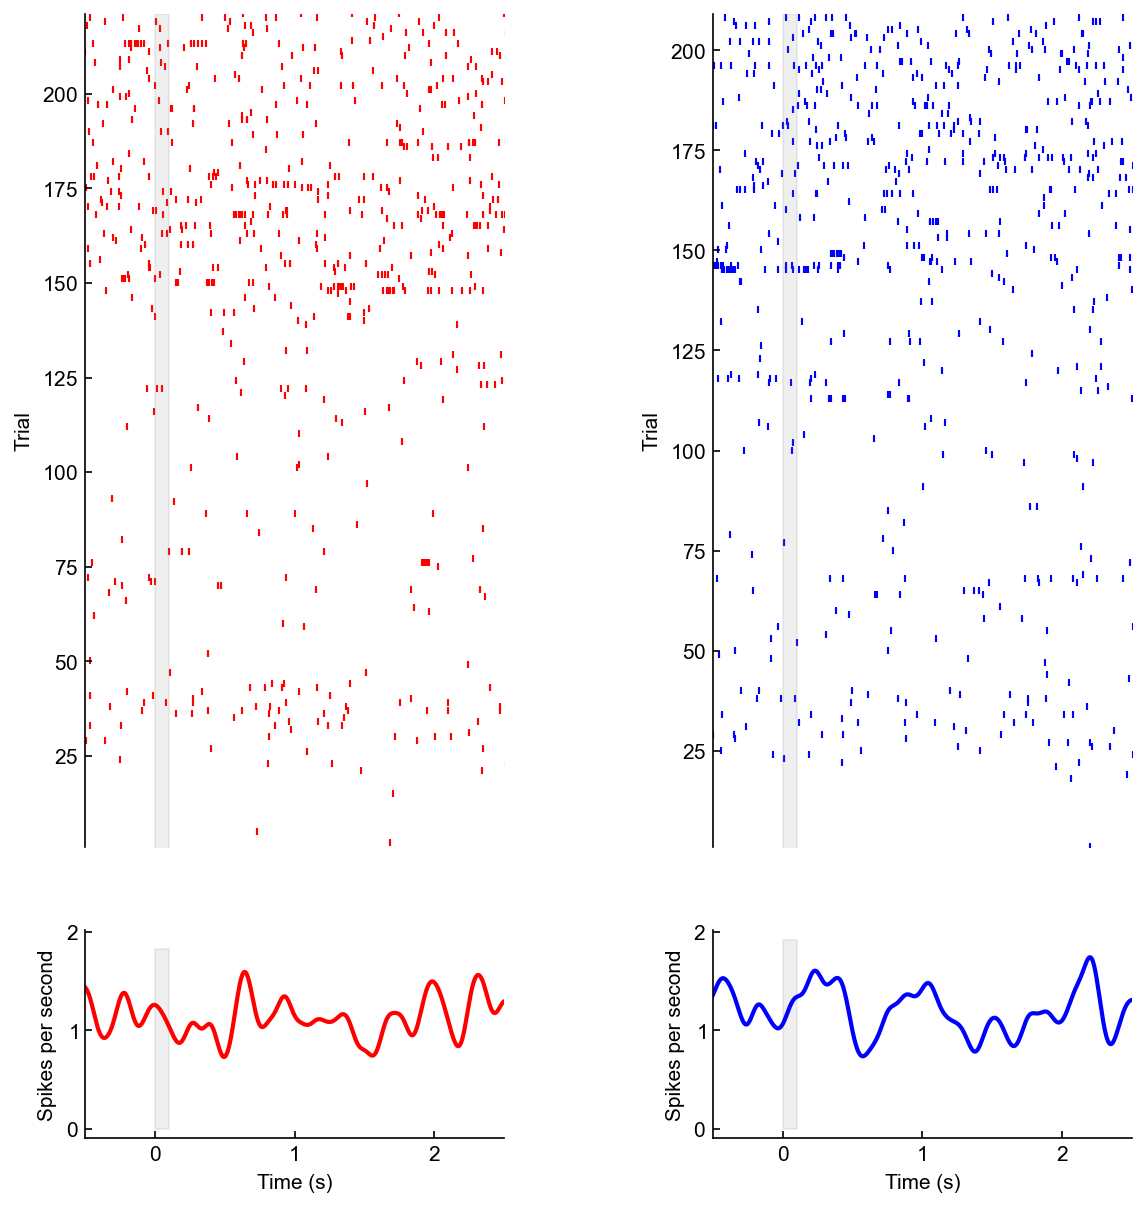

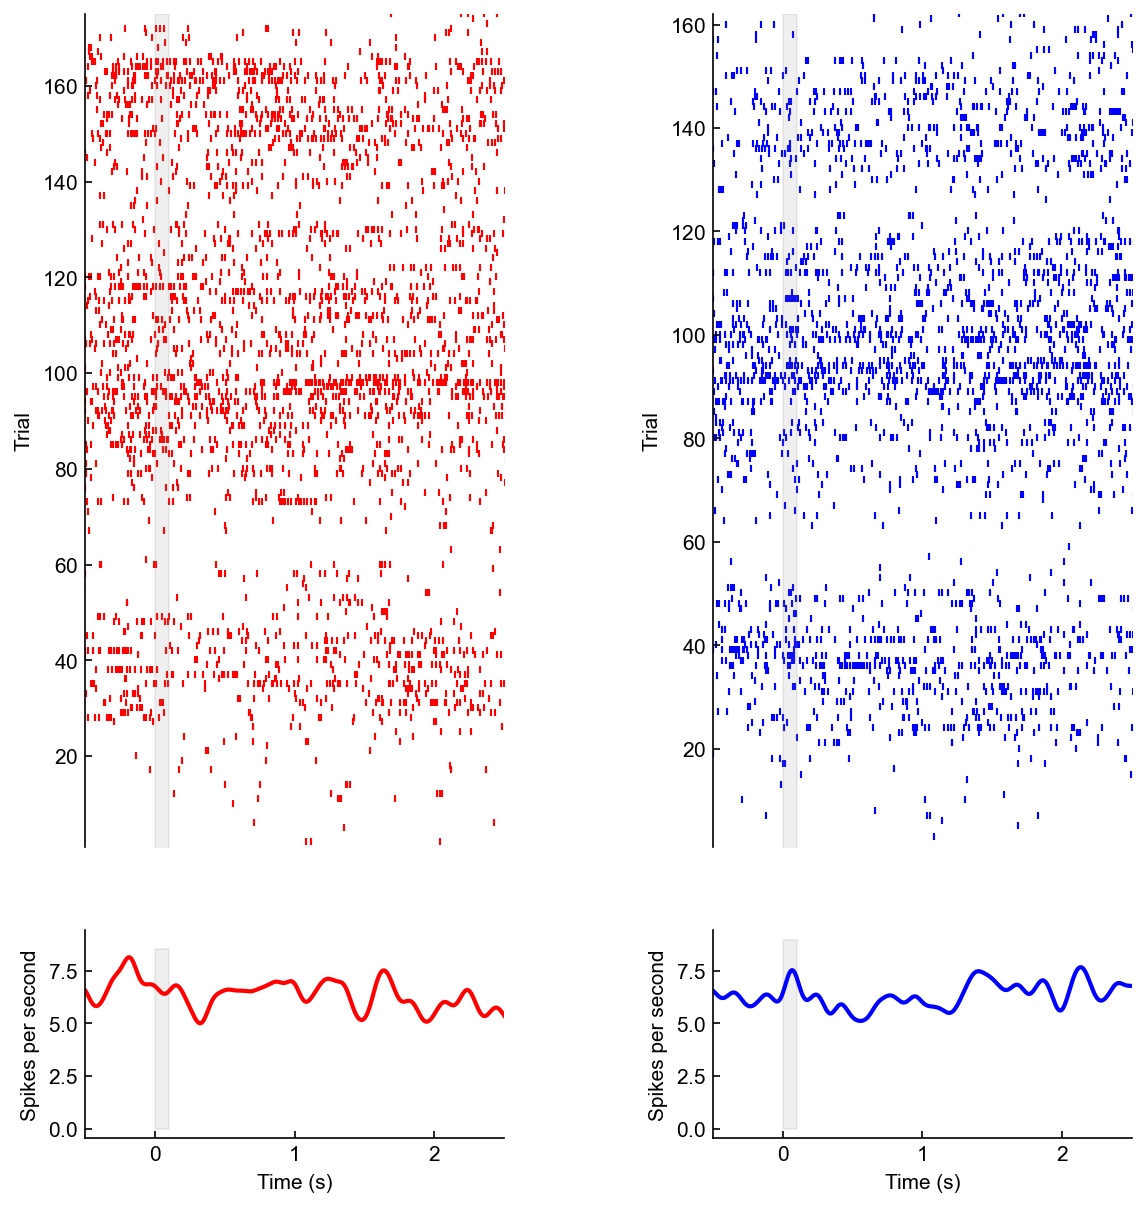

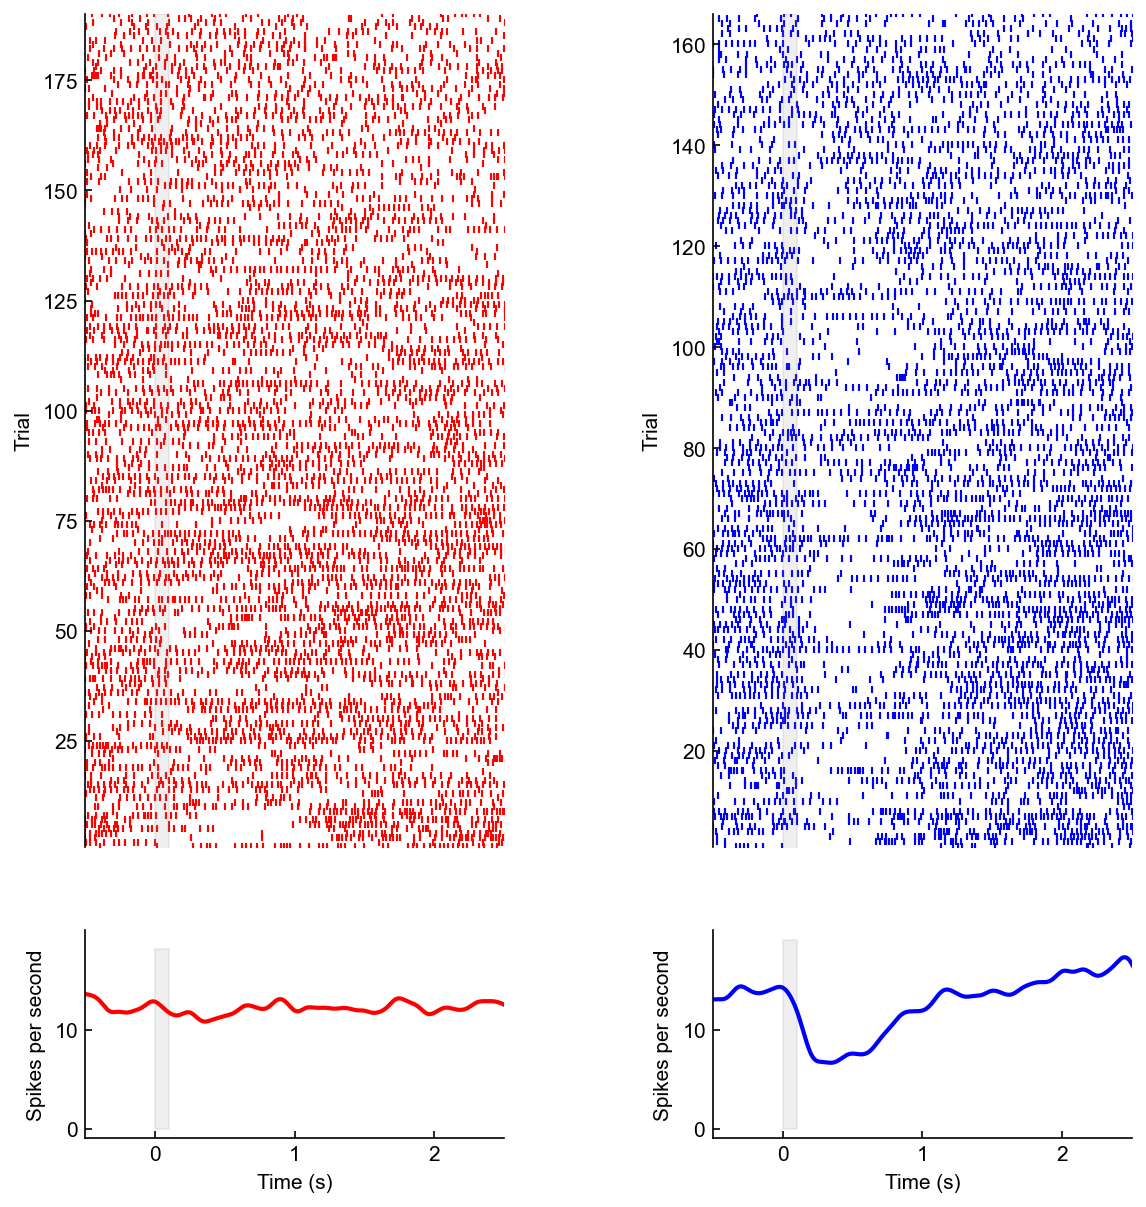

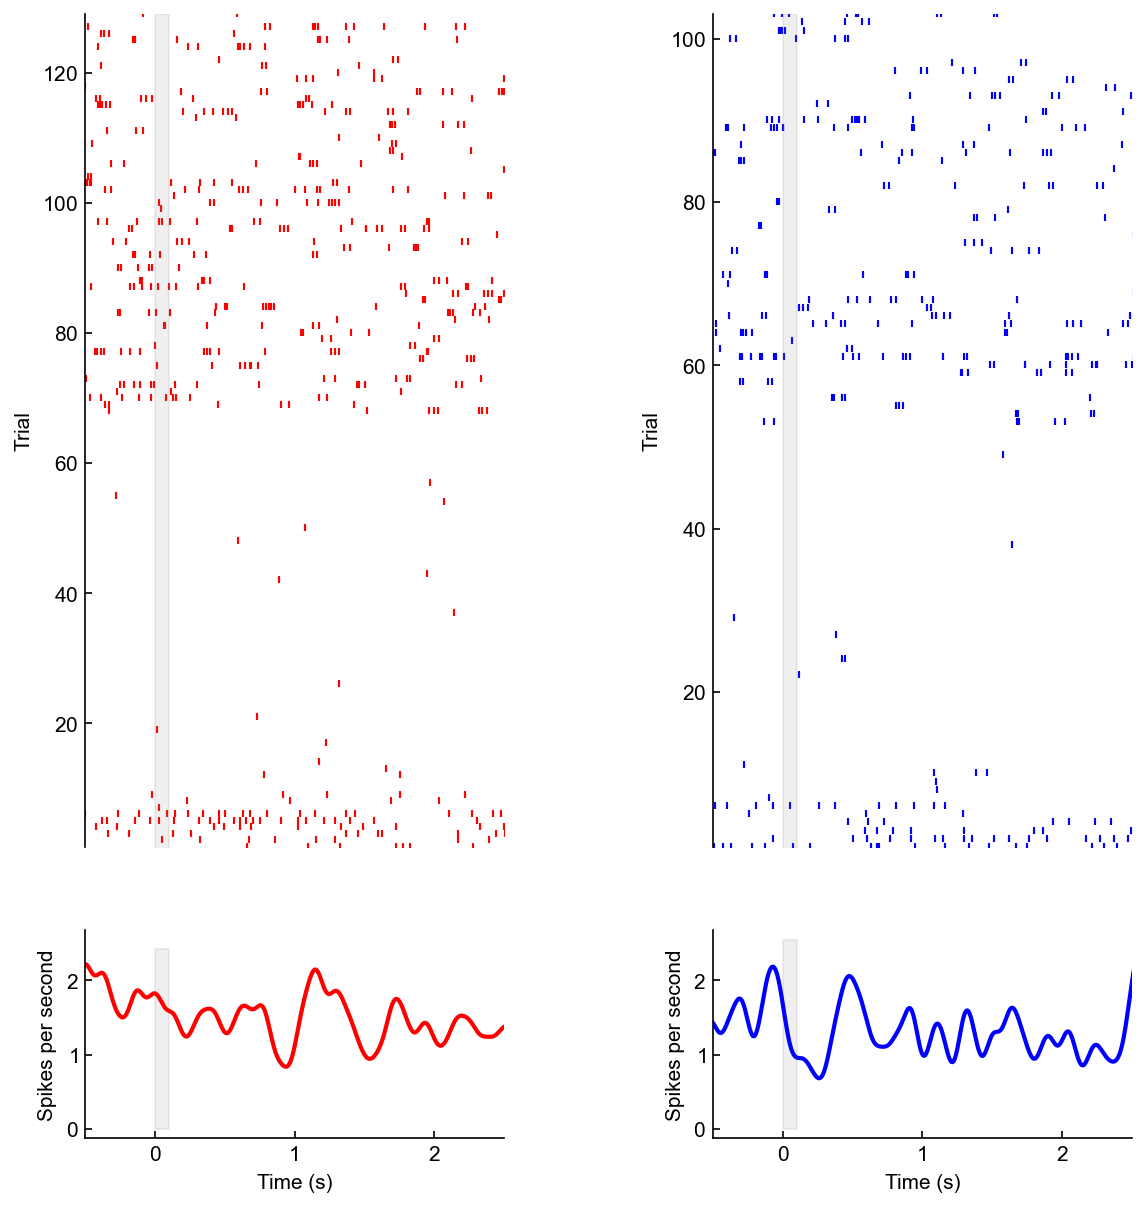

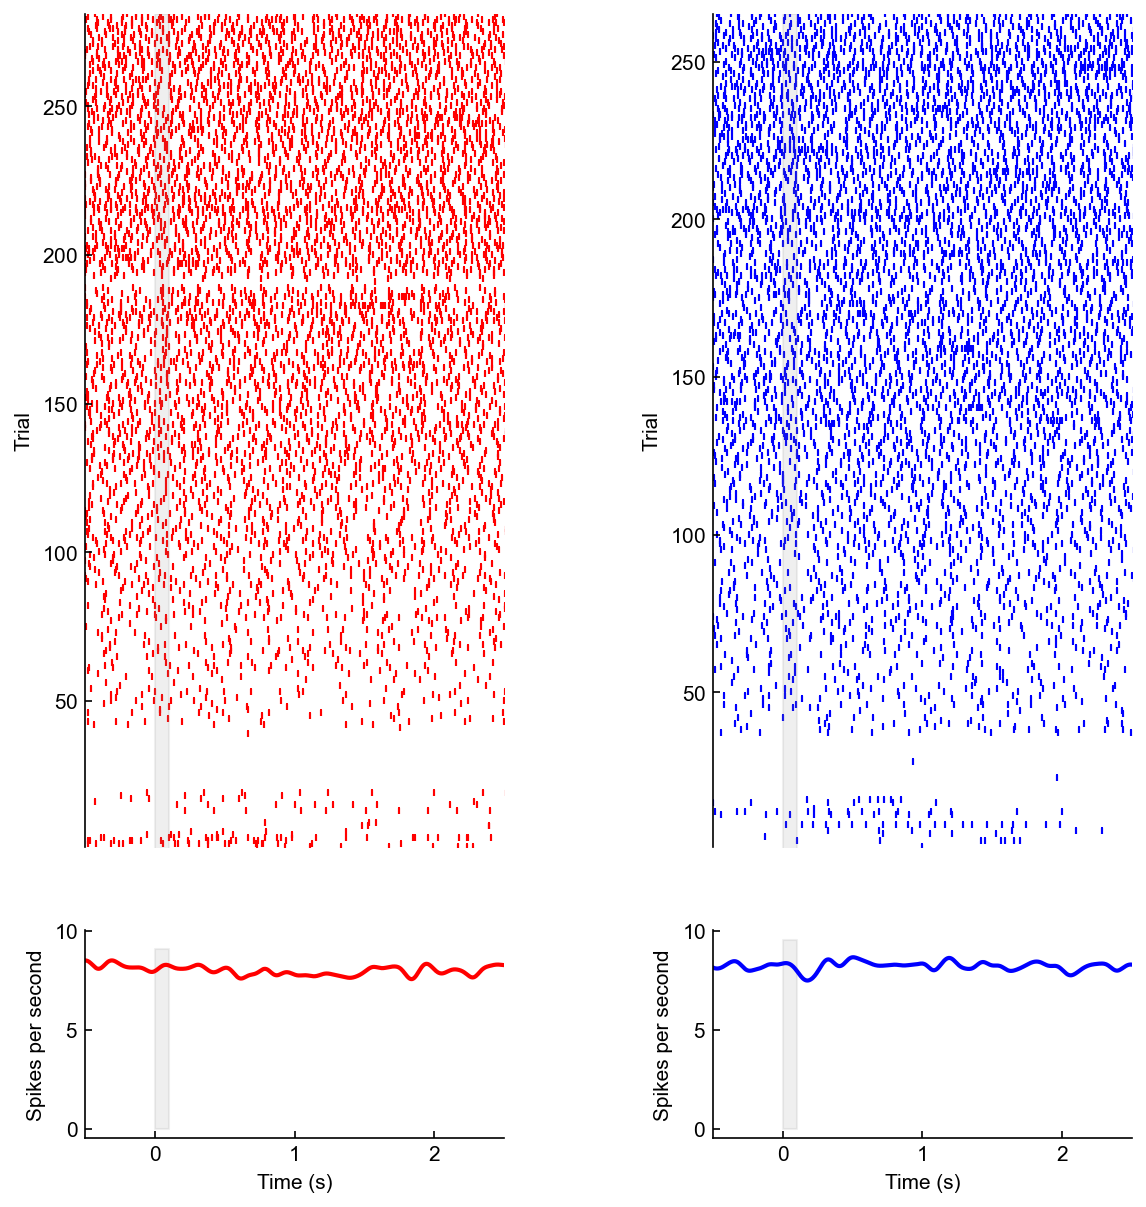

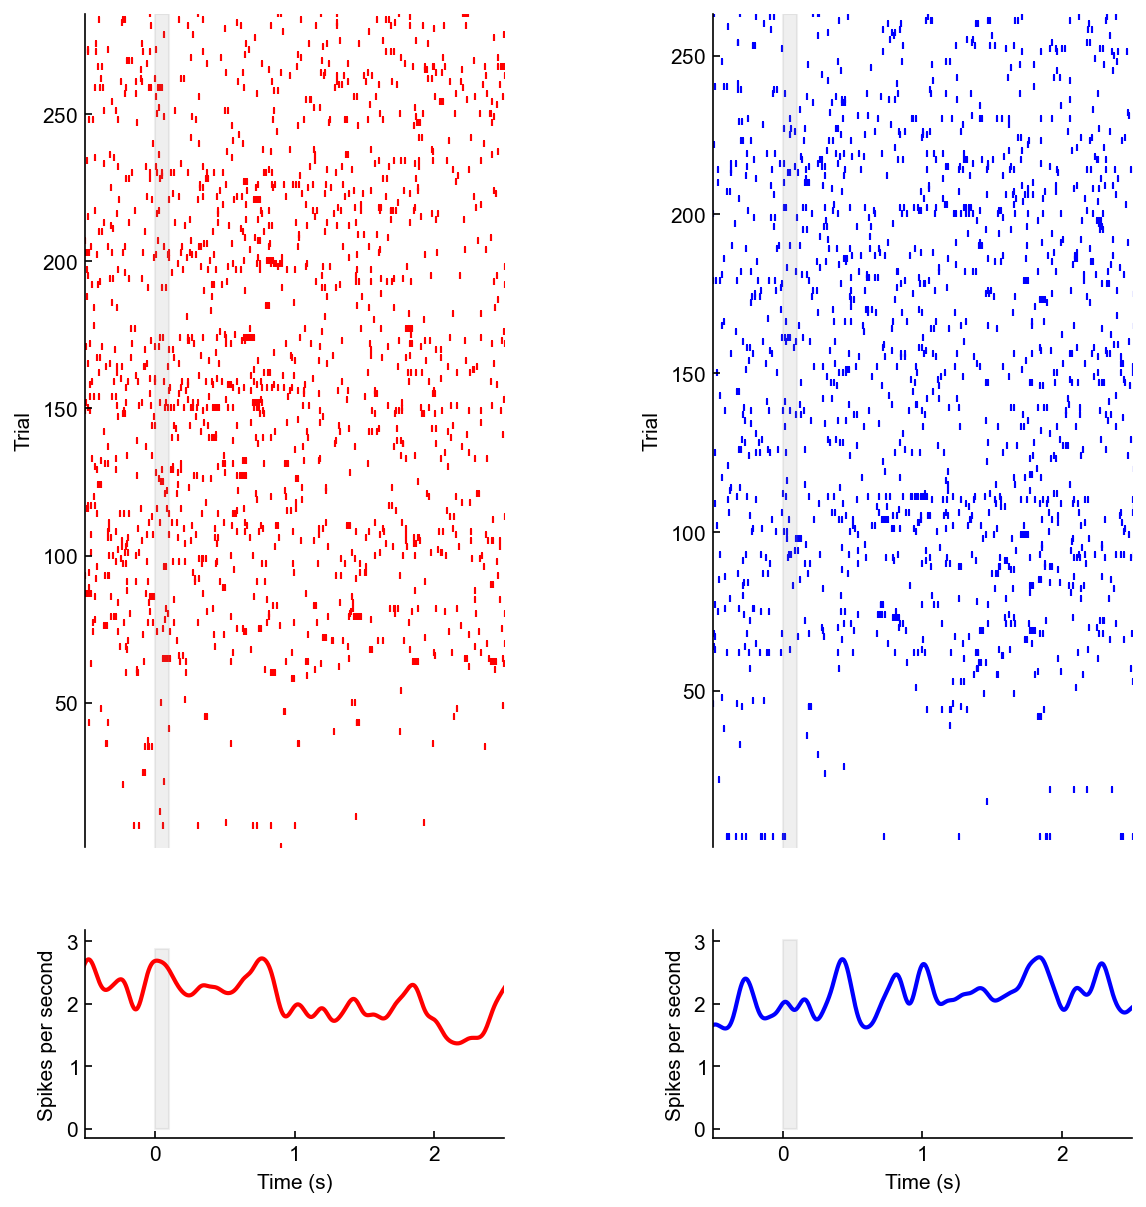

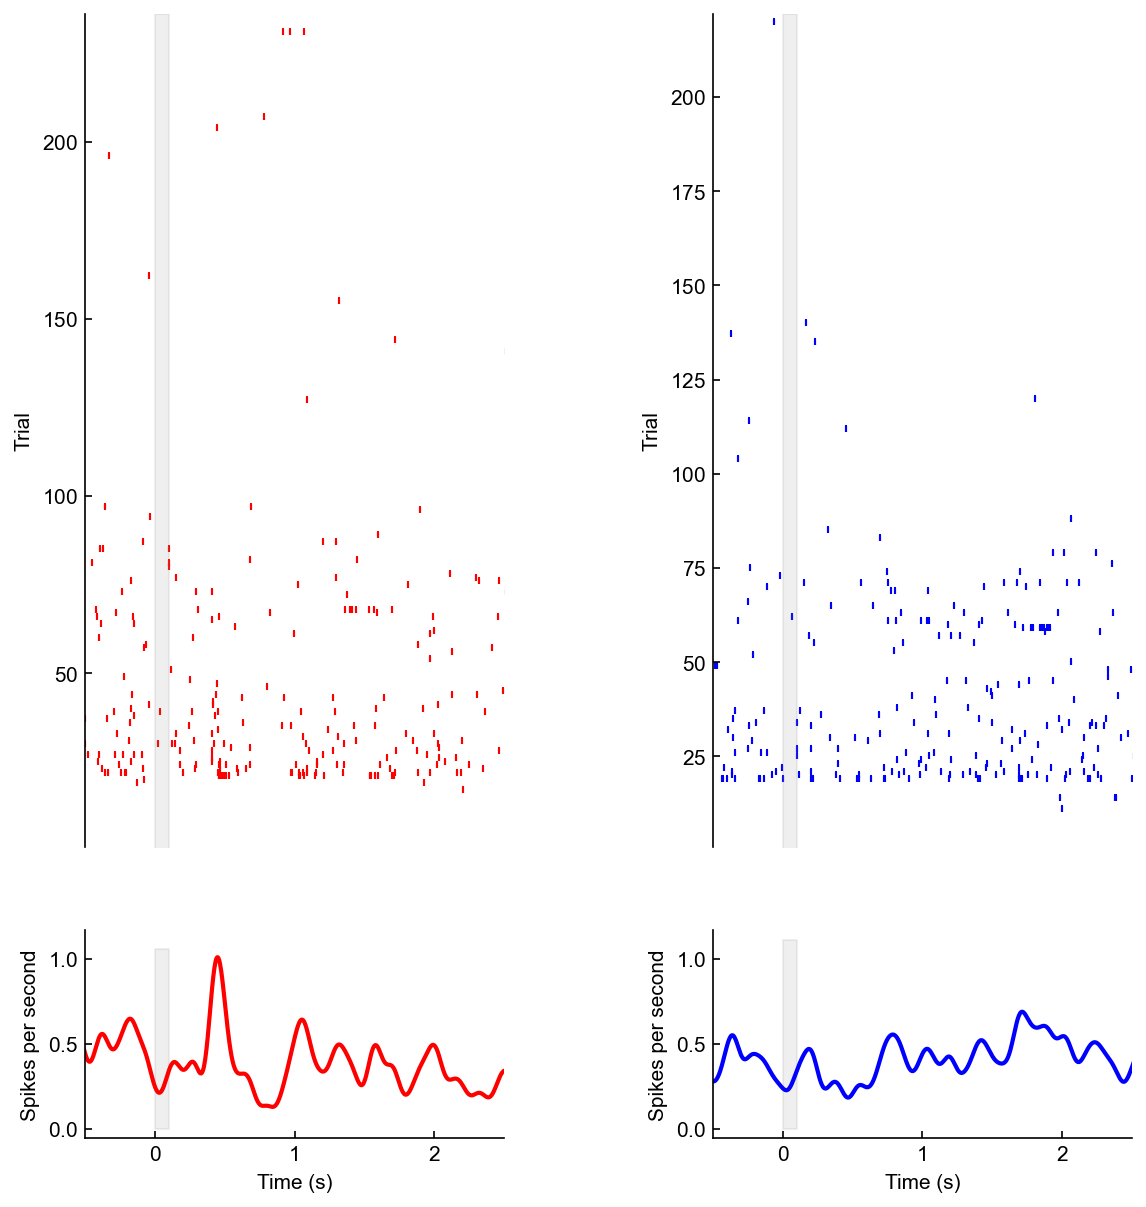

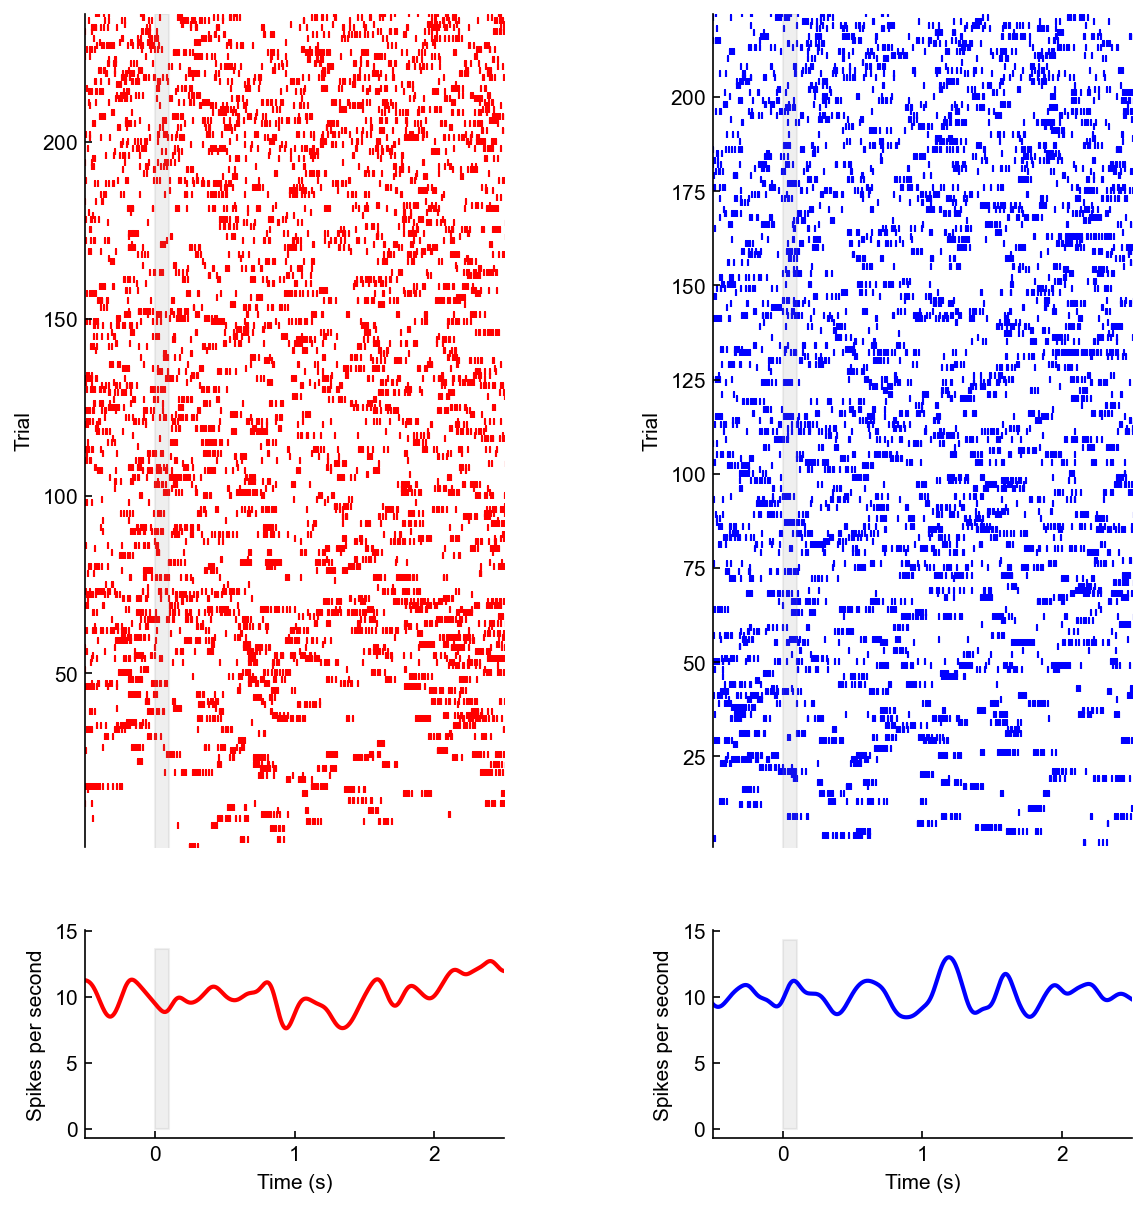

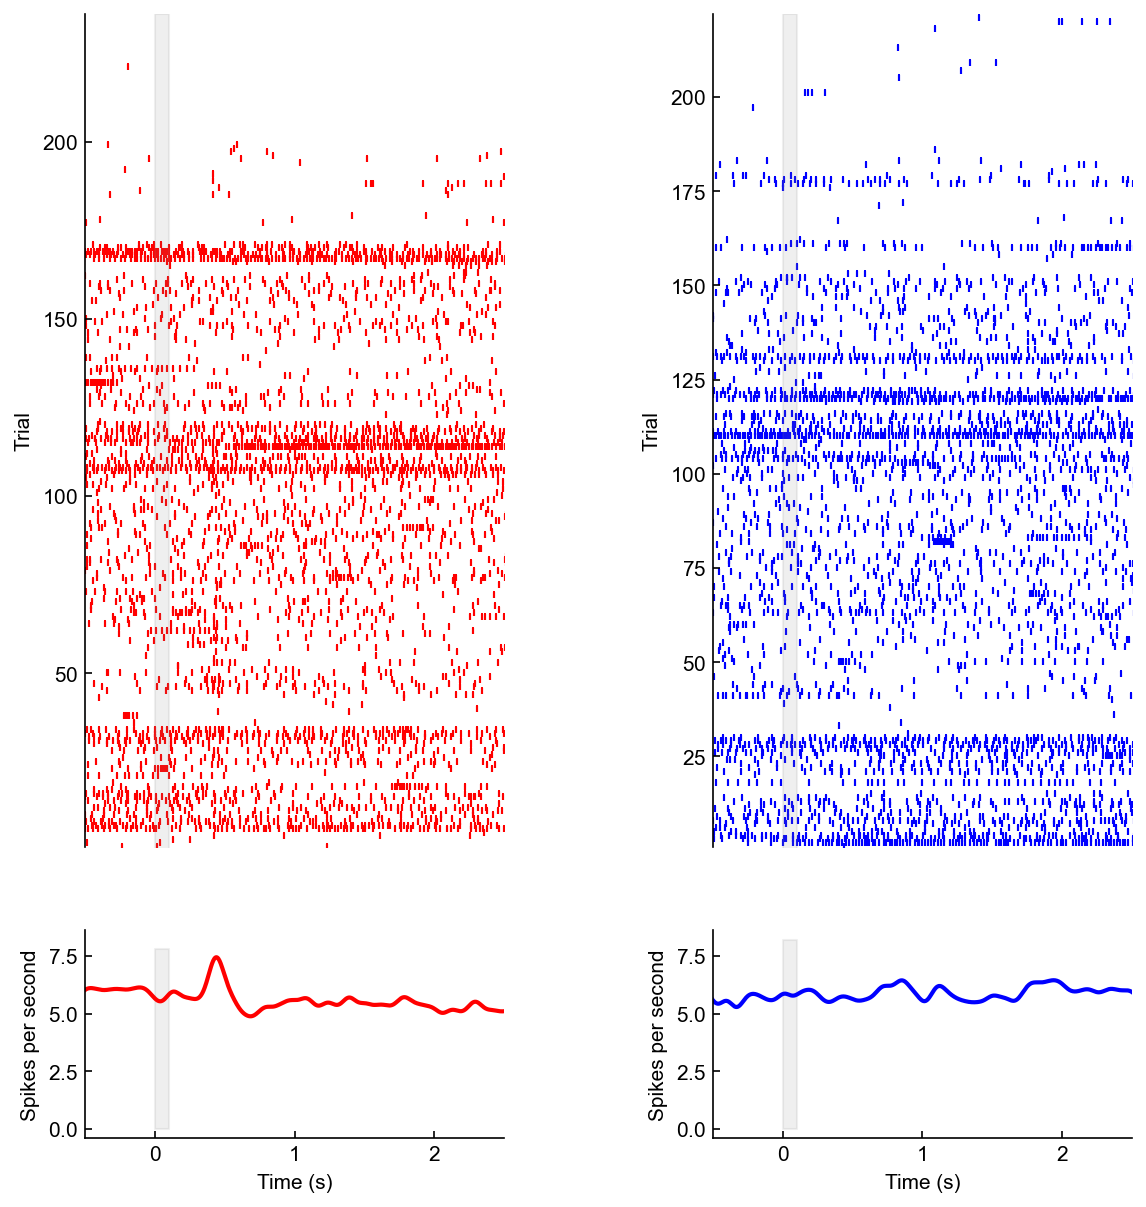

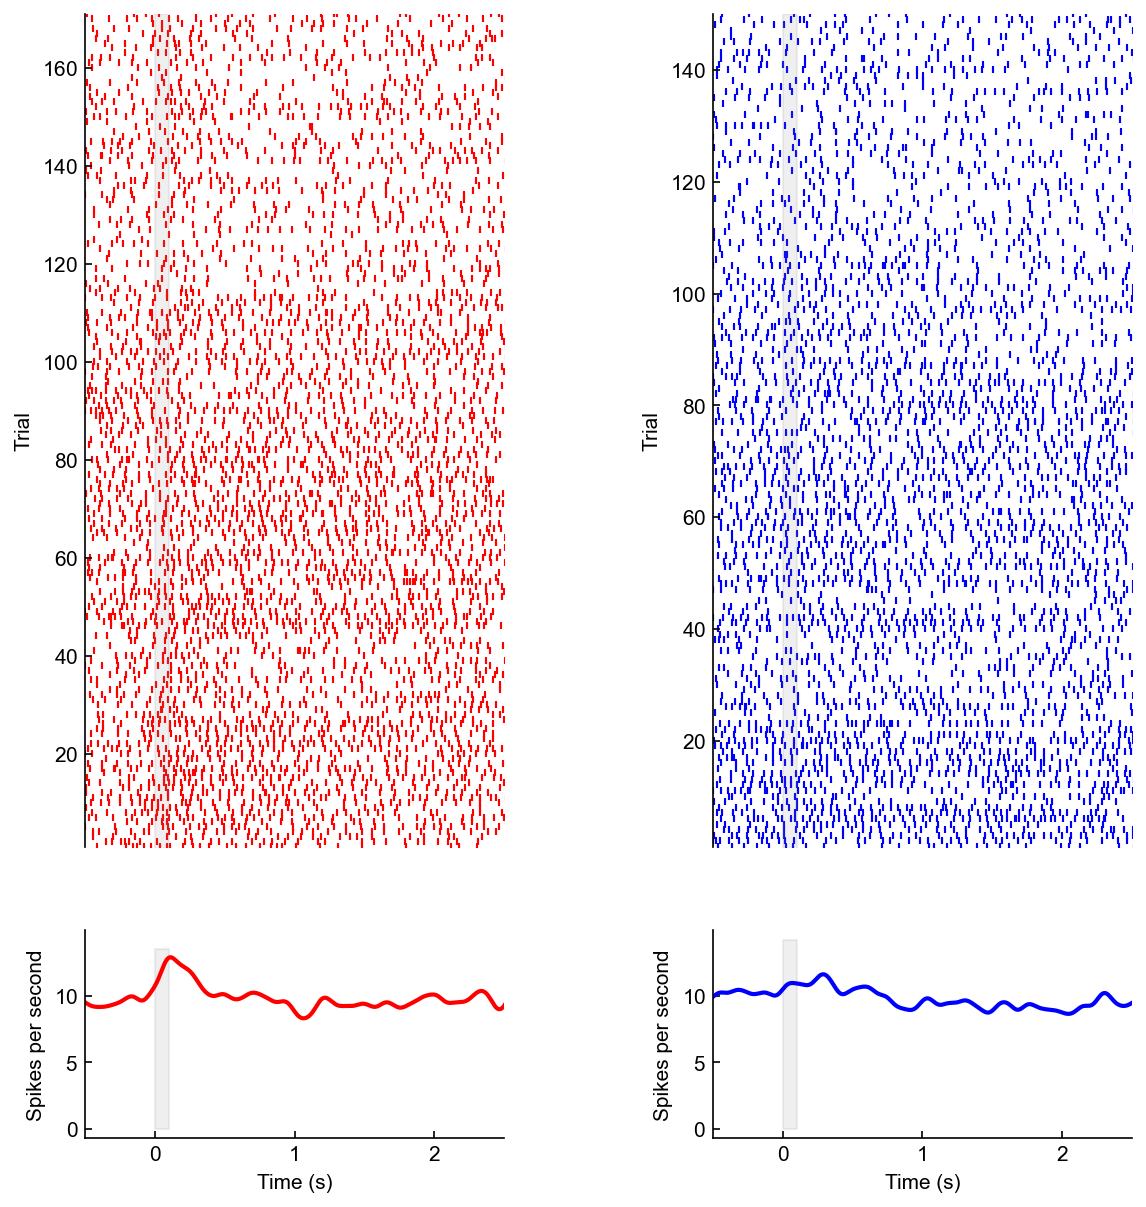

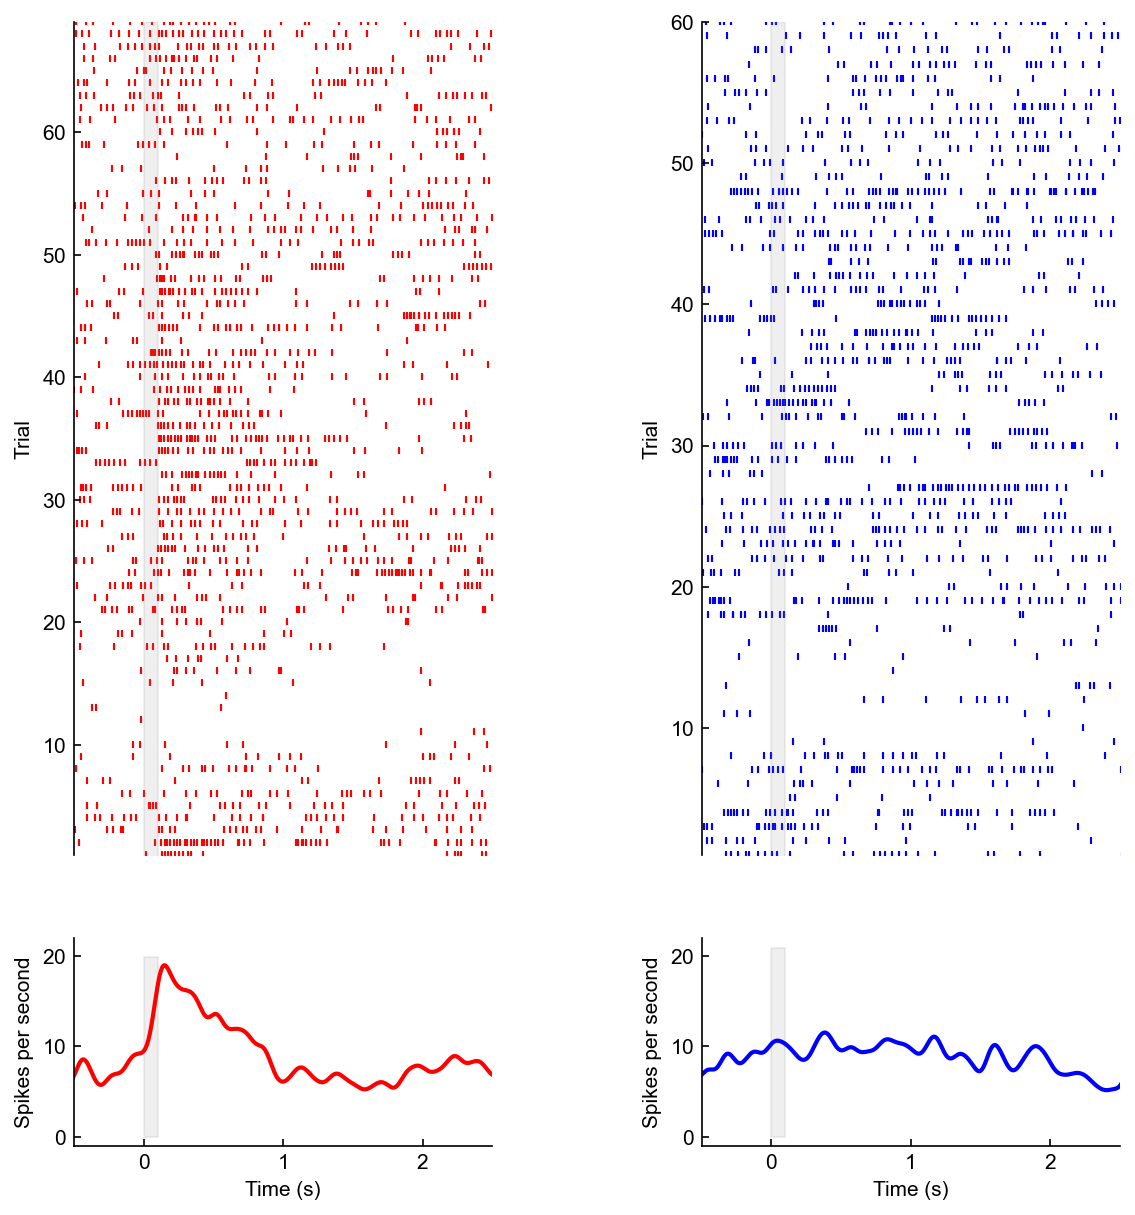

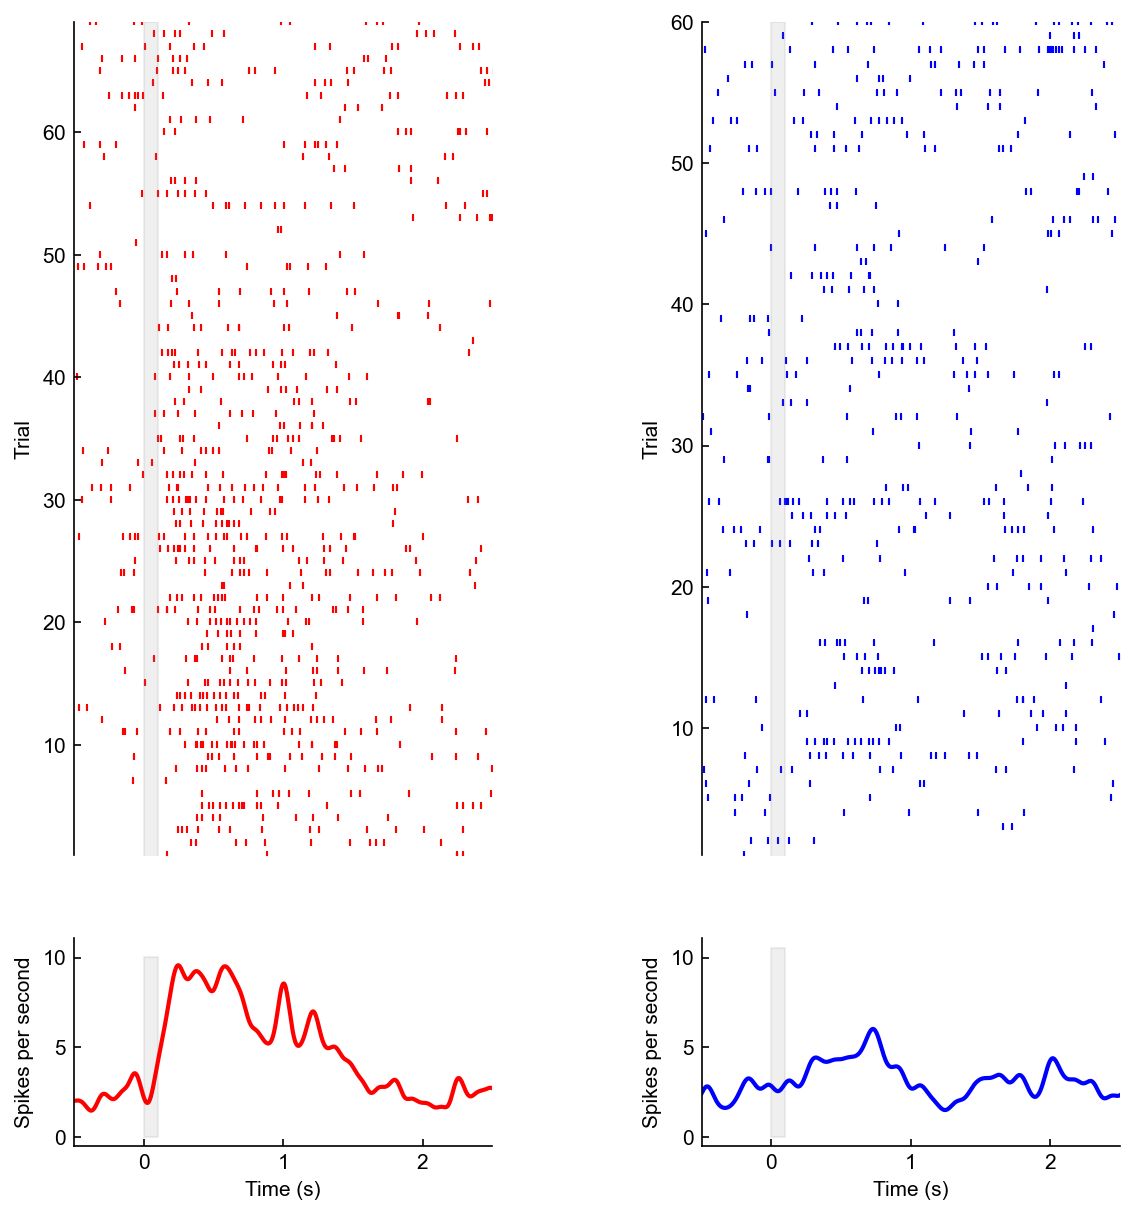

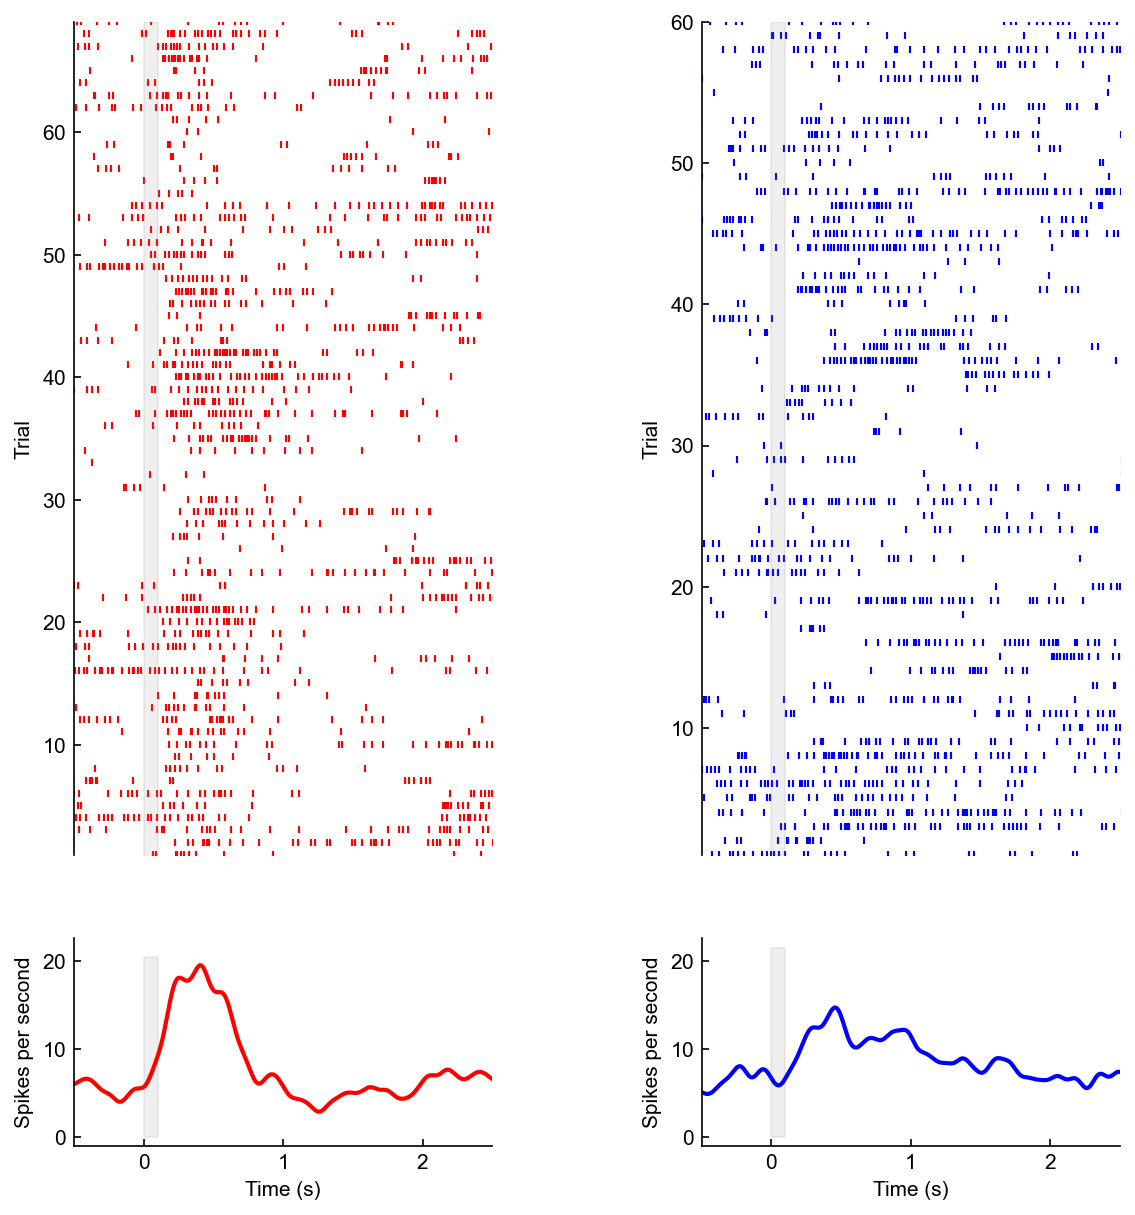

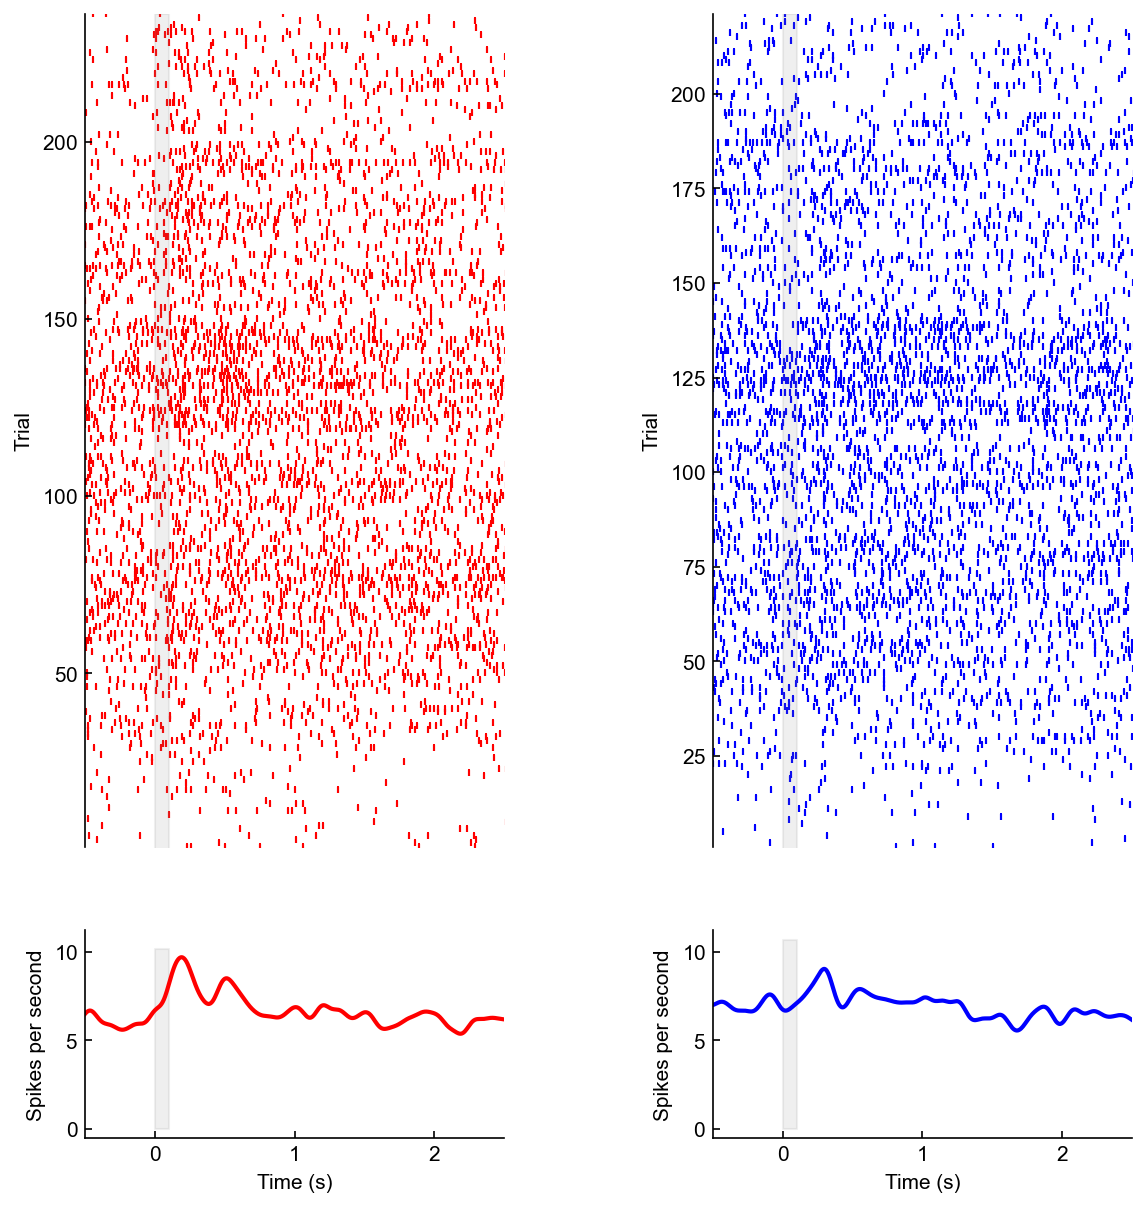

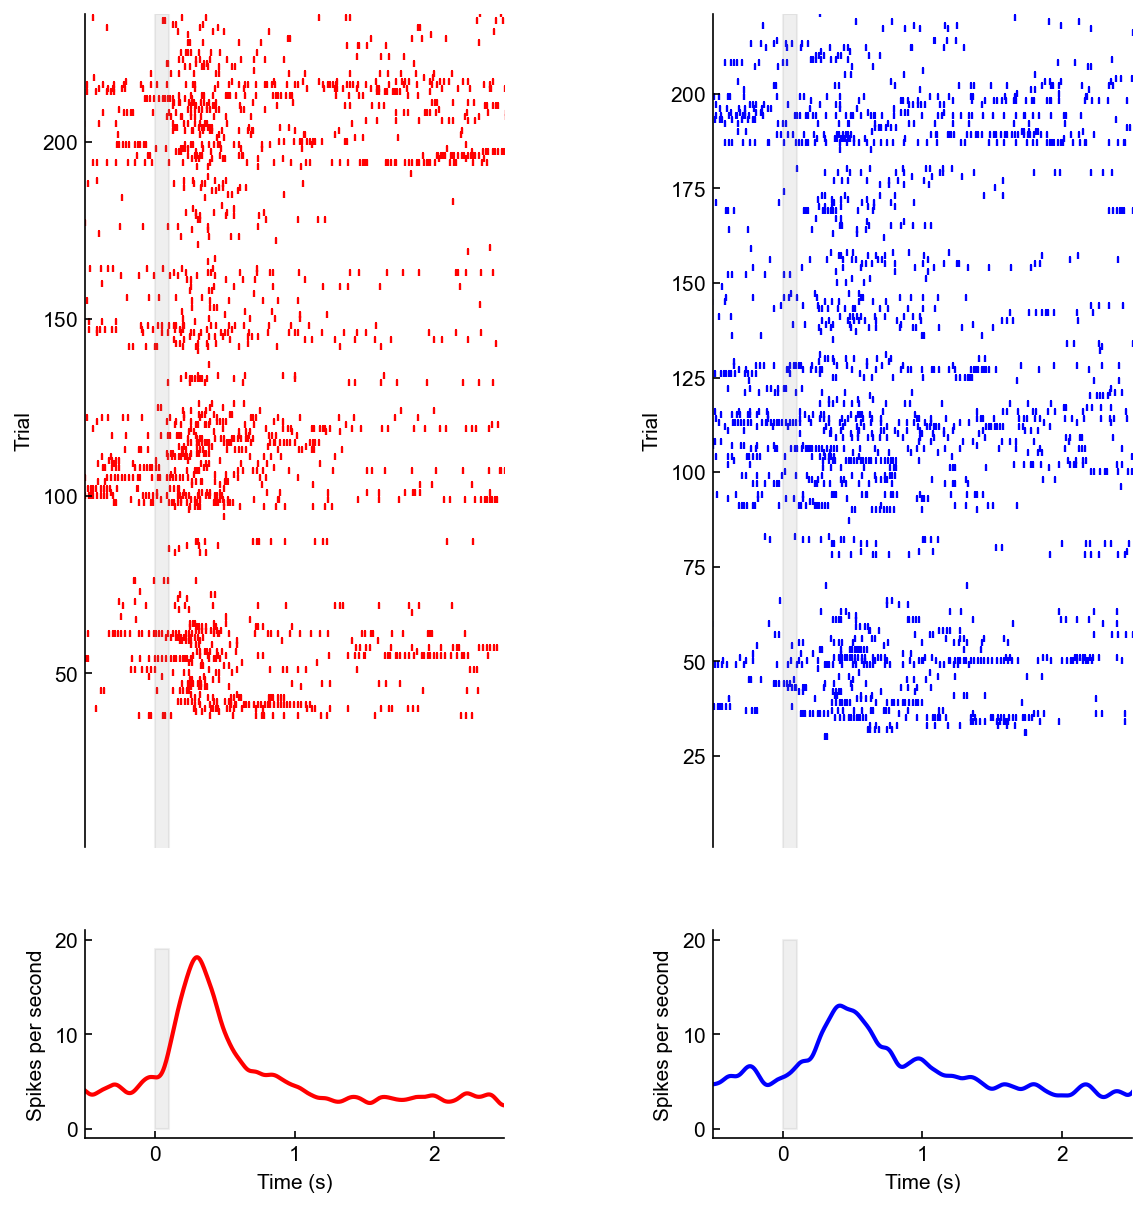

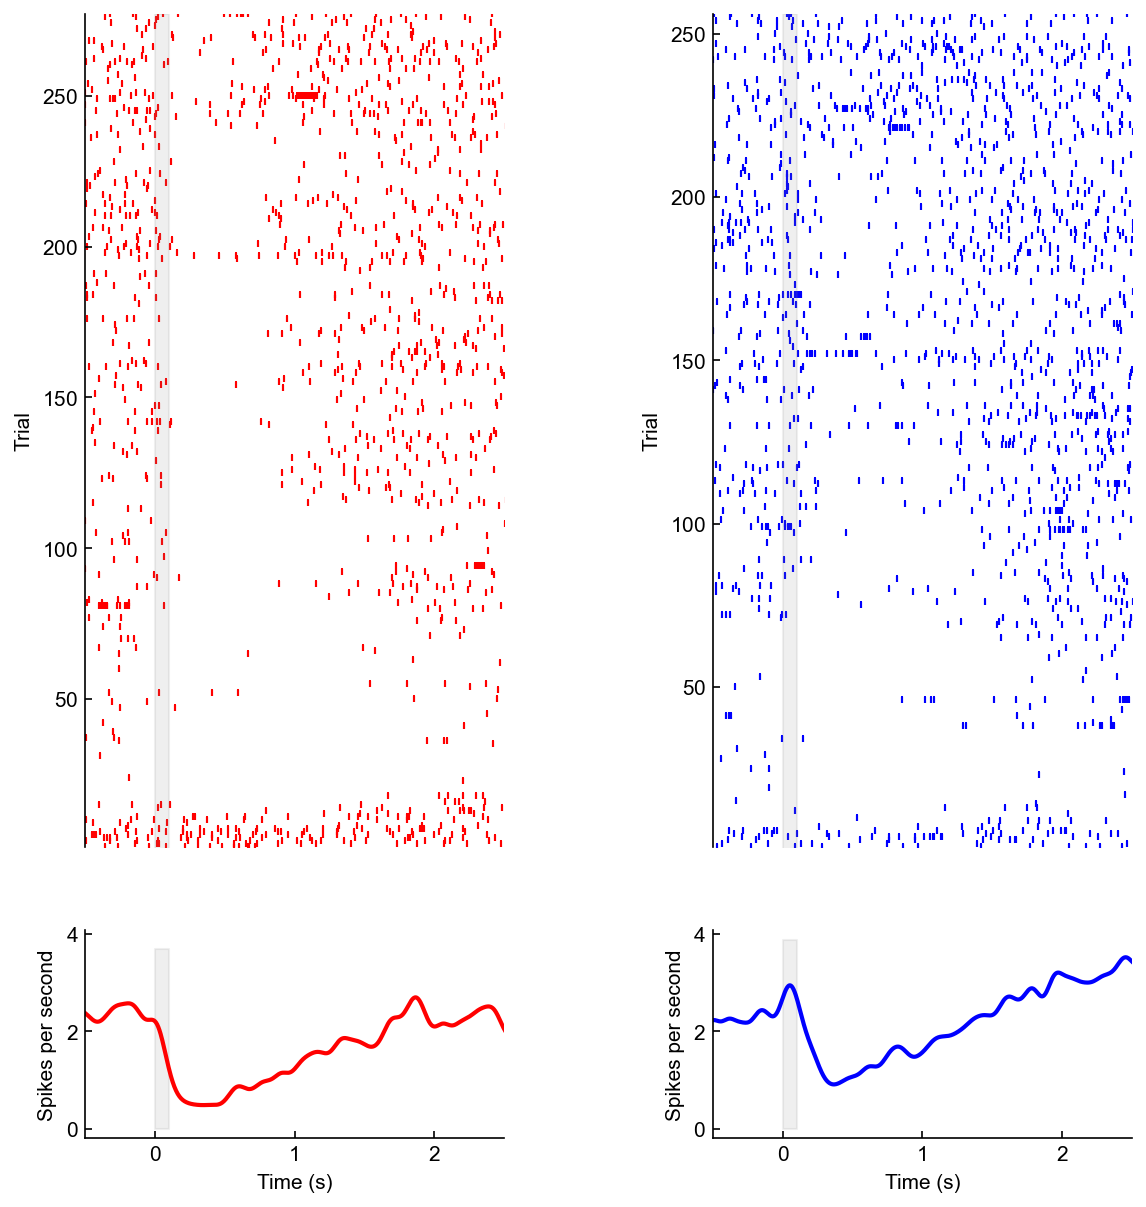

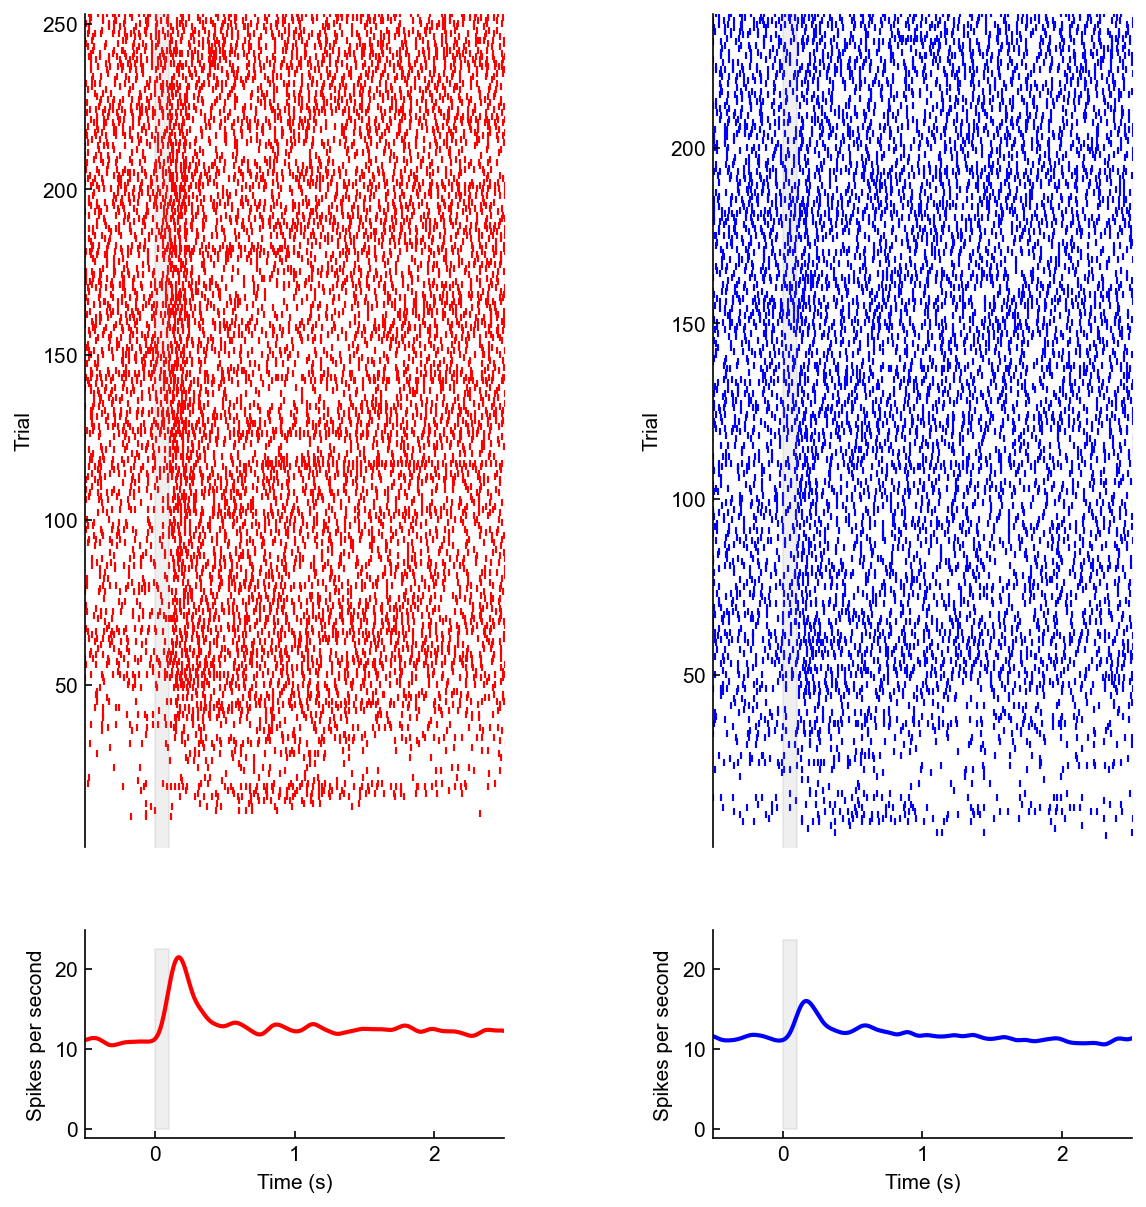

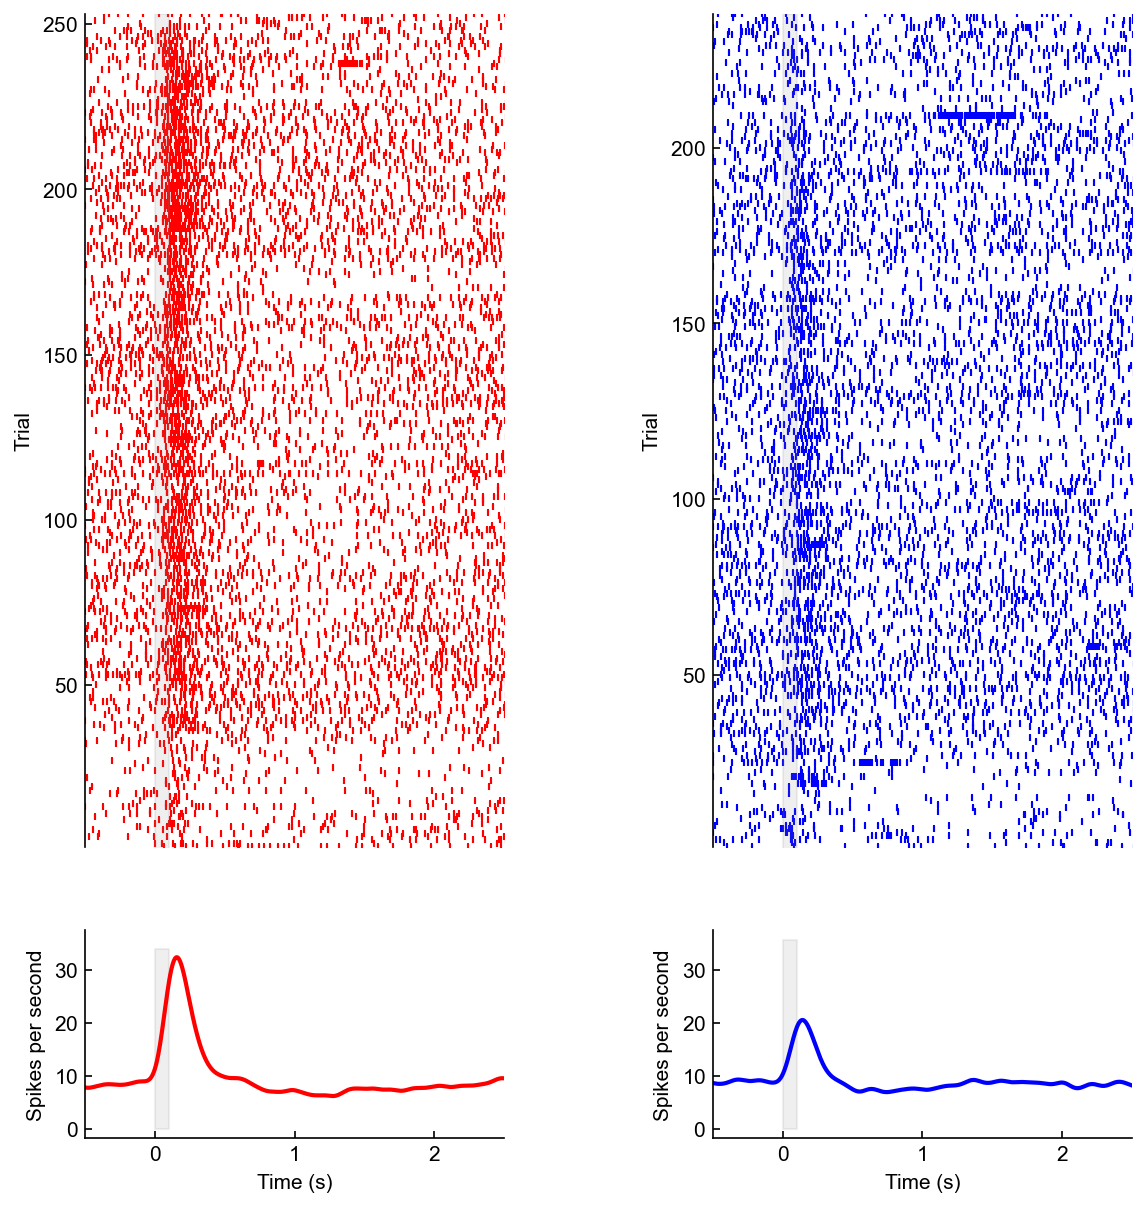

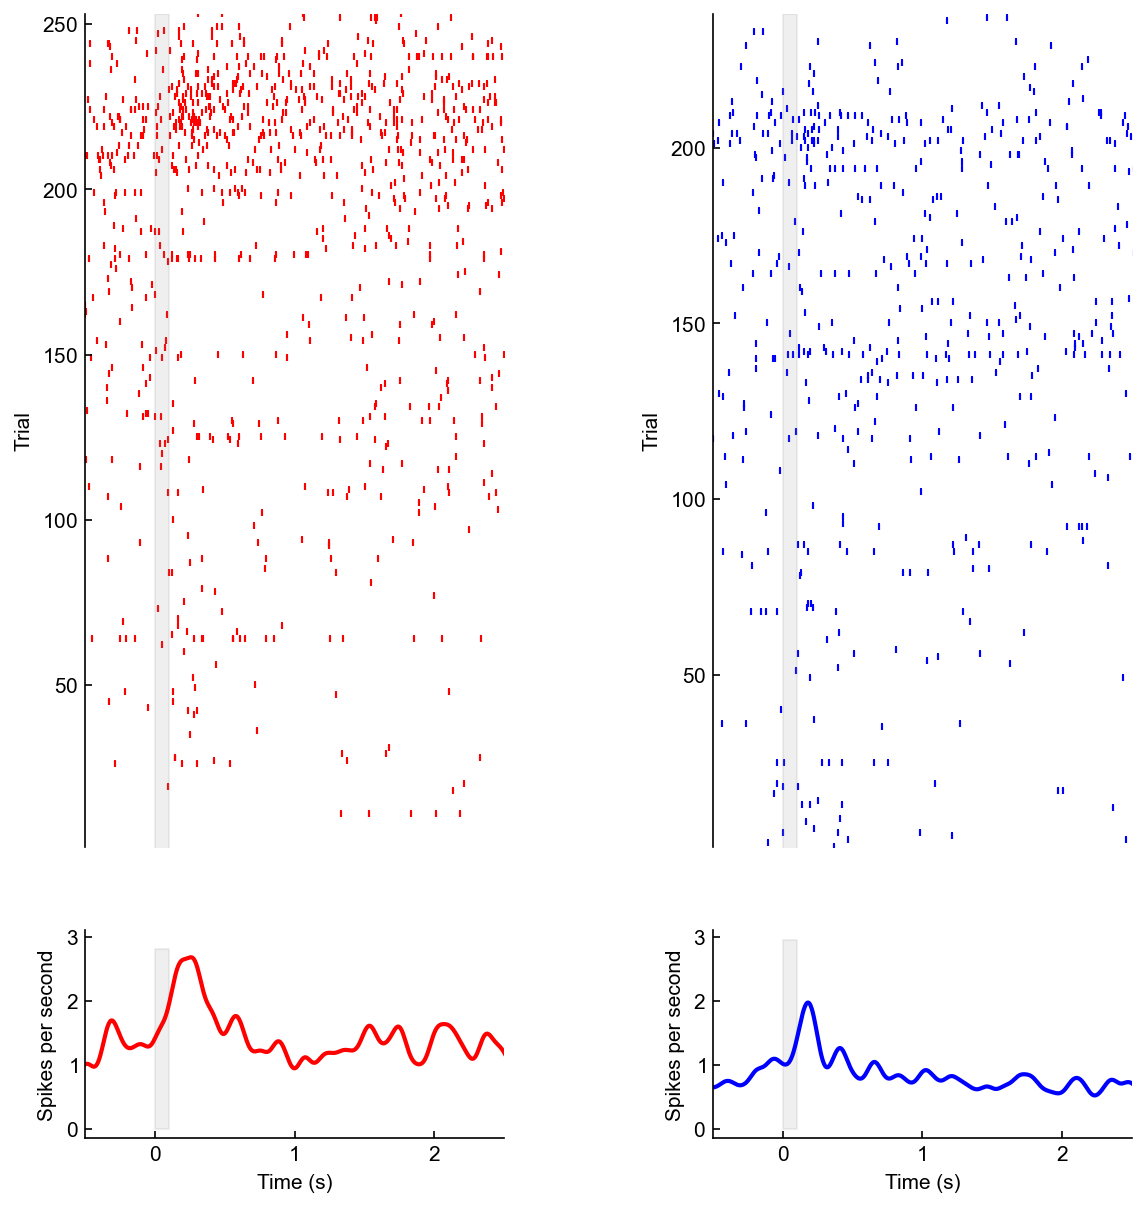

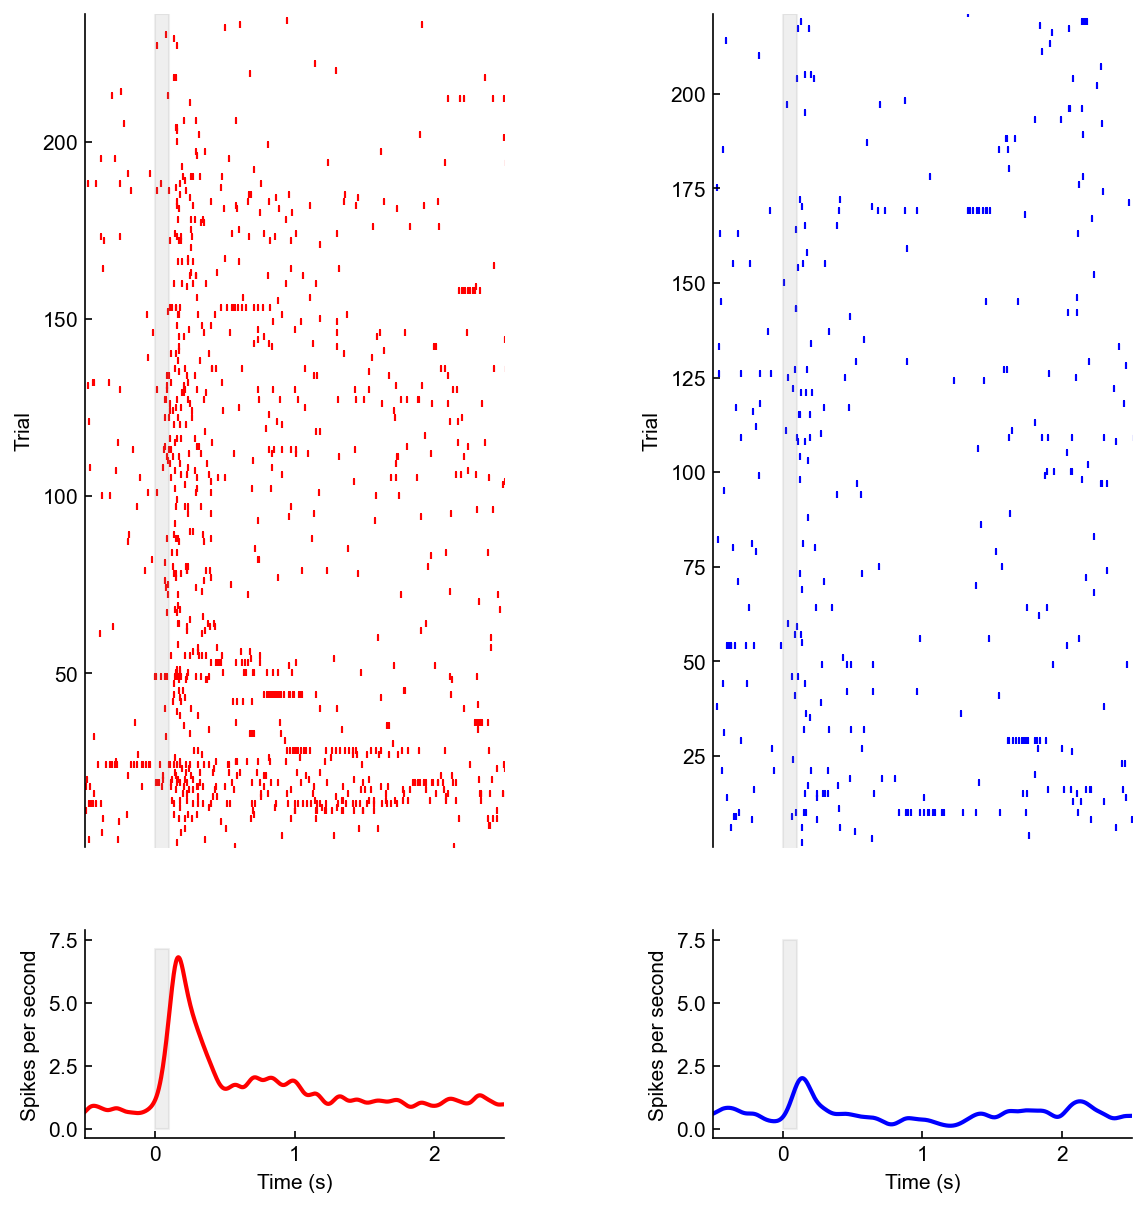

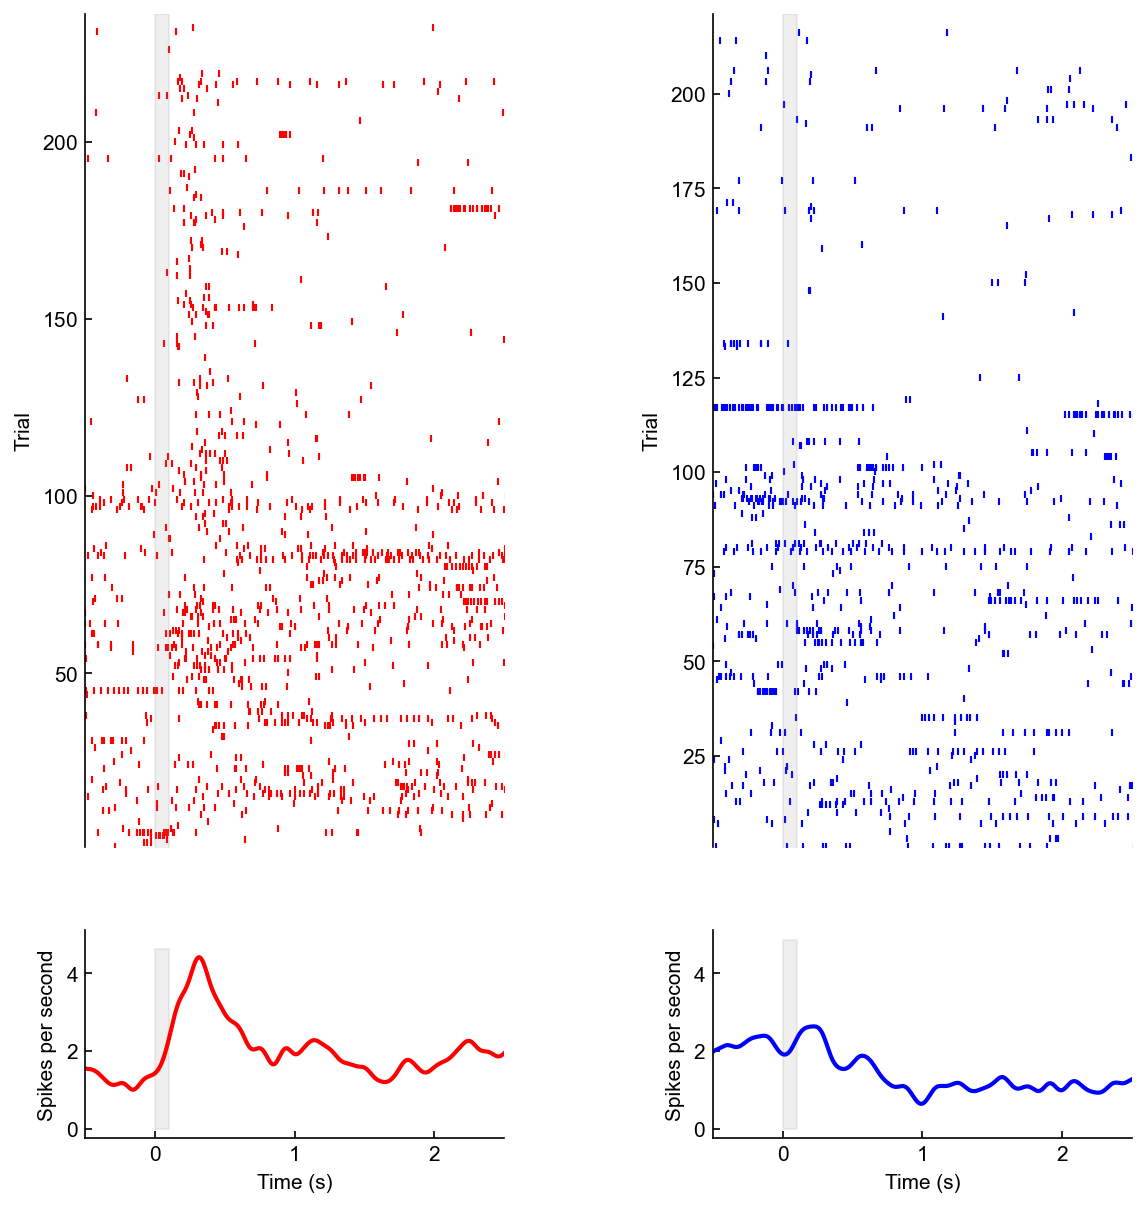

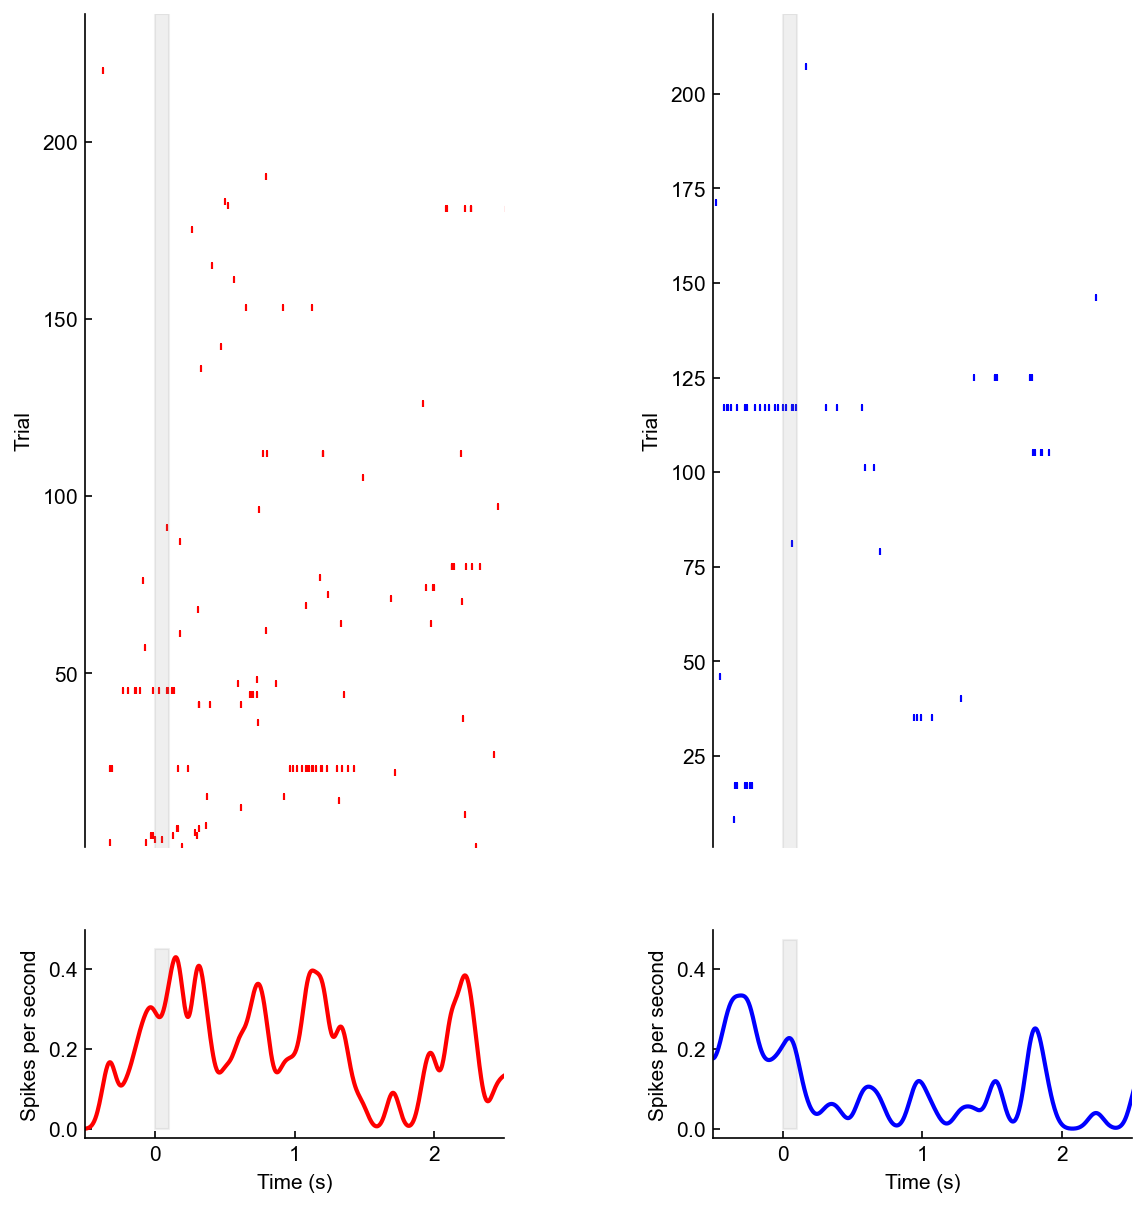

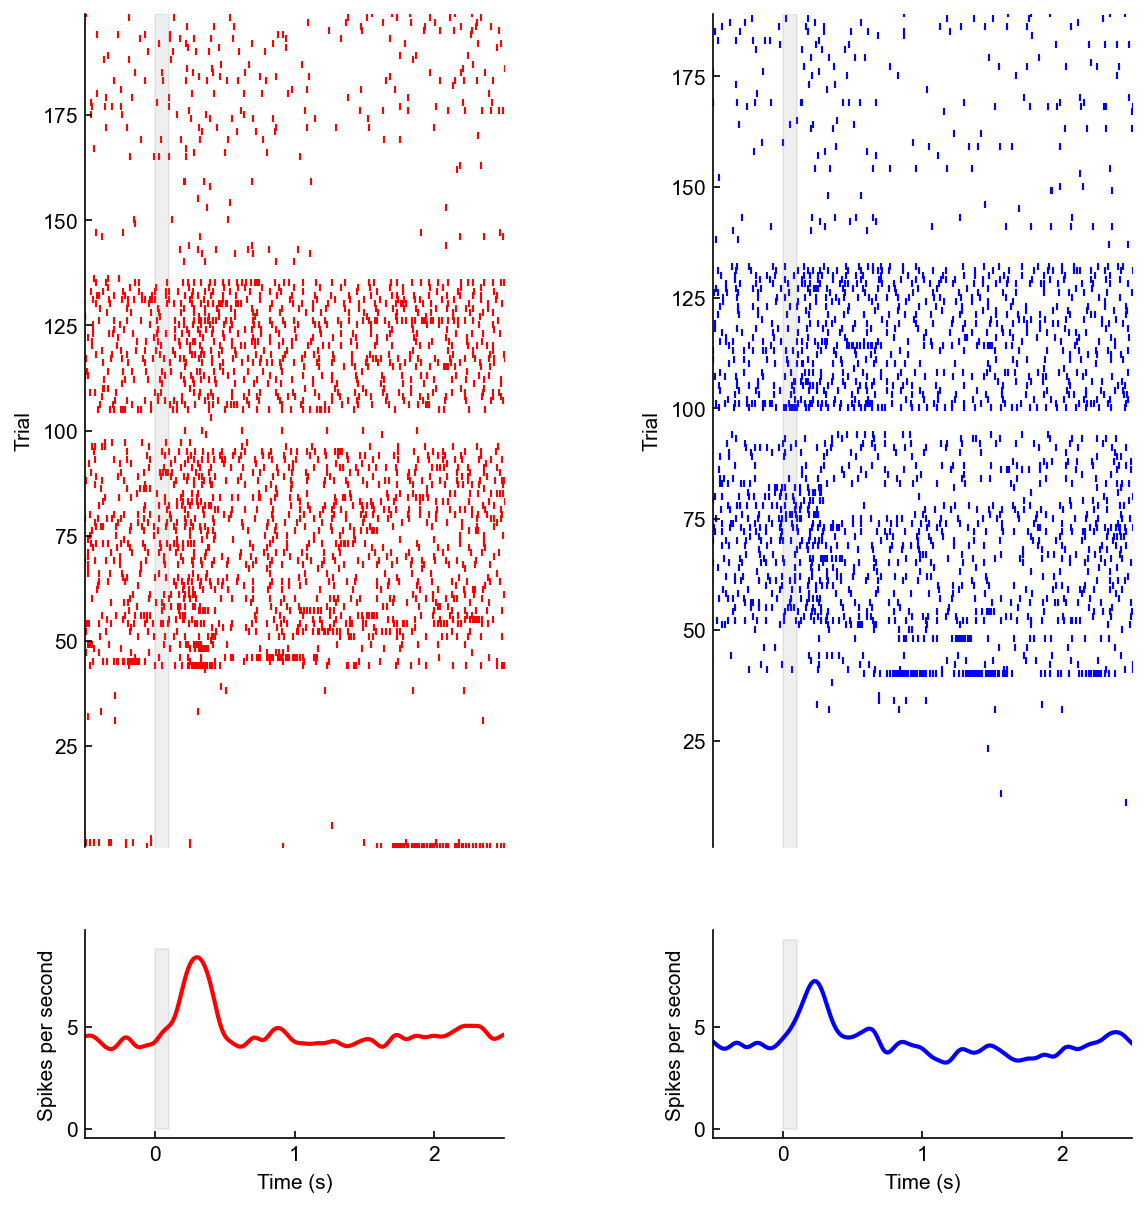

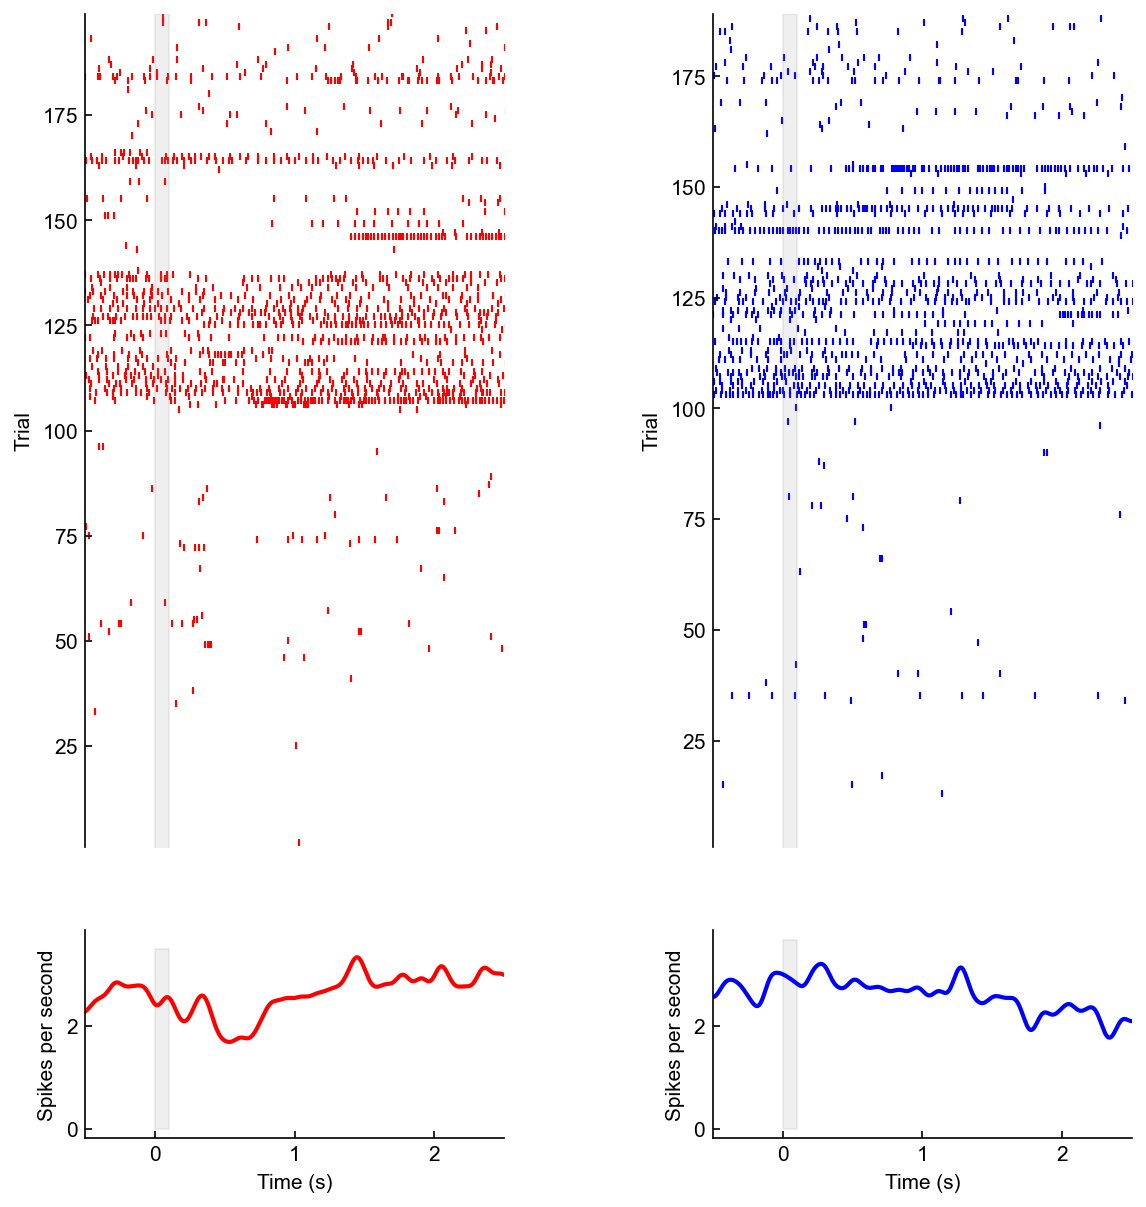

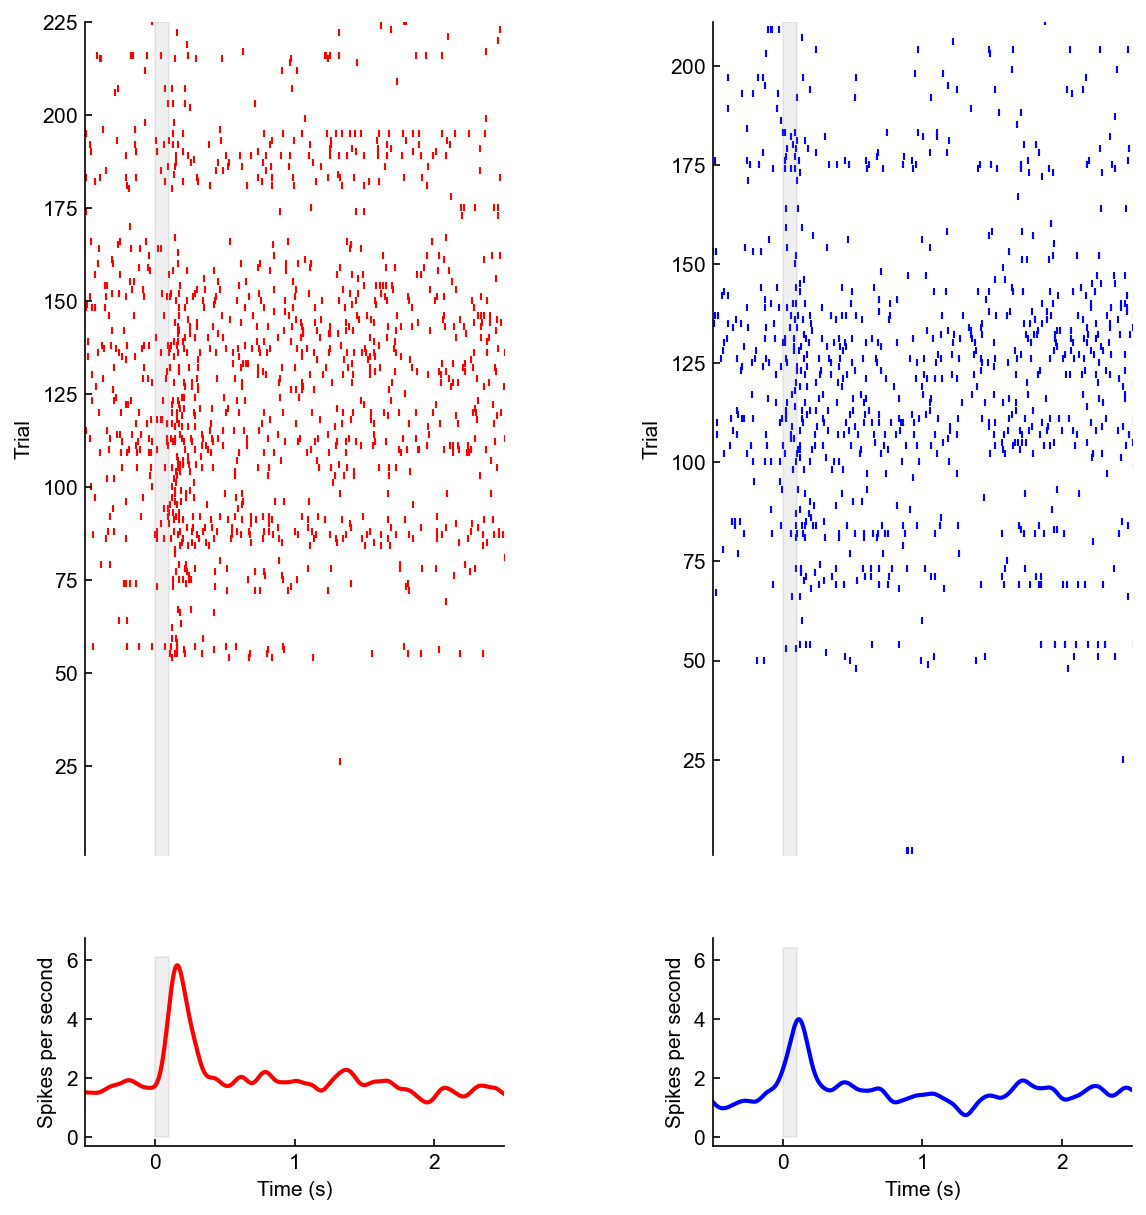

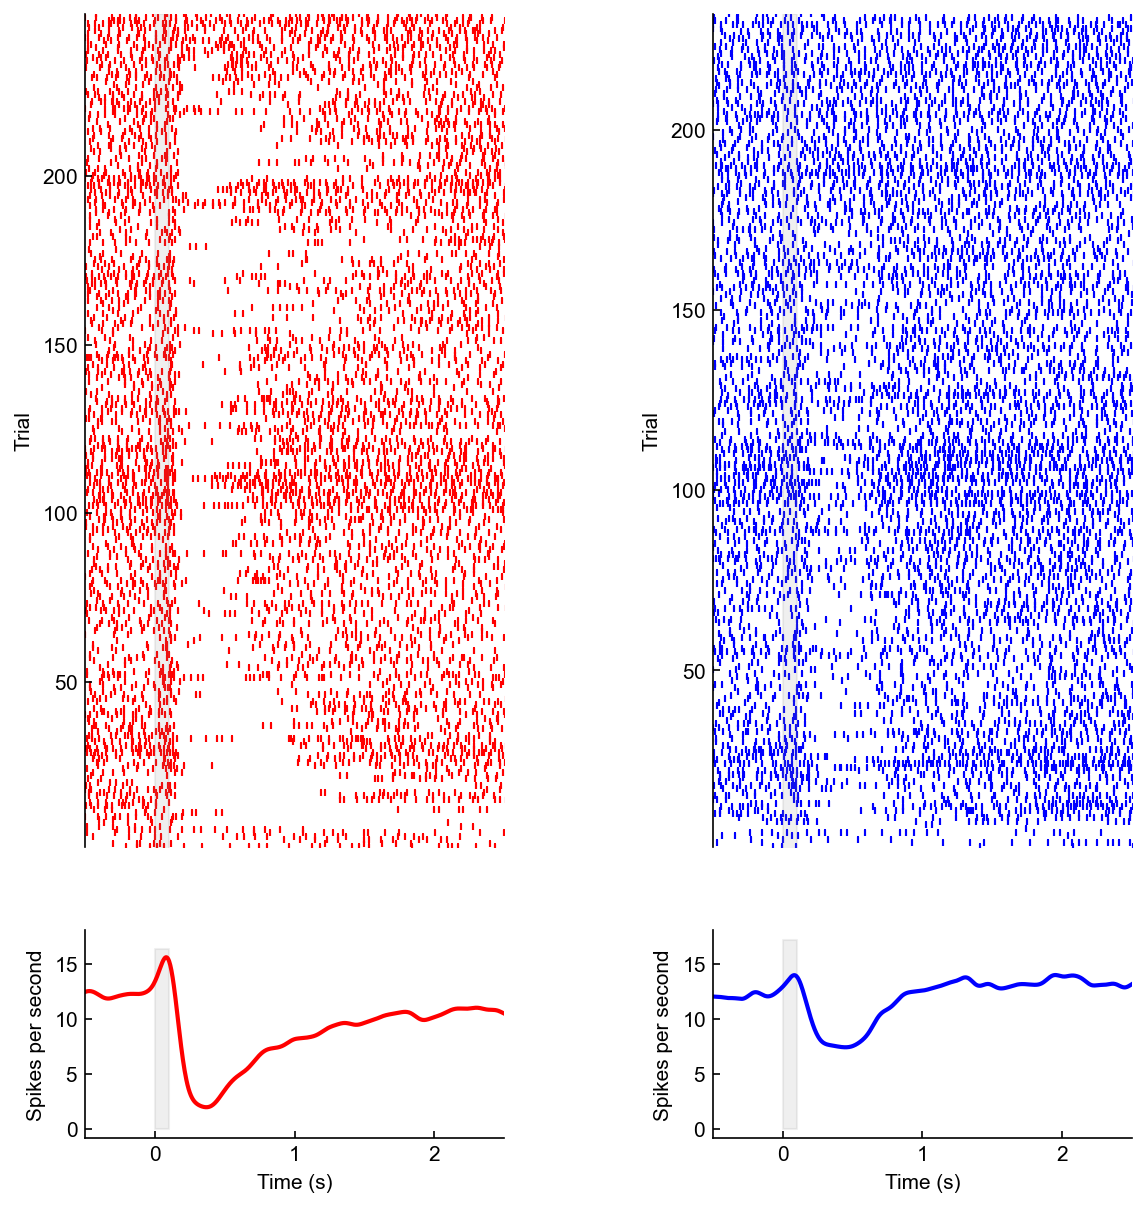

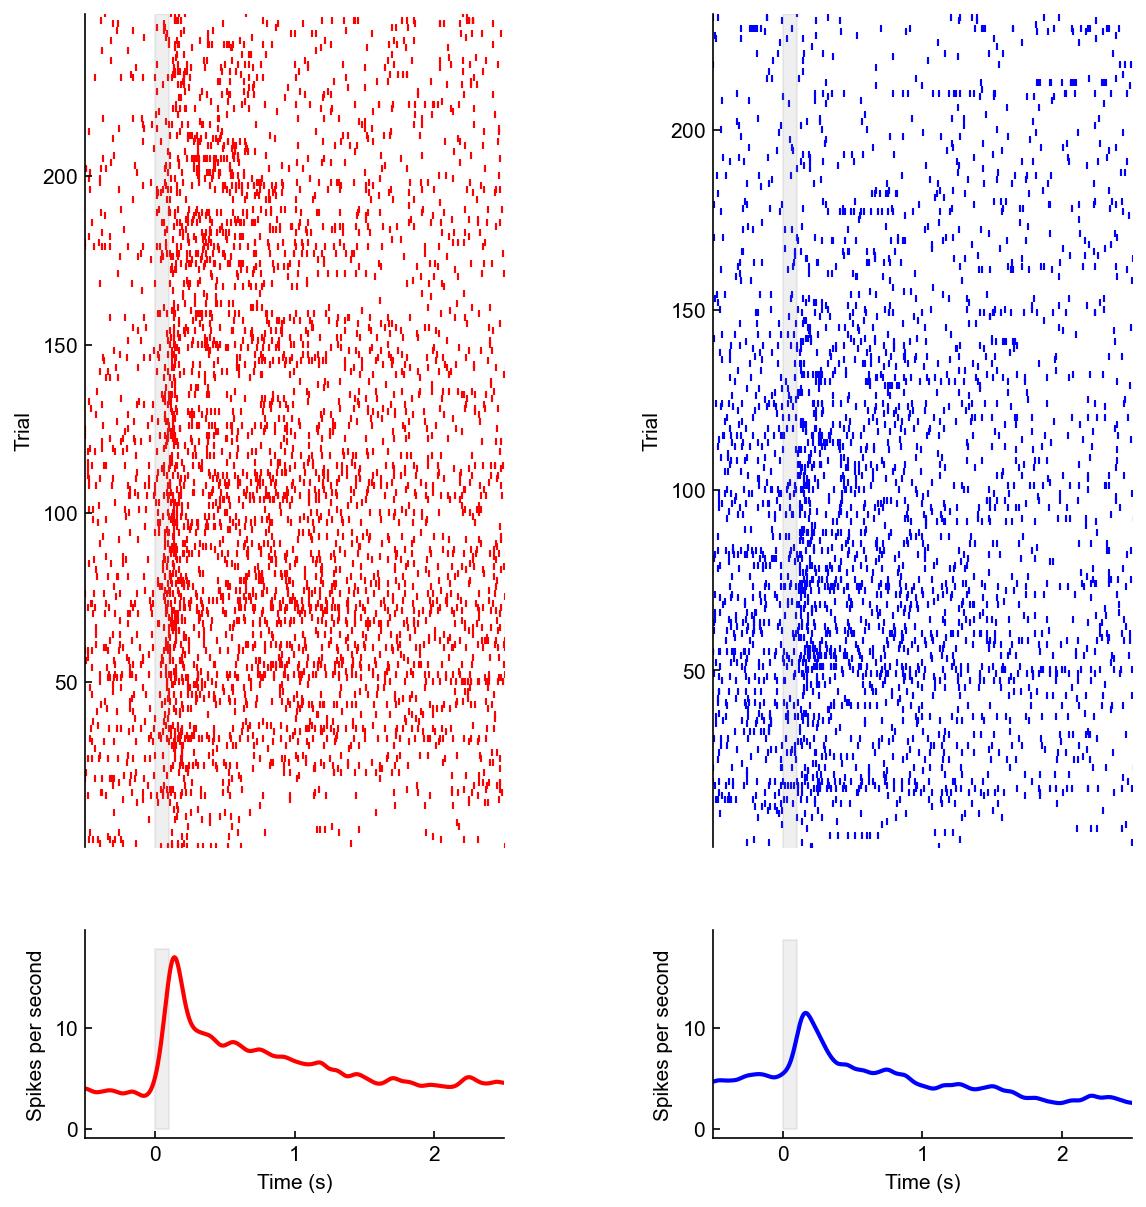

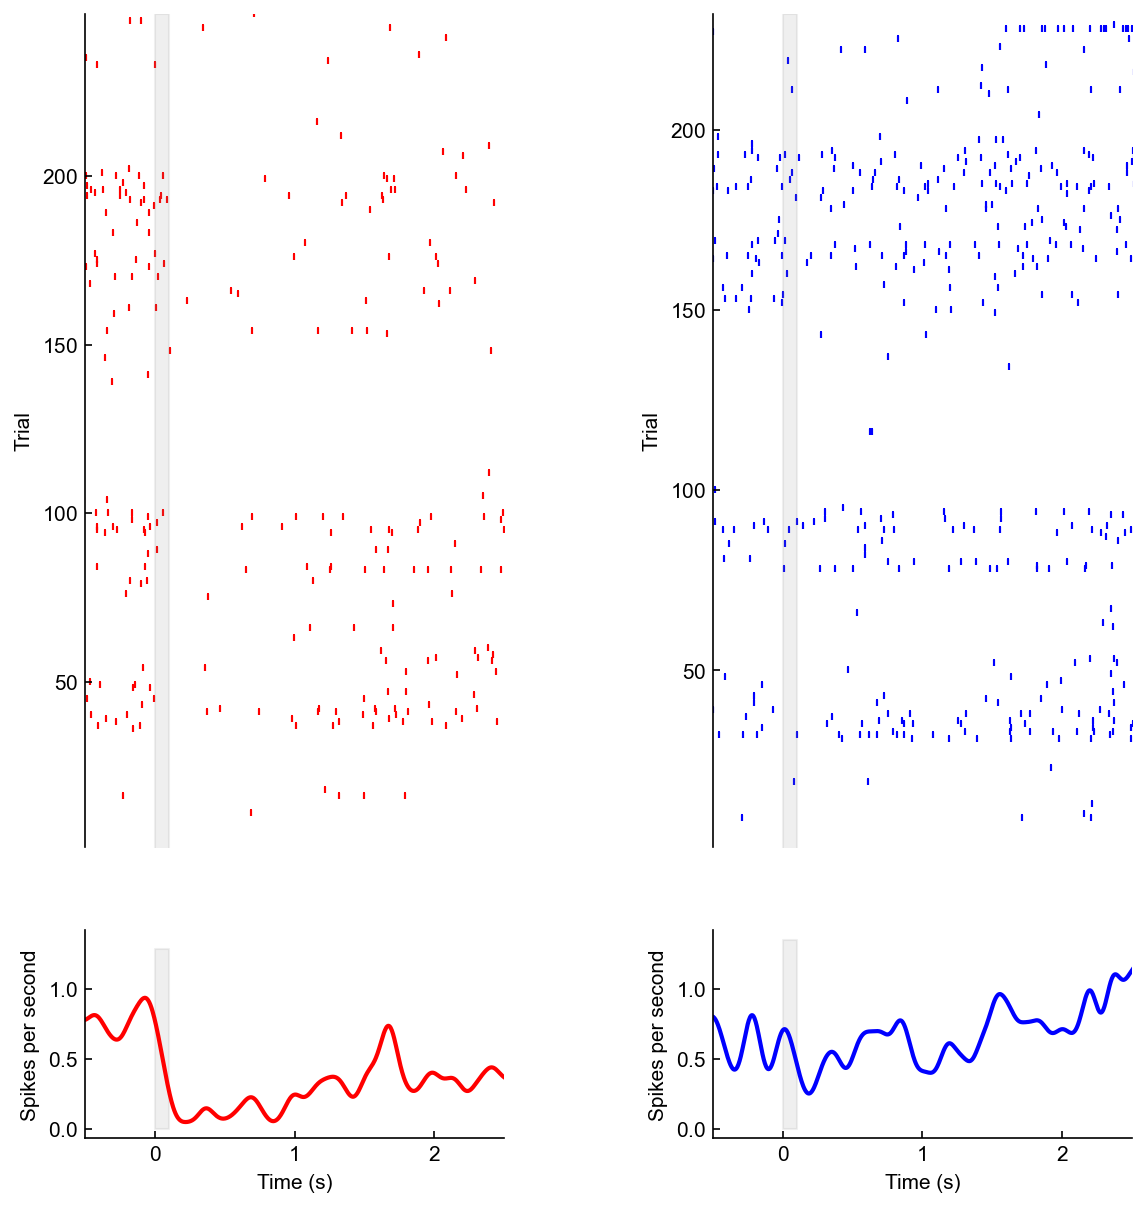

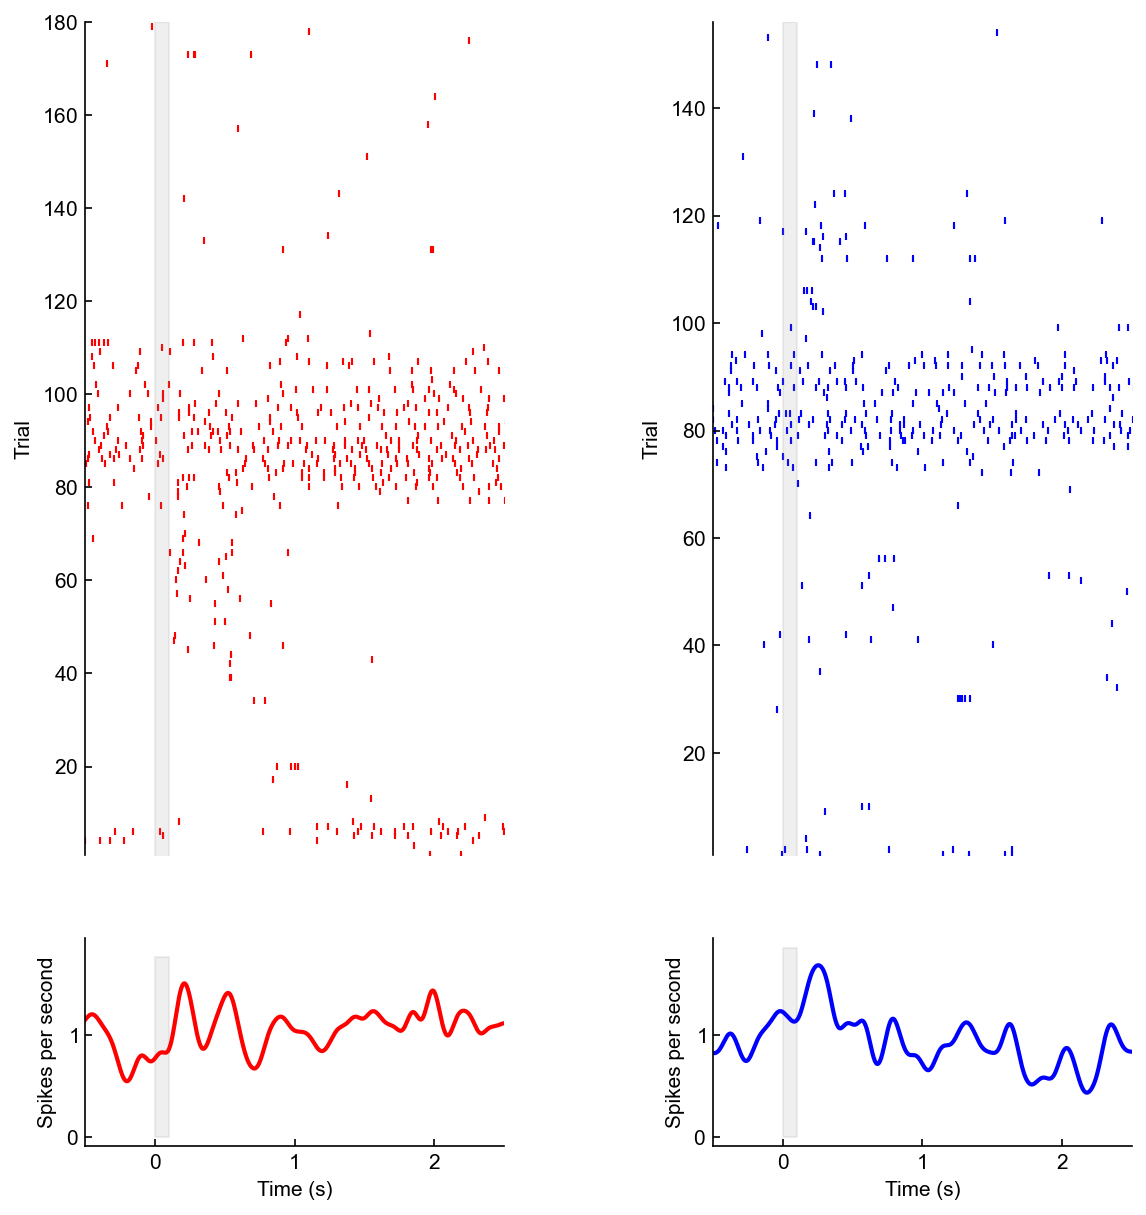

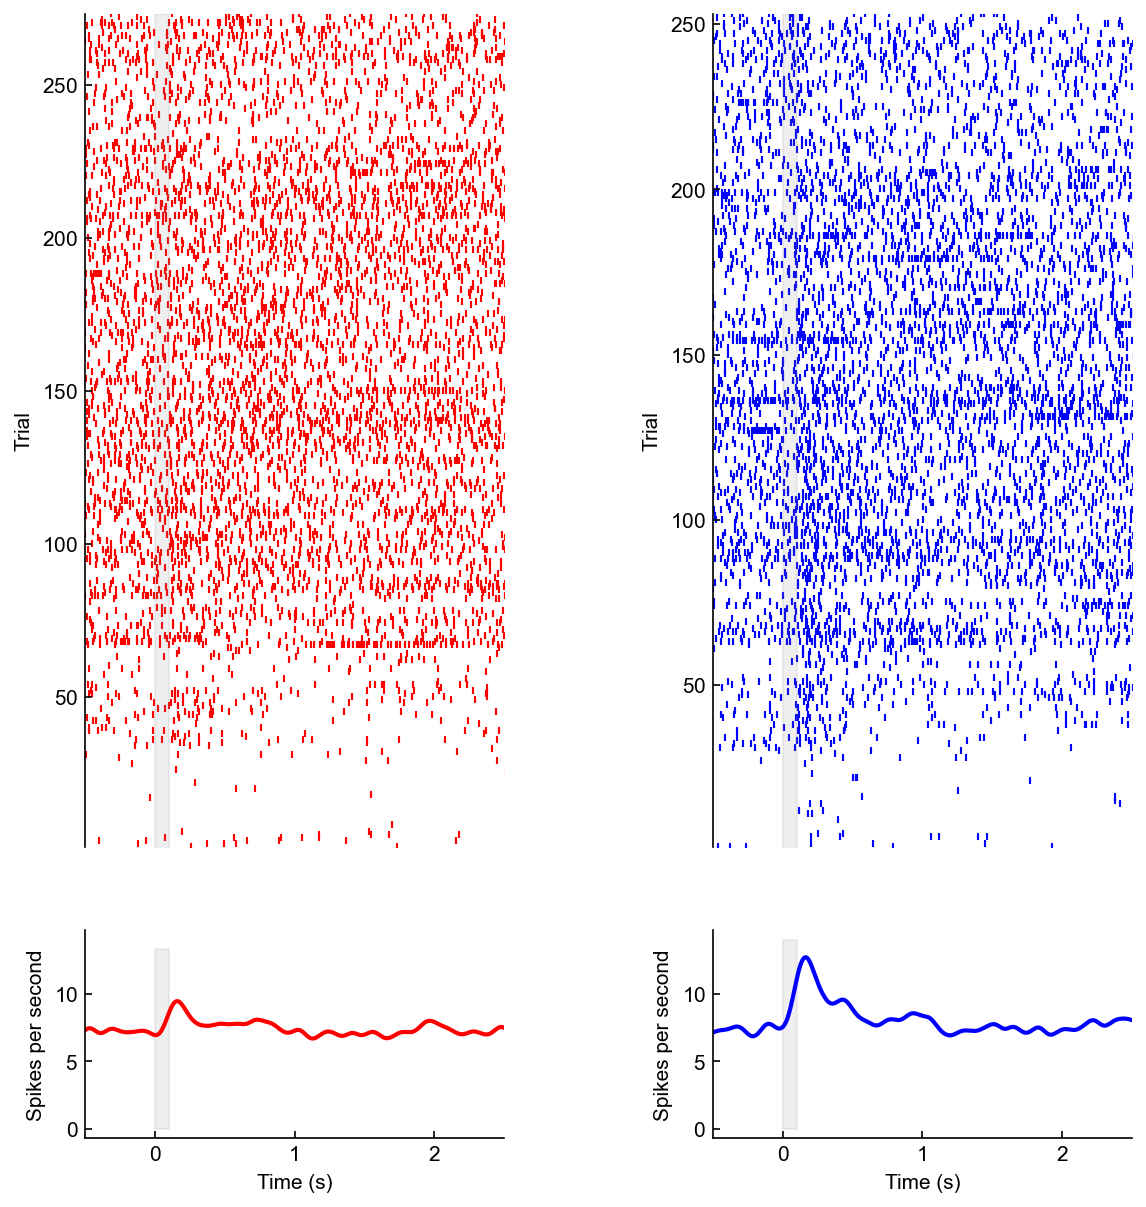

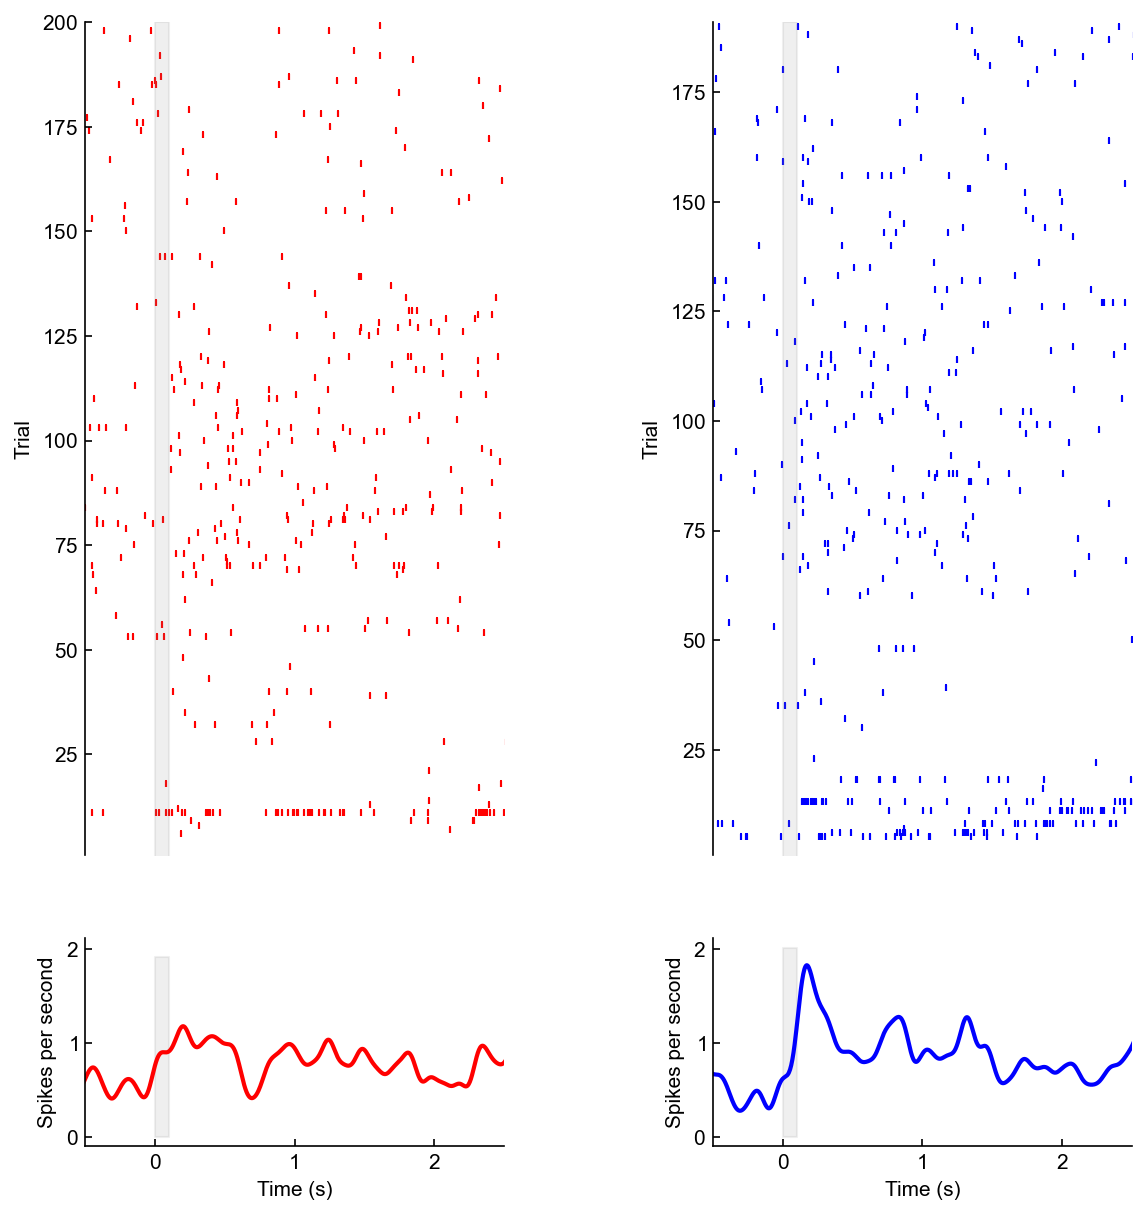

In [910]:
### SEPARATED BY GO/NOGO OR TARGET/NONTARGET

starttime = -0.7
endtime = 2.7
numbins = 100 + 1

height=10
width=1
trans=0.125
custommarker = mpl.path.Path([[-width,-height],[-width,height],[width,height],[width,-height]],closed=True)
    
for session in tqdm(sessions):
    #break
    try:
        sessionfile = loadSessionCached(destination,session)
        
        if not sessionfile.meta.animal == 'BS_70' and not sessionfile.meta.animal == 'BS_56' and not sessionfile.meta.animal == 'BS_50' and not sessionfile.meta.animal == 'BS_33':
            continue
        if not sessionfile.meta.region == 'M2':
            continue
        
        neurons = sessionfile.clusters.good
        
        ##########################################################################################################################
        #laserON = sessionfile.trials.laser_stimulation
        #laserOFF = np.logical_not(laserON)
        GoResponse = sessionfile.trials.go
        NogoResponse = np.logical_not(GoResponse)
        TargetTone = sessionfile.trials.target
        NontargetTone = np.logical_not(TargetTone)
        
        Hits = np.logical_and(TargetTone,GoResponse)
        Misses = np.logical_and(TargetTone,NogoResponse)
        FAlarms = np.logical_and(NontargetTone,GoResponse)
        CRejects = np.logical_and(NontargetTone,NogoResponse)
        Correct = np.logical_or(Hits,CRejects)
        Incorrect = np.logical_or(Misses,FAlarms)
        
        #Condition A
        conditionA = SimpleNamespace()
        conditionA.trials = (TargetTone)
        conditionA.label = 'Target'
        conditionA.color = 'red'
        #Condition B
        conditionB = SimpleNamespace()
        conditionB.trials = (NontargetTone)
        conditionB.label = 'Nontarget'
        conditionB.color = 'blue'

        conditions = [conditionA,conditionB]
        #Convert trials into idxs -- more useful for algorithm
        for cond in conditions:
            cond.trials = np.array(np.where(cond.trials)[0])
        ##########################################################################################################################
        totaltrials = 0
        for cond in conditions:
            totaltrials += len(cond.trials)
        
        for clust in neurons:
            if not clust==25 and not clust==44 and not clust==71 and not clust==36:
                continue
            
            #plt.close('all')
            fig = plt.figure(figsize=(9,12.5))
            gs = fig.add_gridspec(3,2,height_ratios=[4,1,1],hspace=0.2,wspace=0.5)#0.1)
                
            ax1 = plt.subplot(gs[0,0])#Raster
            ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
            ax3 = plt.subplot(gs[0,1],sharex=ax1)#FRs
            ax4 = plt.subplot(gs[1,1],sharex=ax1,sharey=ax2)#Percent Go
                        
            ax1.spines['bottom'].set_visible(False)
            ax3.spines['bottom'].set_visible(False)
            ax1.get_xaxis().set_visible(False)
            ax3.get_xaxis().set_visible(False)
            
            #Caching search -- Unit
            idx = np.equal(sessionfile.spikes.clusters,clust)
            totaltimes = sessionfile.spikes.times[idx]
            
            FRpertrial = []
            #Overall Nonstationarity
            for trial in range(sessionfile.meta.length_in_trials):
                trialstart = sessionfile.trials.starts[trial]
                trialend = sessionfile.trials.ends[trial]
                idxtone = np.logical_and(   np.greater(totaltimes,trialstart) , np.less(totaltimes,trialend)  )
                timestone = totaltimes[idxtone]
                trialtime = (trialend-trialstart) / sessionfile.meta.fs
                FRpertrial.append(len(timestone) / trialtime)
            
            for cond in conditions:         
                cond.latency = []
                cond.firingrates = []
                cond.timestoplot = []
                cond.trialstoplot = []
                cond.responsetimestoplot = []
                cond.responsetrialstoplot = []
                cond.peristimulustimes = []
                cond.onsetmodulation = np.nan
                cond.offsetmodulation = np.nan
                cond.pc = np.nan
                cond.dp = np.nan
                
                cond.firingbins100 = []
                cond.firingbins200 = []
                
                pretonebin1 = []
                pretonebin2 = []
                tonebin = []
                posttonebin = []
                
                #Calculate Behavior Stats
                temparray = np.zeros(sessionfile.meta.length_in_trials)
                temparray[cond.trials] = np.ones(len(cond.trials))
                condhits = np.sum(np.logical_and(temparray,Hits))
                condmisses = np.sum(np.logical_and(temparray,Misses))
                condfalarms = np.sum(np.logical_and(temparray,FAlarms))
                condcrejects = np.sum(np.logical_and(temparray,CRejects))
                
                try:
                    cond.pc = (condhits+condmisses) / (condhits+condmisses+condfalarms+condcrejects)
                except Exception:
                    pass
                try:
                    cond.dp = norm.ppf((condhits+1)/(condhits+condmisses+2)) - norm.ppf((condfalarms+1)/(condfalarms+condcrejects+2))
                except Exception:
                    pass
                
                for trialidx in range(len(cond.trials)):
                    trial = cond.trials[trialidx]
                    trialstart = sessionfile.trials.starts[trial]
                    
                    #Caching search -- Condition
                    idx = np.logical_and(      np.greater(totaltimes,trialstart+starttime*sessionfile.meta.fs) , np.less(totaltimes,trialstart+endtime*sessionfile.meta.fs)     )
                    times = totaltimes[idx]
                    
                    #PSTH times
                    cond.peristimulustimes = np.concatenate((cond.peristimulustimes,(times-trialstart)/sessionfile.meta.fs*1000))
                    
                    #Response times
                    if (sessionfile.trials.go[trial]):
                        cond.responsetimestoplot.append((sessionfile.trials.response[trial]-trialstart)/sessionfile.meta.fs*1000)
                        cond.responsetrialstoplot.append(trialidx+1)
                    
                    #Each spike time to plot
                    for spike in ((times-trialstart)/sessionfile.meta.fs*1000):
                        cond.timestoplot.append(spike)
                        cond.trialstoplot.append(trialidx+1)
                    
                    #Caching search -- Pre-tone period (1)
                    binstart = trialstart-0.2*sessionfile.meta.fs
                    binend = trialstart-0.1*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    pretonebin1.append(len(timestone))
                    
                    #Caching search -- Pre-tone period (2)
                    binstart = trialstart-0.1*sessionfile.meta.fs
                    binend = trialstart+0*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    pretonebin2.append(len(timestone))
                    
                    #Caching search -- Tone Period
                    binstart = trialstart+0*sessionfile.meta.fs
                    binend = trialstart+0.1*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    tonebin.append(len(timestone))
                    cond.firingbins100.append(len(timestone))
                    tempvar = (len(timestone))
                    #Latency and firing rate
                    if len(timestone)>0:
                        cond.latency.append( (np.min(timestone)-trialstart)/sessionfile.meta.fs*1000)
                    else:
                        cond.latency.append(np.nan)
                    cond.firingrates.append(len(timestone) / (0.1))
                    
                    #Caching search -- Post-tone period
                    binstart = trialstart+0.1*sessionfile.meta.fs
                    binend = trialstart+0.2*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    posttonebin.append(len(timestone))
                    cond.firingbins200.append(len(timestone)+tempvar)
                    
                    #Calculate bootstrapped firing rate modulation
                    pretonebins = np.concatenate((pretonebin1,pretonebin2))
                    numtrials = len(tonebin)
                    FRmodonset = []
                    FRmodoffset = []
                    for sample in range(100):
                        baseline = np.mean(np.random.choice(pretonebins,size=int(0.9*numtrials),replace=True))
                        if baseline == 0:
                            baseline = 0.01
                        onset = np.mean(np.random.choice(tonebin,size=int(0.9*numtrials),replace=True))
                        offset = np.mean(np.random.choice(posttonebin,size=int(0.9*numtrials),replace=True))
                        FRmodonset.append((onset-baseline))
                        FRmodoffset.append((offset-baseline))
                    cond.onsetmodulation = np.mean(FRmodonset)*10 #Scaling factor from 100ms bin to firing rate (1s)
                    cond.offsetmodulation = np.mean(FRmodoffset)*10
                        
                        
            #############################################---PLOTTING---#############################################
                
            #Plot Rasters
            #ylims1 = [1,totaltrials]
            offset = 0
            tickmeans = []
            ticklabels = []
            numtrials = 0
            for cond in [conditions[0]]:
                ax1.scatter(cond.timestoplot,np.array(cond.trialstoplot)+offset,s=7.5,c=cond.color,marker=custommarker.vertices)
                #ax1.scatter(cond.responsetimestoplot,np.array(cond.responsetrialstoplot)+offset,s=7.5,c='black')
                tickmeans.append(0.5*len(cond.trials)+offset)
                #ax1.fill_between([starttime*1000,endtime*1000],[offset,offset],[offset+len(cond.trials),offset+len(cond.trials)],fc=cond.color,alpha=trans,zorder=-10)
                offset += len(cond.trials)
                ticklabels.append(cond.label+'\n Onset: '+str(np.round(cond.onsetmodulation,2))+'\n Offset: '+str(np.round(cond.offsetmodulation,2)))
                numtrials += len(cond.trials)
            ylims1 = [1,numtrials]
            #Label Conditions
            #ticks = [1, np.round(len(trialidxs)/20)*10 ,len(trialidxs)]
            ax1.set_ylim(ylims1)
            #ax1.set_yticks(tickmeans,minor=False)
            #ax1.set_yticklabels(ticklabels,rotation=45)
            #Plot Tone/Laser
            ax1.fill_between([0,100],[ylims1[1],ylims1[1]],color='grey',alpha=trans)
            ax1.set_ylabel('Trial')
            
            #Plot Rasters
            #ylims1 = [1,totaltrials]
            offset = 0
            tickmeans = []
            ticklabels = []
            numtrials = 0
            for cond in [conditions[1]]:
                ax3.scatter(cond.timestoplot,np.array(cond.trialstoplot)+offset,s=7.5,c=cond.color,marker=custommarker.vertices)
                #ax3.scatter(cond.responsetimestoplot,np.array(cond.responsetrialstoplot)+offset,s=7.5,c='black')
                tickmeans.append(0.5*len(cond.trials)+offset)
                #ax3.fill_between([starttime*1000,endtime*1000],[offset,offset],[offset+len(cond.trials),offset+len(cond.trials)],fc=cond.color,alpha=trans,zorder=-10)
                offset += len(cond.trials)
                ticklabels.append(cond.label+'\n Onset: '+str(np.round(cond.onsetmodulation,2))+'\n Offset: '+str(np.round(cond.offsetmodulation,2)))
                numtrials += len(cond.trials)
            ylims1 = [1,numtrials]
            #Label Conditions
            #ticks = [1, np.round(len(trialidxs)/20)*10 ,len(trialidxs)]
            ax3.set_ylim(ylims1)
            #ax3.set_yticks(tickmeans,minor=False)
            #ax3.set_yticklabels(ticklabels,rotation=45)
            #Plot Tone/Laser
            ax3.fill_between([0,100],[ylims1[1],ylims1[1]],color='grey',alpha=trans)
            ax3.set_ylabel('Trial')
            
            #Plot PSTHs
            bw=0.05
            xrange = np.linspace(starttime*1000,endtime*1000-starttime*1000,num=1000)
            ind = 0
            for cond in [conditions[0]]:
                try:
                    KDE = gaussian_kde((cond.peristimulustimes),bw_method=bw).evaluate(xrange)
                    targetmean = len(cond.peristimulustimes) / (endtime-starttime) / len(cond.trials)
                    #if(sigs[ind]):
                    ax2.plot(xrange,targetmean*KDE/np.mean(KDE),c=cond.color,lw=2)
                    #else:
                    #    ax2.plot(xrange,targetmean*KDE/np.mean(KDE),c=cond.color,lw=2,alpha=0.25)
                except Exception as e:
                    print('PSTHs: '+str(e))
                ind = ind + 1
            
            #Plot PSTHs
            bw=0.05
            xrange = np.linspace(starttime*1000,endtime*1000-starttime*1000,num=1000)
            ind = 0
            for cond in [conditions[1]]:
                try:
                    KDE = gaussian_kde((cond.peristimulustimes),bw_method=bw).evaluate(xrange)
                    targetmean = len(cond.peristimulustimes) / (endtime-starttime) / len(cond.trials)
                    #if(sigs[ind]):
                    ax4.plot(xrange,targetmean*KDE/np.mean(KDE),c=cond.color,lw=2)
                    #else:
                    #    ax4.plot(xrange,targetmean*KDE/np.mean(KDE),c=cond.color,lw=2,alpha=0.25)
                except Exception as e:
                    print('PSTHs: '+str(e))
                ind = ind + 1
                
            ax2.set_xticks([0,1000,2000])
            ax2.set_xticklabels([0,1,2])
            ax4.set_xticks([0,1000,2000])
            ax4.set_xticklabels([0,1,2])

            ylims2 = ax2.get_ylim()
            ax2.fill_between([0,100],[ylims2[1],ylims2[1]],color='grey',alpha=trans)
            ax2.set_ylabel('Spikes per second')
            ax2.set_xlabel('Time (s)')
            
            ylims4 = ax4.get_ylim()
            ax4.fill_between([0,100],[ylims4[1],ylims4[1]],color='grey',alpha=trans)
            ax4.set_ylabel('Spikes per second')
            ax4.set_xlabel('Time (s)')
            
            ax1.set_xlim([-500,2500])
            
            fig.savefig(os.path.join('D:\\\\Figures','Blake',session + ' cluster ' + str(clust) + ' TargNontarg.png'),transparent=False,facecolor="white")
    except Exception as e:
        print(e)

  0%|          | 0/344 [00:00<?, ?it/s]C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotti

Inputs must not be empty.


  1%|          | 4/344 [02:40<2:49:38, 29.94s/it]

Inputs must not be empty.


  1%|▏         | 5/344 [02:43<1:55:20, 20.41s/it]

Inputs must not be empty.


  2%|▏         | 6/344 [02:47<1:23:02, 14.74s/it]

Inputs must not be empty.


  2%|▏         | 7/344 [02:50<1:01:10, 10.89s/it]

Inputs must not be empty.


  2%|▏         | 8/344 [02:53<46:53,  8.37s/it]  

Inputs must not be empty.


  3%|▎         | 9/344 [02:56<37:58,  6.80s/it]

Inputs must not be empty.


  3%|▎         | 10/344 [03:00<32:28,  5.83s/it]

Inputs must not be empty.


  3%|▎         | 11/344 [03:03<28:33,  5.15s/it]

Inputs must not be empty.


  3%|▎         | 12/344 [03:06<23:38,  4.27s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_method

Inputs must not be empty.


  5%|▌         | 18/344 [09:52<3:55:58, 43.43s/it]

Inputs must not be empty.


<ipython-input-569-7d31a5c8c665>:263: RuntimeWarning: invalid value encountered in double_scalars
  normslope = slope / maxFR*100
<ipython-input-569-7d31a5c8c665>:270: RuntimeWarning: invalid value encountered in double_scalars
  detrendedSTD = detrendedSTD / maxFR*100
  6%|▌         | 19/344 [09:55<2:58:40, 32.99s/it]

Inputs must not be empty.


  6%|▌         | 20/344 [09:59<2:15:02, 25.01s/it]

Inputs must not be empty.


  6%|▌         | 21/344 [10:03<1:42:52, 19.11s/it]

Inputs must not be empty.


  6%|▋         | 22/344 [10:07<1:19:12, 14.76s/it]

Inputs must not be empty.


  7%|▋         | 23/344 [10:11<1:02:06, 11.61s/it]

Inputs must not be empty.


  7%|▋         | 25/344 [10:15<38:21,  7.21s/it]  

Inputs must not be empty.


  8%|▊         | 26/344 [10:18<33:50,  6.39s/it]

Inputs must not be empty.


  8%|▊         | 27/344 [10:22<29:27,  5.57s/it]

Inputs must not be empty.


  8%|▊         | 28/344 [10:25<26:06,  4.96s/it]

Inputs must not be empty.


  9%|▊         | 30/344 [10:28<18:21,  3.51s/it]

Inputs must not be empty.


  9%|▉         | 31/344 [10:32<18:34,  3.56s/it]

Inputs must not be empty.


  9%|▉         | 32/344 [10:36<18:49,  3.62s/it]

Inputs must not be empty.


 10%|▉         | 33/344 [10:39<18:16,  3.53s/it]

Inputs must not be empty.


 10%|▉         | 34/344 [10:42<17:35,  3.40s/it]

Inputs must not be empty.


 10%|█         | 35/344 [10:45<16:45,  3.25s/it]

Inputs must not be empty.


 10%|█         | 36/344 [10:48<16:06,  3.14s/it]

Inputs must not be empty.


 11%|█         | 37/344 [10:51<16:36,  3.25s/it]

Inputs must not be empty.


 11%|█         | 38/344 [10:55<17:23,  3.41s/it]

Inputs must not be empty.


 11%|█▏        | 39/344 [10:58<16:03,  3.16s/it]

Inputs must not be empty.


 12%|█▏        | 40/344 [11:00<15:15,  3.01s/it]

Inputs must not be empty.


 12%|█▏        | 41/344 [11:04<16:08,  3.20s/it]

Inputs must not be empty.


 12%|█▏        | 42/344 [11:08<16:38,  3.31s/it]

Inputs must not be empty.


 12%|█▎        | 43/344 [11:10<15:19,  3.06s/it]

Inputs must not be empty.


 13%|█▎        | 44/344 [11:13<14:33,  2.91s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_method

Inputs must not be empty.


 14%|█▍        | 48/344 [14:12<2:03:32, 25.04s/it]

Inputs must not be empty.


 14%|█▍        | 49/344 [14:14<1:30:17, 18.36s/it]

Inputs must not be empty.


 15%|█▍        | 50/344 [14:17<1:07:08, 13.70s/it]

Inputs must not be empty.


 15%|█▍        | 51/344 [14:21<52:59, 10.85s/it]  

Inputs must not be empty.


 15%|█▌        | 52/344 [14:24<41:36,  8.55s/it]

Inputs must not be empty.


 15%|█▌        | 53/344 [14:26<31:26,  6.48s/it]

Inputs must not be empty.


 16%|█▌        | 54/344 [14:28<24:23,  5.05s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_method

Inputs must not be empty.


<ipython-input-569-7d31a5c8c665>:263: RuntimeWarning: invalid value encountered in double_scalars
  normslope = slope / maxFR*100
<ipython-input-569-7d31a5c8c665>:270: RuntimeWarning: invalid value encountered in double_scalars
  detrendedSTD = detrendedSTD / maxFR*100
 17%|█▋        | 60/344 [31:18<7:59:33, 101.31s/it] 

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-569-7d31a5c8c665>:263: RuntimeWarning: invalid value encountered in double_scalars
  normslope = slope / maxFR*100
<ipython-input-569-7d31a5c8c665>:270: RuntimeWarning: invalid value encountered in double_scalars
  detrendedSTD = detrendedSTD / maxFR*100
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / 

Inputs must not be empty.


 19%|█▉        | 65/344 [37:53<5:01:03, 64.74s/it]

Inputs must not be empty.


<ipython-input-569-7d31a5c8c665>:263: RuntimeWarning: invalid value encountered in double_scalars
  normslope = slope / maxFR*100
<ipython-input-569-7d31a5c8c665>:270: RuntimeWarning: invalid value encountered in double_scalars
  detrendedSTD = detrendedSTD / maxFR*100
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / 

Inputs must not be empty.


 21%|██        | 72/344 [43:58<3:46:26, 49.95s/it]

Inputs must not be empty.


 21%|██        | 73/344 [44:01<2:49:20, 37.49s/it]

Inputs must not be empty.


 22%|██▏       | 74/344 [44:04<2:06:05, 28.02s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_method

Inputs must not be empty.


<ipython-input-569-7d31a5c8c665>:263: RuntimeWarning: invalid value encountered in double_scalars
  normslope = slope / maxFR*100
<ipython-input-569-7d31a5c8c665>:270: RuntimeWarning: invalid value encountered in double_scalars
  detrendedSTD = detrendedSTD / maxFR*100
 23%|██▎       | 78/344 [45:57<1:40:06, 22.58s/it]

Inputs must not be empty.


 23%|██▎       | 79/344 [46:00<1:14:27, 16.86s/it]

Inputs must not be empty.


 23%|██▎       | 80/344 [46:04<56:28, 12.83s/it]  

Inputs must not be empty.


 24%|██▎       | 81/344 [46:07<44:24, 10.13s/it]

Inputs must not be empty.


 24%|██▍       | 82/344 [46:11<35:52,  8.22s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_method

Inputs must not be empty.


 28%|██▊       | 97/344 [57:49<1:37:43, 23.74s/it]

Inputs must not be empty.


 28%|██▊       | 98/344 [57:52<1:12:01, 17.57s/it]

Inputs must not be empty.


 29%|██▉       | 99/344 [57:55<54:09, 13.26s/it]  

Inputs must not be empty.


<ipython-input-569-7d31a5c8c665>:263: RuntimeWarning: invalid value encountered in double_scalars
  normslope = slope / maxFR*100
<ipython-input-569-7d31a5c8c665>:270: RuntimeWarning: invalid value encountered in double_scalars
  detrendedSTD = detrendedSTD / maxFR*100
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / 

Inputs must not be empty.


 39%|███▉      | 134/344 [1:58:46<1:58:12, 33.78s/it]

Inputs must not be empty.


 40%|███▉      | 136/344 [1:58:50<1:05:55, 19.02s/it]

Inputs must not be empty.


 40%|███▉      | 137/344 [1:58:54<52:50, 15.31s/it]  

Inputs must not be empty.


<ipython-input-569-7d31a5c8c665>:263: RuntimeWarning: invalid value encountered in double_scalars
  normslope = slope / maxFR*100
<ipython-input-569-7d31a5c8c665>:270: RuntimeWarning: invalid value encountered in double_scalars
  detrendedSTD = detrendedSTD / maxFR*100
 40%|████      | 138/344 [1:58:58<42:15, 12.31s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 41%|████      | 140/344 [1:59:15<36:24, 10.71s/it]C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs

Inputs must not be empty.


 41%|████▏     | 142/344 [1:59:21<24:51,  7.38s/it]

Inputs must not be empty.


 42%|████▏     | 143/344 [1:59:24<20:49,  6.22s/it]

Inputs must not be empty.


 42%|████▏     | 144/344 [1:59:27<18:16,  5.48s/it]

Inputs must not be empty.


<ipython-input-569-7d31a5c8c665>:263: RuntimeWarning: invalid value encountered in double_scalars
  normslope = slope / maxFR*100
<ipython-input-569-7d31a5c8c665>:270: RuntimeWarning: invalid value encountered in double_scalars
  detrendedSTD = detrendedSTD / maxFR*100
 42%|████▏     | 145/344 [1:59:31<16:19,  4.92s/it]

Inputs must not be empty.


 42%|████▏     | 146/344 [1:59:32<12:45,  3.87s/it]

Inputs must not be empty.


 43%|████▎     | 147/344 [1:59:33<10:13,  3.12s/it]

Inputs must not be empty.


 43%|████▎     | 148/344 [1:59:35<08:38,  2.64s/it]

Inputs must not be empty.


 43%|████▎     | 149/344 [1:59:36<07:34,  2.33s/it]

Inputs must not be empty.


 44%|████▎     | 150/344 [1:59:39<07:42,  2.38s/it]

Inputs must not be empty.


 44%|████▍     | 151/344 [1:59:41<07:45,  2.41s/it]

Inputs must not be empty.


 44%|████▍     | 152/344 [1:59:42<06:28,  2.02s/it]

Inputs must not be empty.


 44%|████▍     | 153/344 [1:59:46<08:07,  2.55s/it]

Inputs must not be empty.


 45%|████▍     | 154/344 [1:59:48<07:35,  2.40s/it]

Inputs must not be empty.


 45%|████▌     | 156/344 [1:59:51<06:02,  1.93s/it]

Inputs must not be empty.


 46%|████▌     | 158/344 [1:59:54<05:12,  1.68s/it]

Inputs must not be empty.


 46%|████▌     | 159/344 [1:59:55<04:37,  1.50s/it]

Inputs must not be empty.


 47%|████▋     | 160/344 [1:59:55<04:10,  1.36s/it]

Inputs must not be empty.


 47%|████▋     | 161/344 [1:59:58<05:18,  1.74s/it]

Inputs must not be empty.


 47%|████▋     | 162/344 [2:00:01<06:06,  2.01s/it]

Inputs must not be empty.


 48%|████▊     | 164/344 [2:00:03<04:48,  1.60s/it]

Inputs must not be empty.


 48%|████▊     | 166/344 [2:00:07<05:11,  1.75s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_method

Inputs must not be empty.


 49%|████▉     | 170/344 [2:02:24<50:21, 17.37s/it]  

Inputs must not be empty.


 50%|████▉     | 171/344 [2:02:28<38:46, 13.45s/it]

Inputs must not be empty.


 50%|█████     | 172/344 [2:02:30<30:06, 10.50s/it]

Inputs must not be empty.


 50%|█████     | 173/344 [2:02:33<23:47,  8.35s/it]

Inputs must not be empty.


 51%|█████     | 175/344 [2:02:37<15:20,  5.45s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_method

Inputs must not be empty.


 52%|█████▏    | 180/344 [2:06:24<1:19:43, 29.17s/it]

Inputs must not be empty.


 53%|█████▎    | 181/344 [2:06:27<58:56, 21.70s/it]  

Inputs must not be empty.


 53%|█████▎    | 182/344 [2:06:30<44:01, 16.31s/it]

Inputs must not be empty.


 53%|█████▎    | 183/344 [2:06:34<33:48, 12.60s/it]

Inputs must not be empty.


 53%|█████▎    | 184/344 [2:06:37<26:20,  9.88s/it]

Inputs must not be empty.


 54%|█████▍    | 185/344 [2:06:41<21:02,  7.94s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_method

Inputs must not be empty.


<ipython-input-569-7d31a5c8c665>:263: RuntimeWarning: invalid value encountered in double_scalars
  normslope = slope / maxFR*100
<ipython-input-569-7d31a5c8c665>:270: RuntimeWarning: invalid value encountered in double_scalars
  detrendedSTD = detrendedSTD / maxFR*100
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / 

Inputs must not be empty.


 56%|█████▌    | 193/344 [2:13:00<57:58, 23.03s/it]  

Inputs must not be empty.


 56%|█████▋    | 194/344 [2:13:04<43:10, 17.27s/it]

Inputs must not be empty.


 57%|█████▋    | 195/344 [2:13:08<32:46, 13.20s/it]

Inputs must not be empty.


 57%|█████▋    | 196/344 [2:13:11<25:09, 10.20s/it]

Inputs must not be empty.


 57%|█████▋    | 197/344 [2:13:14<19:51,  8.11s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_method

Inputs must not be empty.


 60%|██████    | 208/344 [2:25:18<2:04:14, 54.81s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_method

Inputs must not be empty.


 62%|██████▏   | 213/344 [2:28:08<1:04:35, 29.58s/it]

Inputs must not be empty.


 62%|██████▏   | 214/344 [2:28:11<50:19, 23.22s/it]  

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_method

Inputs must not be empty.


 64%|██████▍   | 220/344 [2:31:00<38:03, 18.42s/it]

Inputs must not be empty.


 65%|██████▍   | 222/344 [2:31:02<22:09, 10.89s/it]

Inputs must not be empty.


 65%|██████▍   | 223/344 [2:31:05<18:12,  9.03s/it]

Inputs must not be empty.


 65%|██████▌   | 224/344 [2:31:08<14:59,  7.49s/it]

Inputs must not be empty.


 65%|██████▌   | 225/344 [2:31:12<13:06,  6.61s/it]

Inputs must not be empty.


 66%|██████▌   | 226/344 [2:31:16<11:35,  5.89s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-569-7d31a5c8c665>:263: RuntimeWarning: invalid value encountered in double_scalars
  normslope = slope / maxFR*100
<ipython-input-569-7d31a5c8c665>:270: RuntimeWarning: invalid value encountered in double_scalars
  detrendedSTD = detrendedSTD / ma

Inputs must not be empty.


 67%|██████▋   | 230/344 [2:36:25<1:17:36, 40.84s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_method

Inputs must not be empty.


 68%|██████▊   | 234/344 [2:42:10<1:45:01, 57.29s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_method

Inputs must not be empty.


 70%|██████▉   | 240/344 [2:48:18<1:19:13, 45.71s/it]

Inputs must not be empty.


 70%|███████   | 241/344 [2:48:20<55:41, 32.45s/it]  

Inputs must not be empty.


 70%|███████   | 242/344 [2:48:21<39:21, 23.15s/it]

Inputs must not be empty.


 71%|███████   | 243/344 [2:48:23<28:19, 16.82s/it]

Inputs must not be empty.


 71%|███████   | 244/344 [2:48:25<20:39, 12.40s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_method

Inputs must not be empty.


 72%|███████▏  | 248/344 [2:49:21<17:09, 10.72s/it]

Inputs must not be empty.


 72%|███████▏  | 249/344 [2:49:25<13:24,  8.47s/it]

Inputs must not be empty.


 73%|███████▎  | 250/344 [2:49:28<10:45,  6.86s/it]

Inputs must not be empty.


 73%|███████▎  | 251/344 [2:49:31<09:13,  5.95s/it]

Inputs must not be empty.


 73%|███████▎  | 252/344 [2:49:35<08:11,  5.34s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_method

Inputs must not be empty.


 76%|███████▌  | 260/344 [2:52:13<15:10, 10.83s/it]

Inputs must not be empty.


 76%|███████▌  | 261/344 [2:52:15<11:58,  8.66s/it]

Inputs must not be empty.


 76%|███████▌  | 262/344 [2:52:17<09:25,  6.89s/it]

Inputs must not be empty.


 76%|███████▋  | 263/344 [2:52:19<07:33,  5.59s/it]

Inputs must not be empty.


 77%|███████▋  | 264/344 [2:52:21<06:09,  4.62s/it]

Inputs must not be empty.


 77%|███████▋  | 265/344 [2:52:24<05:43,  4.35s/it]

Inputs must not be empty.


 78%|███████▊  | 267/344 [2:52:28<03:57,  3.09s/it]

Inputs must not be empty.


 78%|███████▊  | 268/344 [2:52:31<03:54,  3.09s/it]

Inputs must not be empty.


 78%|███████▊  | 269/344 [2:52:34<03:53,  3.11s/it]

Inputs must not be empty.


 78%|███████▊  | 270/344 [2:52:37<03:51,  3.13s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\scipy\stats\_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\scipy\stats\_stats_mstats_common.py:174: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\scipy\stats\_stats_mstats_common.py:176: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
 79%|███████▉  | 271/344 [2:52:40<03:53,  3.20s/it]

Inputs must not be empty.


 79%|███████▉  | 272/344 [2:52:44<03:52,  3.23s/it]

Inputs must not be empty.


 79%|███████▉  | 273/344 [2:52:46<03:28,  2.94s/it]

Inputs must not be empty.


 80%|███████▉  | 274/344 [2:52:48<03:12,  2.74s/it]

Inputs must not be empty.


<ipython-input-569-7d31a5c8c665>:263: RuntimeWarning: invalid value encountered in double_scalars
  normslope = slope / maxFR*100
<ipython-input-569-7d31a5c8c665>:270: RuntimeWarning: invalid value encountered in double_scalars
  detrendedSTD = detrendedSTD / maxFR*100
 80%|████████  | 276/344 [2:52:50<02:04,  1.83s/it]

Inputs must not be empty.


 81%|████████  | 277/344 [2:52:51<01:50,  1.64s/it]

Inputs must not be empty.


 81%|████████  | 278/344 [2:52:52<01:38,  1.50s/it]

Inputs must not be empty.


 81%|████████  | 279/344 [2:52:55<02:14,  2.06s/it]

Inputs must not be empty.


 81%|████████▏ | 280/344 [2:52:59<02:44,  2.57s/it]

Inputs must not be empty.


 82%|████████▏ | 281/344 [2:53:02<02:44,  2.61s/it]

Inputs must not be empty.


 82%|████████▏ | 282/344 [2:53:05<02:42,  2.63s/it]

Inputs must not be empty.


 82%|████████▏ | 283/344 [2:53:08<02:56,  2.89s/it]

Inputs must not be empty.


 83%|████████▎ | 284/344 [2:53:12<03:06,  3.10s/it]

Inputs must not be empty.


 83%|████████▎ | 285/344 [2:53:16<03:22,  3.43s/it]

Inputs must not be empty.


 83%|████████▎ | 286/344 [2:53:20<03:32,  3.66s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_method

Inputs must not be empty.


 85%|████████▍ | 292/344 [2:59:51<32:41, 37.71s/it]

Inputs must not be empty.


<ipython-input-569-7d31a5c8c665>:263: RuntimeWarning: invalid value encountered in double_scalars
  normslope = slope / maxFR*100
<ipython-input-569-7d31a5c8c665>:270: RuntimeWarning: invalid value encountered in double_scalars
  detrendedSTD = detrendedSTD / maxFR*100
 85%|████████▌ | 293/344 [2:59:55<23:20, 27.47s/it]

Inputs must not be empty.


 85%|████████▌ | 294/344 [2:59:59<16:57, 20.35s/it]

Inputs must not be empty.


 86%|████████▌ | 295/344 [3:00:01<12:19, 15.09s/it]

Inputs must not be empty.


 86%|████████▌ | 296/344 [3:00:05<09:21, 11.70s/it]

Inputs must not be empty.


 86%|████████▋ | 297/344 [3:00:09<07:15,  9.27s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_method

Inputs must not be empty.


 88%|████████▊ | 301/344 [3:02:59<16:24, 22.90s/it]

Inputs must not be empty.


 88%|████████▊ | 302/344 [3:03:00<11:36, 16.59s/it]

Inputs must not be empty.


 88%|████████▊ | 303/344 [3:03:02<08:19, 12.19s/it]

Inputs must not be empty.


<ipython-input-569-7d31a5c8c665>:263: RuntimeWarning: invalid value encountered in double_scalars
  normslope = slope / maxFR*100
<ipython-input-569-7d31a5c8c665>:270: RuntimeWarning: invalid value encountered in double_scalars
  detrendedSTD = detrendedSTD / maxFR*100
 88%|████████▊ | 304/344 [3:03:05<06:14,  9.35s/it]

Inputs must not be empty.


 89%|████████▊ | 305/344 [3:03:08<04:49,  7.42s/it]

Inputs must not be empty.


 89%|████████▉ | 306/344 [3:03:09<03:32,  5.59s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 89%|████████▉ | 307/344 [3:03:19<04:11,  6.78s/it]C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs

Inputs must not be empty.


 90%|█████████ | 310/344 [3:06:49<19:12, 33.91s/it]

Inputs must not be empty.


 90%|█████████ | 311/344 [3:06:52<13:34, 24.69s/it]

Inputs must not be empty.


 91%|█████████ | 312/344 [3:06:56<09:43, 18.25s/it]

Inputs must not be empty.


 91%|█████████ | 313/344 [3:06:58<06:54, 13.37s/it]

Inputs must not be empty.


 91%|█████████▏| 314/344 [3:07:00<04:58,  9.96s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-569-7d31a5c8c665>:263: RuntimeWarning: invalid value encountered in double_scalars
  normslope = slope / maxFR*100
<ipython-input-569-7d31a5c8c665>:270: RuntimeWarning: invalid value encountered in double_scalars
  detrendedSTD = detrendedSTD / maxFR*100
 92%|█████████▏| 315/344 [3:07:11<05:00, 10.36s/it]C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encounte

Inputs must not be empty.


 94%|█████████▎| 322/344 [3:11:44<11:06, 30.31s/it]

Inputs must not be empty.


 94%|█████████▍| 323/344 [3:11:47<07:46, 22.21s/it]

Inputs must not be empty.


 94%|█████████▍| 324/344 [3:11:51<05:33, 16.66s/it]

Inputs must not be empty.


 94%|█████████▍| 325/344 [3:11:54<04:01, 12.73s/it]

Inputs must not be empty.


 95%|█████████▍| 326/344 [3:11:58<02:59, 10.00s/it]

Inputs must not be empty.


 95%|█████████▌| 327/344 [3:12:01<02:17,  8.09s/it]

Inputs must not be empty.


 95%|█████████▌| 328/344 [3:12:05<01:46,  6.66s/it]

Inputs must not be empty.


 96%|█████████▌| 329/344 [3:12:08<01:25,  5.70s/it]

Inputs must not be empty.


<ipython-input-569-7d31a5c8c665>:263: RuntimeWarning: invalid value encountered in double_scalars
  normslope = slope / maxFR*100
<ipython-input-569-7d31a5c8c665>:270: RuntimeWarning: invalid value encountered in double_scalars
  detrendedSTD = detrendedSTD / maxFR*100
 96%|█████████▌| 330/344 [3:12:12<01:12,  5.20s/it]

Inputs must not be empty.


 96%|█████████▌| 331/344 [3:12:16<01:03,  4.87s/it]

Inputs must not be empty.


 97%|█████████▋| 332/344 [3:12:20<00:52,  4.41s/it]

Inputs must not be empty.


 97%|█████████▋| 333/344 [3:12:23<00:44,  4.05s/it]

Inputs must not be empty.


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-569-7d31a5c8c665>:263: RuntimeWarning: invalid value encountered in double_scalars
  normslope = slope / maxFR*100
<ipython-input-569-7d31a5c8c665>:270: RuntimeWarning: invalid value encountered in double_scalars
  detrendedSTD = detrendedSTD / ma

Inputs must not be empty.


 98%|█████████▊| 337/344 [3:16:01<03:11, 27.31s/it]

Inputs must not be empty.


 98%|█████████▊| 338/344 [3:16:04<02:00, 20.01s/it]

Inputs must not be empty.


 99%|█████████▊| 339/344 [3:16:07<01:14, 14.89s/it]

Inputs must not be empty.


 99%|█████████▉| 340/344 [3:16:11<00:45, 11.40s/it]

Inputs must not be empty.


 99%|█████████▉| 341/344 [3:16:14<00:26,  8.91s/it]

Inputs must not be empty.


 99%|█████████▉| 342/344 [3:16:17<00:14,  7.17s/it]

Inputs must not be empty.


100%|█████████▉| 343/344 [3:16:20<00:05,  5.96s/it]

Inputs must not be empty.


100%|██████████| 344/344 [3:16:23<00:00, 34.25s/it]

Inputs must not be empty.


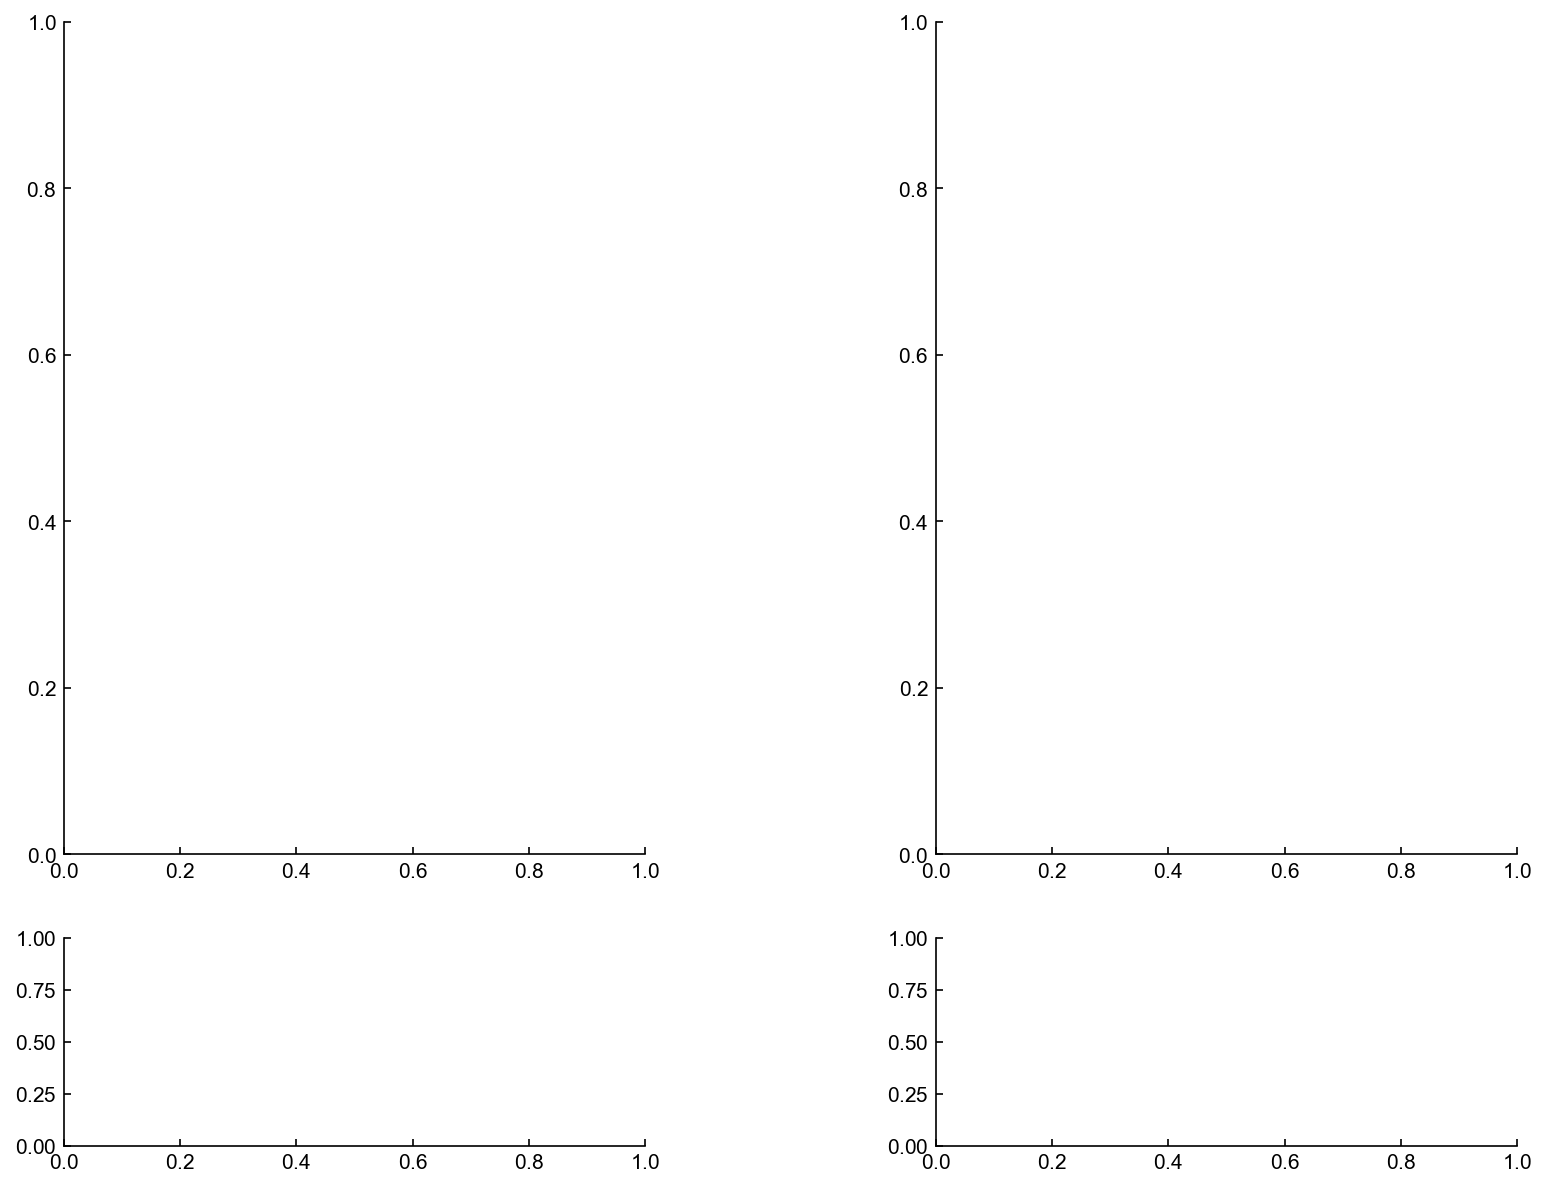

In [569]:
### SEPARATED BY GO/NOGO OR TARGET/NONTARGET

def binData(datatobin,binsize = 10,smoothing = 0):
    bins = np.zeros(len(datatobin))

    for bin in range(len(bins)):
        try:
            s = binsize*bin
            e = (binsize+binsize*bin)
            bins[bin] = np.mean(np.array(datatobin)[s:e])
        except Exception as e:
            print( e)
    bins = np.array(bins)
    bins = bins[np.logical_not(np.isnan(bins))]
    
    tempbins = bins
    for idx in range(len(bins)):
        temp = [np.nan,bins[idx],bins[idx],np.nan]
        if idx > 0:
            temp[0] = bins[idx-1]
        if idx < len(bins)-1:
            temp[3] = bins[idx+1]
        tempbins[idx] = np.nanmean(temp)
    bins = tempbins
    
    return bins

def calculateRunningSTDEV(binnedData,bw=5):
    stdevs = []
    for idx in range(len(binnedData)-bw):
        if(np.mean(binnedData[idx:idx+bw])) > 0:
            stdevs.append(np.std(binnedData[idx:idx+bw]))
    return np.median(stdevs)

def calculateSegments(datatobin,scaling = 1):
    bins = binData(datatobin)
    sigma = calculateRunningSTDEV(bins)
    
    model = "l2"  # "l1", "rbf", "linear", "normal", "ar",...
    #algo = rpt.Binseg(model=model).fit(bins)
    #algo = rpt.BottomUp(model=model).fit(bins)
    #algo = rpt.Window(width=5, model=model).fit(bins)
    
    #my_bkps = algo.predict(pen=np.log(len(bins)) * 1 * 5**2)
    my_bkps = algo.predict(pen= np.log(len(bins)) * sigma**2 / scaling)
    
    return my_bkps

starttime = -0.7
endtime = 2.7
numbins = 100 + 1

height=10
width=1
trans=0.125
custommarker = mpl.path.Path([[-width,-height],[-width,height],[width,height],[width,-height]],closed=True)
    
for session in tqdm(sessions):
    try:
        sessionfile = loadSessionCached(destination,session)
        neurons = sessionfile.clusters.good
        
        ##########################################################################################################################
        #laserON = sessionfile.trials.laser_stimulation
        #laserOFF = np.logical_not(laserON)
        All = np.full((sessionfile.meta.length_in_trials), True)
        GoResponse = sessionfile.trials.go
        NogoResponse = np.logical_not(GoResponse)
        TargetTone = sessionfile.trials.target
        NontargetTone = np.logical_not(TargetTone)
        
        Hits = np.logical_and(TargetTone,GoResponse)
        Misses = np.logical_and(TargetTone,NogoResponse)
        FAlarms = np.logical_and(NontargetTone,GoResponse)
        CRejects = np.logical_and(NontargetTone,NogoResponse)
        Correct = np.logical_or(Hits,CRejects)
        Incorrect = np.logical_or(Misses,FAlarms)
        
        #Condition A
        conditionA = SimpleNamespace()
        conditionA.trials = All
        conditionA.label = 'All'
        conditionA.color = 'grey'

        conditions = [conditionA]
        #Convert trials into idxs -- more useful for algorithm
        for cond in conditions:
            cond.trials = np.array(np.where(cond.trials)[0])
        ##########################################################################################################################
        totaltrials = 0
        for cond in conditions:
            totaltrials += len(cond.trials)
        
        for clust in neurons:
            plt.close('all')
            fig = plt.figure(figsize=(12.5,12.5))
            gs = fig.add_gridspec(3,2,height_ratios=[4,1,1],hspace=0.2,wspace=0.5)#0.1)
                
            ax1 = plt.subplot(gs[0,0])#Raster
            ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
            ax3 = plt.subplot(gs[0,1],sharex=ax1)#FRs
            ax4 = plt.subplot(gs[1,1])#,sharex=ax1,sharey=ax2)#Percent Go
            
            #Caching search -- Unit
            idx = np.equal(sessionfile.spikes.clusters,clust)
            totaltimes = sessionfile.spikes.times[idx]
            
            FRpertrial = []
            #Overall Nonstationarity
            for trial in range(sessionfile.meta.length_in_trials):
                trialstart = sessionfile.trials.starts[trial]
                trialend = sessionfile.trials.ends[trial]
                idxtone = np.logical_and(   np.greater(totaltimes,trialstart) , np.less(totaltimes,trialend)  )
                timestone = totaltimes[idxtone]
                trialtime = (trialend-trialstart) / sessionfile.meta.fs
                FRpertrial.append(len(timestone) / trialtime)
            
            for cond in conditions:         
                cond.latency = []
                cond.firingrates = []
                cond.timestoplot = []
                cond.trialstoplot = []
                cond.responsetimestoplot = []
                cond.responsetrialstoplot = []
                cond.peristimulustimes = []
                cond.onsetmodulation = np.nan
                cond.offsetmodulation = np.nan
                cond.pc = np.nan
                cond.dp = np.nan
                
                cond.firingbins100 = []
                cond.firingbins200 = []
                
                pretonebin1 = []
                pretonebin2 = []
                tonebin = []
                posttonebin = []
                
                #Calculate Behavior Stats
                temparray = np.zeros(sessionfile.meta.length_in_trials)
                temparray[cond.trials] = np.ones(len(cond.trials))
                condhits = np.sum(np.logical_and(temparray,Hits))
                condmisses = np.sum(np.logical_and(temparray,Misses))
                condfalarms = np.sum(np.logical_and(temparray,FAlarms))
                condcrejects = np.sum(np.logical_and(temparray,CRejects))
                
                try:
                    cond.pc = (condhits+condmisses) / (condhits+condmisses+condfalarms+condcrejects)
                except Exception:
                    pass
                try:
                    cond.dp = norm.ppf((condhits+1)/(condhits+condmisses+2)) - norm.ppf((condfalarms+1)/(condfalarms+condcrejects+2))
                except Exception:
                    pass
                
                for trialidx in range(len(cond.trials)):
                    trial = cond.trials[trialidx]
                    trialstart = sessionfile.trials.starts[trial]
                    
                    #Caching search -- Condition
                    idx = np.logical_and(      np.greater(totaltimes,trialstart+starttime*sessionfile.meta.fs) , np.less(totaltimes,trialstart+endtime*sessionfile.meta.fs)     )
                    times = totaltimes[idx]
                    
                    #PSTH times
                    cond.peristimulustimes = np.concatenate((cond.peristimulustimes,(times-trialstart)/sessionfile.meta.fs*1000))
                    
                    #Response times
                    if (sessionfile.trials.go[trial]):
                        cond.responsetimestoplot.append((sessionfile.trials.response[trial]-trialstart)/sessionfile.meta.fs*1000)
                        cond.responsetrialstoplot.append(trialidx+1)
                    
                    #Each spike time to plot
                    for spike in ((times-trialstart)/sessionfile.meta.fs*1000):
                        cond.timestoplot.append(spike)
                        cond.trialstoplot.append(trialidx+1)
                    
                    #Caching search -- Pre-tone period (1)
                    binstart = trialstart-0.2*sessionfile.meta.fs
                    binend = trialstart-0.1*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    pretonebin1.append(len(timestone))
                    
                    #Caching search -- Pre-tone period (2)
                    binstart = trialstart-0.1*sessionfile.meta.fs
                    binend = trialstart+0*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    pretonebin2.append(len(timestone))
                    
                    #Caching search -- Tone Period
                    binstart = trialstart+0*sessionfile.meta.fs
                    binend = trialstart+0.1*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    tonebin.append(len(timestone))
                    cond.firingbins100.append(len(timestone))
                    tempvar = (len(timestone))
                    #Latency and firing rate
                    if len(timestone)>0:
                        cond.latency.append( (np.min(timestone)-trialstart)/sessionfile.meta.fs*1000)
                    else:
                        cond.latency.append(np.nan)
                    cond.firingrates.append(len(timestone) / (0.1))
                    
                    #Caching search -- Post-tone period
                    binstart = trialstart+0.1*sessionfile.meta.fs
                    binend = trialstart+0.2*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    posttonebin.append(len(timestone))
                    cond.firingbins200.append(len(timestone)+tempvar)
                    
                    #Calculate bootstrapped firing rate modulation
                    pretonebins = np.concatenate((pretonebin1,pretonebin2))
                    numtrials = len(tonebin)
                    FRmodonset = []
                    FRmodoffset = []
                    for sample in range(100):
                        baseline = np.mean(np.random.choice(pretonebins,size=int(0.9*numtrials),replace=True))
                        if baseline == 0:
                            baseline = 0.01
                        onset = np.mean(np.random.choice(tonebin,size=int(0.9*numtrials),replace=True))
                        offset = np.mean(np.random.choice(posttonebin,size=int(0.9*numtrials),replace=True))
                        FRmodonset.append((onset-baseline))
                        FRmodoffset.append((offset-baseline))
                    cond.onsetmodulation = np.mean(FRmodonset)*10 #Scaling factor from 100ms bin to firing rate (1s)
                    cond.offsetmodulation = np.mean(FRmodoffset)*10
            #NOTE HERE            
                        
            #############################################---TRIMMING---#############################################
                
            lengththreshold = 100 #trials
            FRthreshold = 0.5 #S/s
            slopethreshold = 50 /100 #% of max slope per 100 trials
            detrendSTDthreshold = 50 #% of max slope
                
            #Calculate breakpoints with Binary Segmentation
            breakpoints = np.array(calculateSegments(FRpertrial,scaling=0.05))*10
            breakpoints = np.concatenate(([0],breakpoints,[sessionfile.meta.length_in_trials]))
            breakpoints = np.sort(np.unique(breakpoints))
            bins = [ [breakpoints[idx],breakpoints[idx+1]] for idx in range(len(breakpoints)-1)]
            
            validbins = np.zeros(len(bins))
            for binidx in range(len(bins)):
                
                bin = bins[binidx]
                binstart = bin[0]
                binend = bin[1]
                trials = list(range(binstart,binend))
                
                #Calculate bin length
                binlength = binend-binstart
                
                #Calculate bin FR
                binFR = np.mean(FRpertrial[binstart:binend])
                
                #Calculate regression slope in units of %ofmaxFR/trial
                FR = FRpertrial[binstart:binend]
                #slope, intercept, r, p, std_err
                slope, intercept, _, _, _ = linregress(trials,FR)
                maxFR = np.maximum(slope,intercept+slope*binlength)
                normslope = slope / maxFR*100
                
                #Calculate detrended variance
                trend = np.array(range(len(FR)))
                trend = (trend * slope) + intercept
                detrendedFR = FR - trend
                detrendedSTD = np.std(detrendedFR)
                detrendedSTD = detrendedSTD / maxFR*100
                
                isbinvalid = True
                if binlength < lengththreshold:
                    #print('Invalid Length')
                    isbinvalid = False
                if binFR < FRthreshold:
                    #print('Invalid FR')
                    isbinvalid = False
                if normslope > slopethreshold:
                    #print('Invalid Slope')
                    isbinvalid = False
                if detrendedSTD > detrendSTDthreshold:
                    #print('Invalid STD')
                    isbinvalid = False
                validbins[binidx] = isbinvalid
            
            #############################################---PLOTTING---#############################################
                
            #Plot Rasters
            #ylims1 = [1,totaltrials]
            offset = 0
            tickmeans = []
            ticklabels = []
            numtrials = 0
            for cond in [conditions[0]]:
                ax1.scatter(cond.timestoplot,np.array(cond.trialstoplot)+offset,s=7.5,c=cond.color,marker=custommarker.vertices)
                #ax1.scatter(cond.responsetimestoplot,np.array(cond.responsetrialstoplot)+offset,s=7.5,c='black')
                tickmeans.append(0.5*len(cond.trials)+offset)
                #ax1.fill_between([starttime*1000,endtime*1000],[offset,offset],[offset+len(cond.trials),offset+len(cond.trials)],fc=cond.color,alpha=trans,zorder=-10)
                offset += len(cond.trials)
                ticklabels.append(cond.label+'\n Onset: '+str(np.round(cond.onsetmodulation,2))+'\n Offset: '+str(np.round(cond.offsetmodulation,2)))
                numtrials += len(cond.trials)
            xlims = ax1.get_xlim()
            for bp in breakpoints:
                ax1.plot(xlims,[bp,bp],color='blue',lw=2,zorder=10)
            for binidx in range(len(bins)):
                bin = bins[binidx]
                binstart = bin[0]
                binend = bin[1]
                validbin = validbins[binidx]
                
                if validbin:
                    ax1.fill_between(xlims,[binstart,binstart],[binend,binend],alpha=trans,color='green',zorder=9)
                else:
                    ax1.fill_between(xlims,[binstart,binstart],[binend,binend],alpha=trans,color='red',zorder=9)
            ax1.set_xlim(xlims)
            ylims1 = [1,numtrials]
            #Label Conditions
            #ticks = [1, np.round(len(trialidxs)/20)*10 ,len(trialidxs)]
            ax1.set_ylim(ylims1)
            #ax1.set_yticks(tickmeans,minor=False)
            #ax1.set_yticklabels(ticklabels,rotation=45)
            #Plot Tone/Laser
            ax1.fill_between([0,100],[ylims1[1],ylims1[1]],color='grey',alpha=trans)
            ax1.set_ylabel('Trial')
            
            ##Plot Rasters
            ##ylims1 = [1,totaltrials]
            #offset = 0
            #tickmeans = []
            #ticklabels = []
            #numtrials = 0
            #for cond in [conditions[1]]:
            #    ax3.scatter(cond.timestoplot,np.array(cond.trialstoplot)+offset,s=7.5,c=cond.color,marker=custommarker.vertices)
            #    #ax3.scatter(cond.responsetimestoplot,np.array(cond.responsetrialstoplot)+offset,s=7.5,c='black')
            #    tickmeans.append(0.5*len(cond.trials)+offset)
            #    #ax3.fill_between([starttime*1000,endtime*1000],[offset,offset],[offset+len(cond.trials),offset+len(cond.trials)],fc=cond.color,alpha=trans,zorder=-10)
            #    offset += len(cond.trials)
            #    ticklabels.append(cond.label+'\n Onset: '+str(np.round(cond.onsetmodulation,2))+'\n Offset: '+str(np.round(cond.offsetmodulation,2)))
            #    numtrials += len(cond.trials)
            #ylims1 = [1,numtrials]
            ##Label Conditions
            ##ticks = [1, np.round(len(trialidxs)/20)*10 ,len(trialidxs)]
            #ax3.set_ylim(ylims1)
            ##ax3.set_yticks(tickmeans,minor=False)
            ##ax3.set_yticklabels(ticklabels,rotation=45)
            ##Plot Tone/Laser
            #ax3.fill_between([0,100],[ylims1[1],ylims1[1]],color='grey',alpha=trans)
            #ax3.set_ylabel('Trial')
            
            #Plot PSTHs
            bw=0.05
            xrange = np.linspace(starttime*1000,endtime*1000-starttime*1000,num=1000)
            ind = 0
            for cond in [conditions[0]]:
                try:
                    KDE = gaussian_kde((cond.peristimulustimes),bw_method=bw).evaluate(xrange)
                    targetmean = len(cond.peristimulustimes) / (endtime-starttime) / len(cond.trials)
                    #if(sigs[ind]):
                    ax2.plot(xrange,targetmean*KDE/np.mean(KDE),c=cond.color,lw=2)
                    #else:
                    #    ax2.plot(xrange,targetmean*KDE/np.mean(KDE),c=cond.color,lw=2,alpha=0.25)
                except Exception as e:
                    print('PSTHs: '+str(e))
                ind = ind + 1
            
            #Plot FR over time
            for cond in [conditions[0]]:
                ax4.plot(cond.firingrates,color='black')
                ax4.set_ylabel('Firing rate (S/s)')
                ax4.set_xlabel('Trial')
            ylims = ax4.get_ylim()
            for bp in breakpoints:
                ax4.plot([bp,bp],ylims,color='blue',lw=2)
            ax4.set_ylim(ylims)
            for binidx in range(len(bins)):
                bin = bins[binidx]
                binstart = bin[0]
                binend = bin[1]
                validbin = validbins[binidx]
                
                if validbin:
                    ax4.fill_between([binstart,binend],[ylims[0],ylims[0]],[ylims[1],ylims[1]],alpha=trans,color='green',zorder=9)
                else:
                    ax4.fill_between([binstart,binend],[ylims[0],ylims[0]],[ylims[1],ylims[1]],alpha=trans,color='red',zorder=9)
                
            
            ##Plot PSTHs
            #bw=0.05
            #xrange = np.linspace(starttime*1000,endtime*1000-starttime*1000,num=1000)
            #ind = 0
            #for cond in [conditions[1]]:
            #    try:
            #        KDE = gaussian_kde((cond.peristimulustimes),bw_method=bw).evaluate(xrange)
            #        targetmean = len(cond.peristimulustimes) / (endtime-starttime) / len(cond.trials)
            #        #if(sigs[ind]):
            #        ax4.plot(xrange,targetmean*KDE/np.mean(KDE),c=cond.color,lw=2)
            #        #else:
            #        #    ax4.plot(xrange,targetmean*KDE/np.mean(KDE),c=cond.color,lw=2,alpha=0.25)
            #    except Exception as e:
            #        print('PSTHs: '+str(e))
            #    ind = ind + 1

            ylims2 = ax2.get_ylim()
            ax2.fill_between([0,100],[ylims2[1],ylims2[1]],color='grey',alpha=trans)
            ax2.set_ylabel('Spikes per second')
            ax2.set_xlabel('Time (ms)')
            
            #ylims4 = ax4.get_ylim()
            #ax4.fill_between([0,100],[ylims4[1],ylims4[1]],color='grey',alpha=trans)
            #ax4.set_ylabel('Spikes per second')
            #ax4.set_xlabel('Time (ms)')
            
            ax1.set_xlim([-500,2500])
            
            fig.savefig(os.path.join('D:\\\\TempFigures','Stationarity2',session + ' cluster ' + str(clust) + ' TargNontarg.png'),transparent=False,facecolor="white")
    except Exception as e:
        print(e)

C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[5, 10, 20, 30, 40, 45, 48]
[10, 20, 50, 55, 80, 90, 96]


(<Figure size 1500x900 with 1 Axes>, [<AxesSubplot:>])

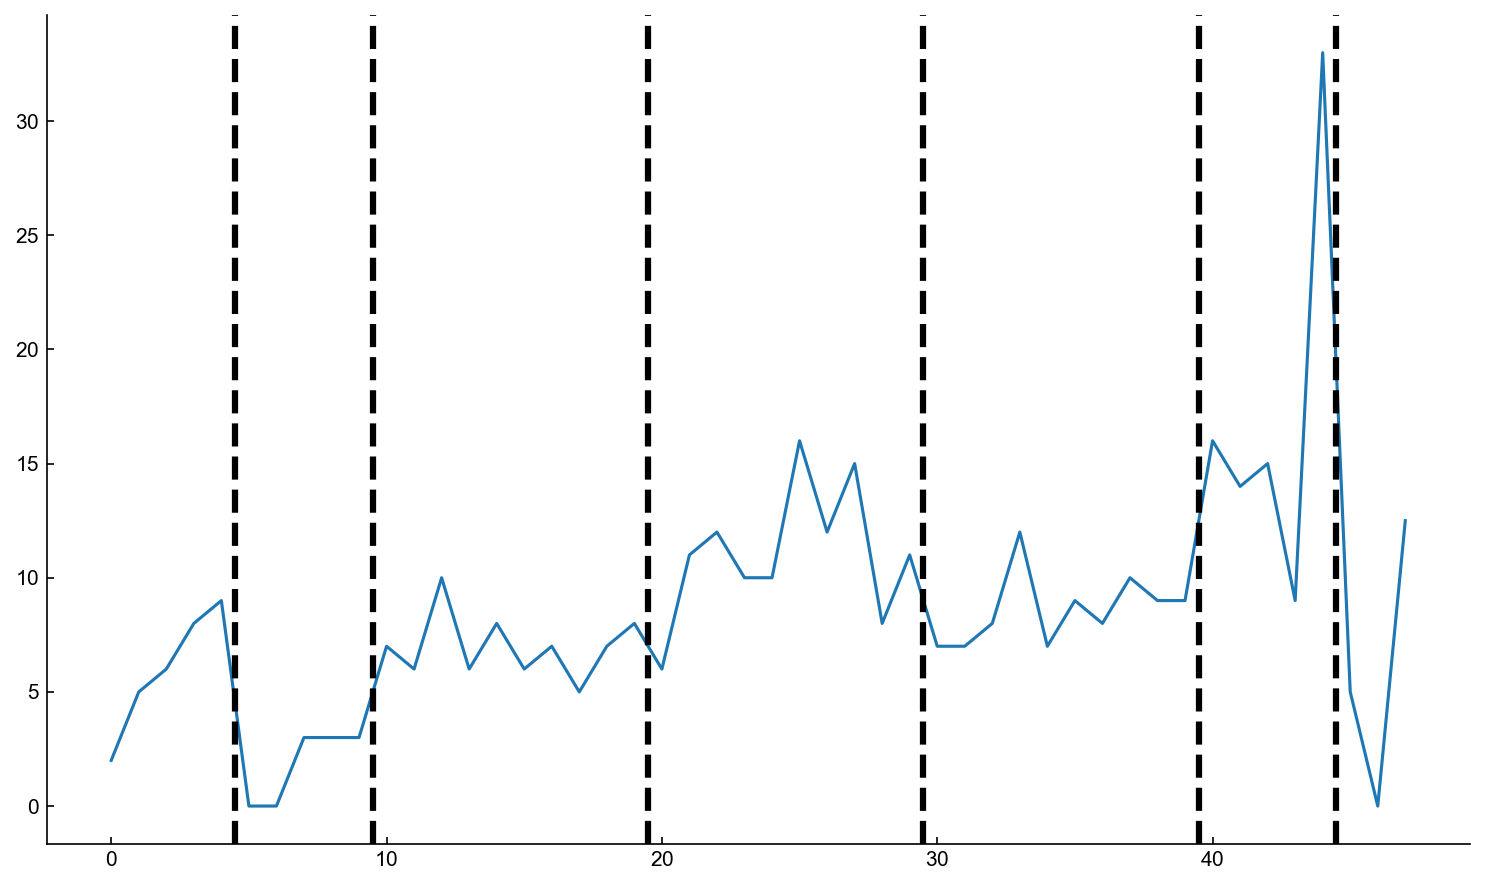

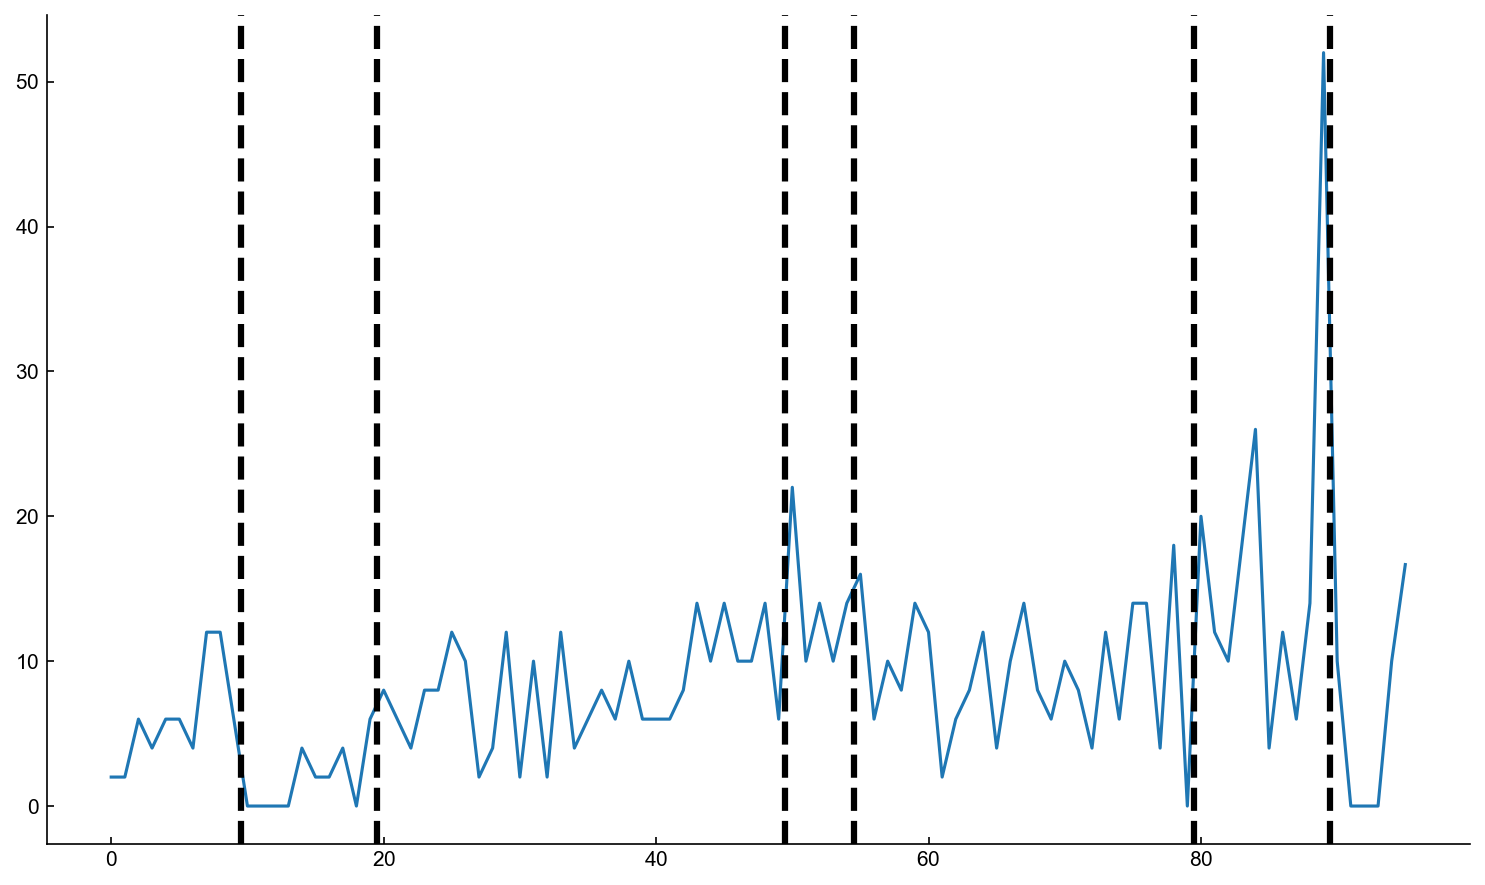

In [547]:
def binData(datatobin,binsize = 10,smoothing = 0):
    bins = np.zeros(len(datatobin))

    for bin in range(len(bins)):
        try:
            s = binsize*bin
            e = (binsize+binsize*bin)
            bins[bin] = np.mean(np.array(datatobin)[s:e])
        except Exception as e:
            print( e)
    bins = np.array(bins)
    bins = bins[np.logical_not(np.isnan(bins))]
    
    for smooth in range(smoothing):
        tempbins = bins
        for idx in range(len(bins)):
            temp = [np.nan,bins[idx],bins[idx],np.nan]
            if idx > 0:
                temp[0] = bins[idx-1]
            if idx < len(bins)-1:
                temp[3] = bins[idx+1]
            tempbins[idx] = np.nanmean(temp)
        bins = tempbins
    
    return bins

def calculateRunningSTDEV(binnedData,bw=5):
    stdevs = []
    for idx in range(len(binnedData)-bw):
        if(np.mean(binnedData[idx:idx+bw])) > 0:
            stdevs.append(np.std(binnedData[idx:idx+bw]))
    return np.median(stdevs)

def calculateSegments(datatobin,binsize=10,smoothing=0):
    bins = binData(datatobin,binsize=binsize,smoothing=smoothing)
    sigma = calculateRunningSTDEV(bins)
    
    model = "l2"  # "l1", "rbf", "linear", "normal", "ar",...
    #algo = rpt.Binseg(model=model).fit(bins)
    algo = rpt.BottomUp(model=model).fit(bins)
    
    #my_bkps = algo.predict(pen=np.log(len(bins)) * 1 * 5**2)
    my_bkps = algo.predict(pen= np.log(len(bins)) * sigma**2)
    
    return my_bkps

bins = binData(datatobin,smoothing=0)
my_bkps = calculateSegments(datatobin,smoothing=0)
print(my_bkps)
rpt.show.display(bins, [], my_bkps, figsize=(10, 6))

bins = binData(datatobin,binsize=5,smoothing=0)
my_bkps = calculateSegments(datatobin,binsize=5,smoothing=0)
print(my_bkps)
rpt.show.display(bins, [], my_bkps, figsize=(10, 6))

In [887]:
clust = 42
sessionfile.clusters.good

array([ 0,  8, 21, 32, 42, 61, 67, 72, 74, 80], dtype=int64)

In [888]:
spikeidxs = np.equal(sessionfile.spikes.clusters,clust)
spiketimes = sessionfile.spikes.times[spikeidxs]

[51042511]
1898.8571666666667


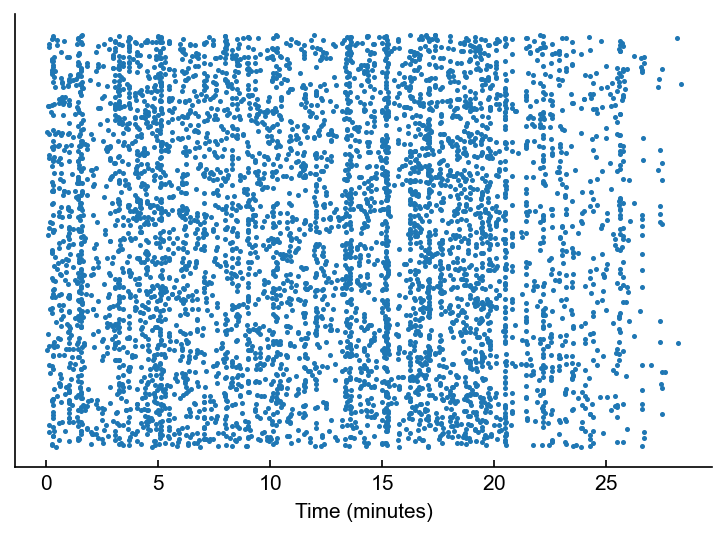

In [892]:
factor = sessionfile.meta.fs*60
X = spiketimes
Y = np.random.rand(len(spiketimes))
plt.scatter(X/factor,Y,s=2)
plt.yticks([])
plt.xlabel('Time (minutes)')
print(max(X))
print((sessionfile.meta.length_in_samples - max(X)[0])/sessionfile.meta.fs)

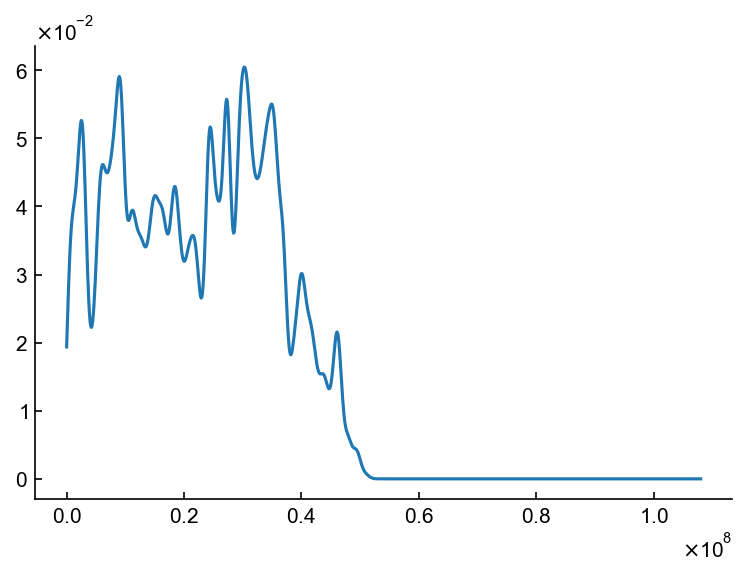

In [890]:
xrange = np.linspace(0,sessionfile.meta.length_in_samples,num=1000)
factor = sessionfile.meta.fs*60
KDE = gaussian_kde(np.concatenate(spiketimes/factor),bw_method=0.05).evaluate(xrange/factor)
plt.plot(xrange,KDE)

Text(0.5, 77.875, 'Time (unitless. 1000 = full recording)')

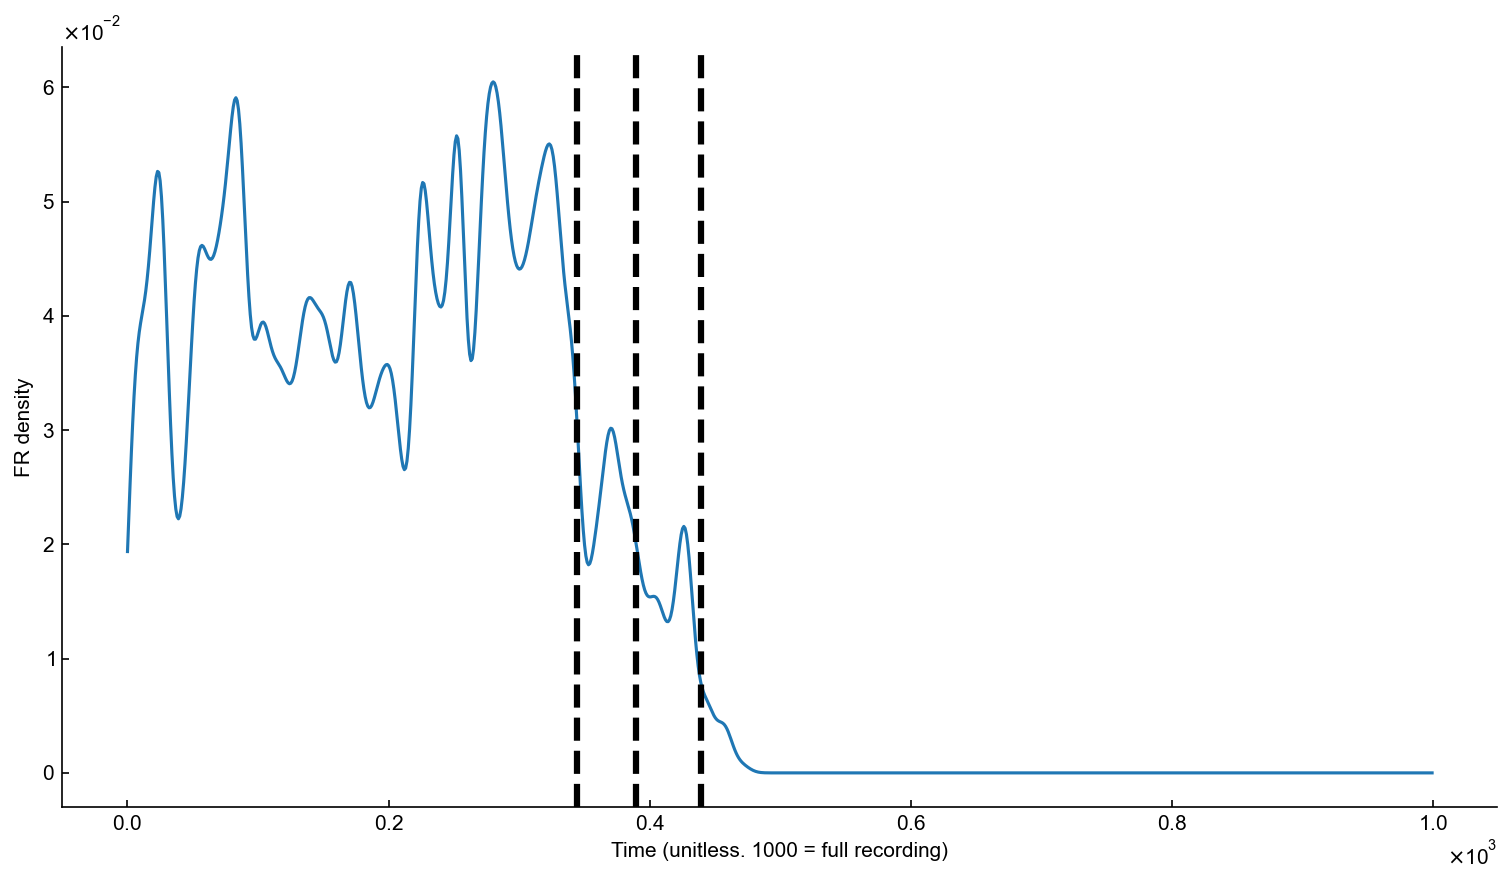

In [893]:

#bins = binData(datatobin,binsize=binsize,smoothing=smoothing)
sigma = calculateRunningSTDEV(KDE,bw=50)
    
model = "l2"  # "l1", "rbf", "linear", "normal", "ar",...
algo = rpt.Binseg(model=model).fit((KDE))
#my_bkps = algo.predict(n_bkps=2)
my_bkps = algo.predict(pen= np.log(len(KDE)) * sigma**2 * 100)

rpt.show.display(KDE, [], my_bkps, figsize=(10, 6))
plt.ylabel('FR density')
plt.xlabel('Time (unitless. 1000 = full recording)')